In [19]:
%load_ext autoreload
%autoreload 2

### Torch and related packages ###
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

### Utility functions ###
from utils.dataset import *
from utils.loss import *
from utils.metrics import *
from utils.model import *

### Image processing functions ###
from skimage.transform import rotate
from skimage.util import montage
from sklearn.model_selection import train_test_split
import cv2

### OS functions ###
import os
import time
import json

### Optimization settings ###
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic= False

%matplotlib inline
%config InlineBackend.figure_format='retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dataset

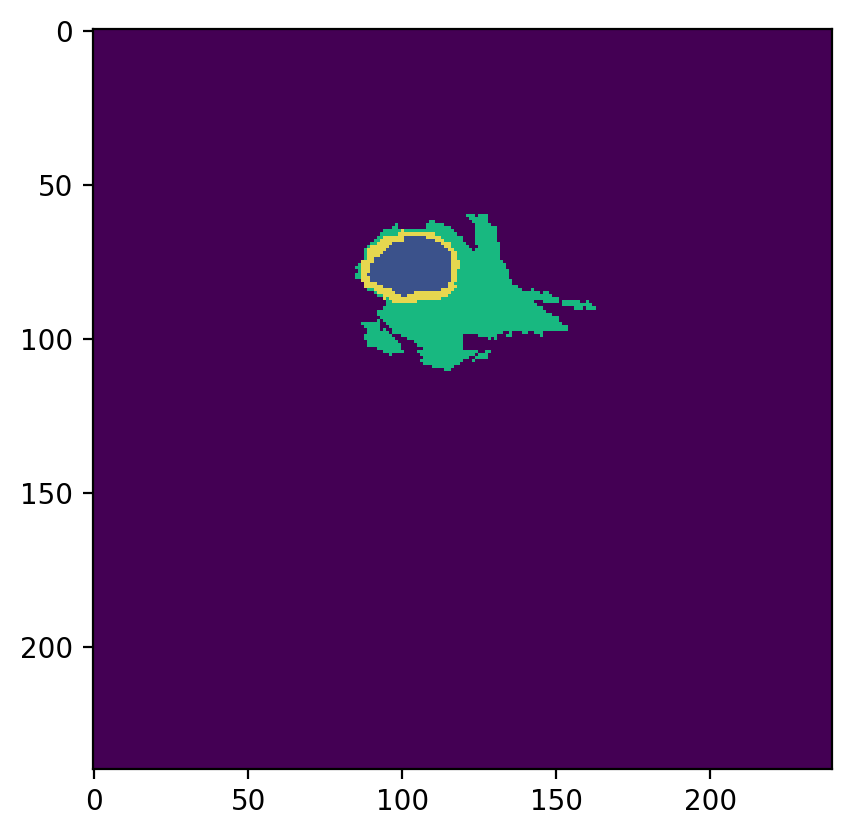

In [20]:
main_path = "./MICCAI_BraTS2020_TrainingData/BraTS20_Training_002"
# main_path = "./MICCAI_BraTS2020_TrainingData"

t1 = (nib.load(main_path + "/BraTS20_Training_002_t1.nii")).get_fdata()
t1ce = (nib.load(main_path + "/BraTS20_Training_002_t1ce.nii")).get_fdata()
t2 = (nib.load(main_path + "/BraTS20_Training_002_t2.nii")).get_fdata()
flair = (nib.load(main_path + "/BraTS20_Training_002_flair.nii")).get_fdata()
seg = (nib.load(main_path + "/BraTS20_Training_002_seg.nii")).get_fdata()

cmap = mpl.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

plt.imshow(seg[:,:,60], cmap=cmap, norm=norm)
plt.show()

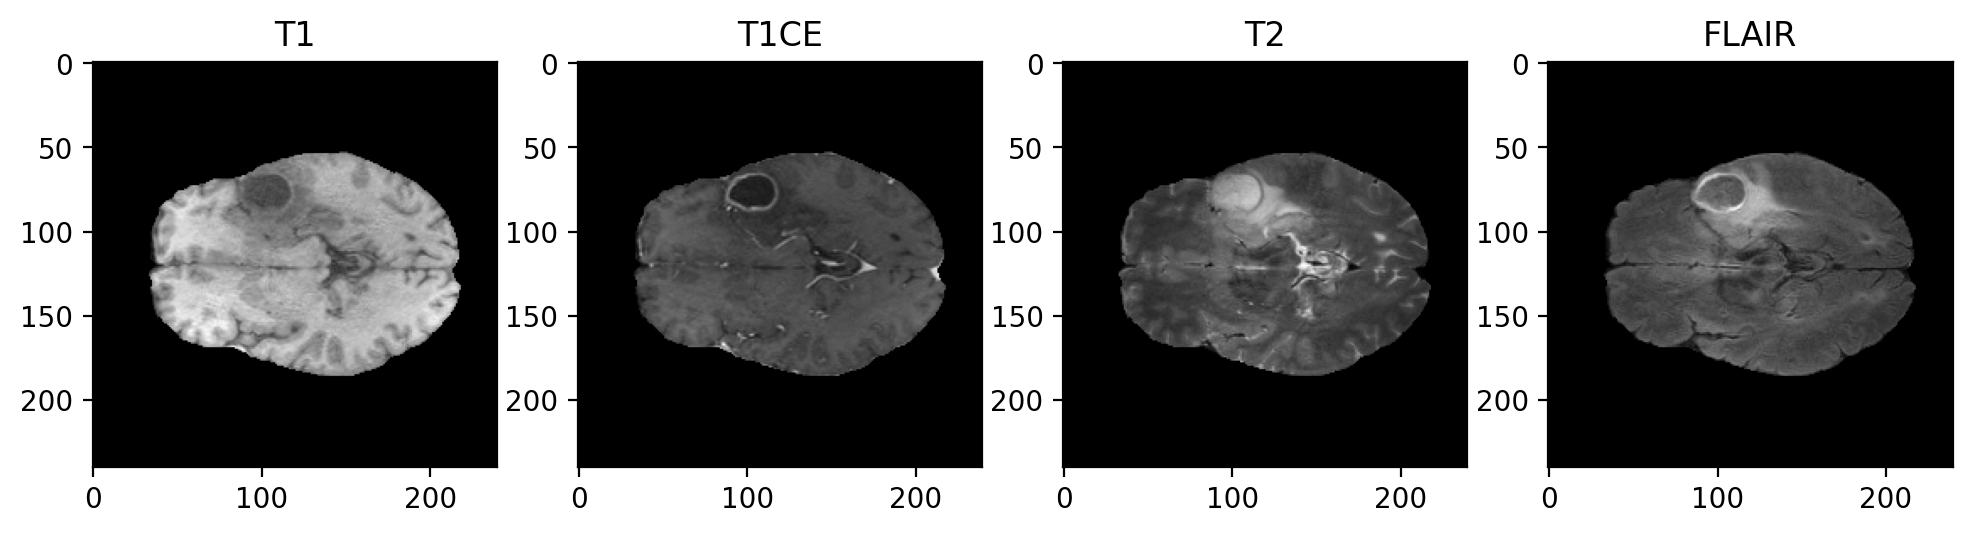

In [21]:
fig, axs = plt.subplots(1,4, figsize=(12,12))
axs[0].imshow(t1[:,:,60], cmap='gray')
axs[0].set_title('T1')
axs[1].imshow(t1ce[:,:,60], cmap='gray')
axs[1].set_title('T1CE')
axs[2].imshow(t2[:,:,60], cmap='gray')
axs[2].set_title('T2')
axs[3].imshow(flair[:,:,60], cmap='gray')
axs[3].set_title('FLAIR')
plt.show()


(240, 240, 155)


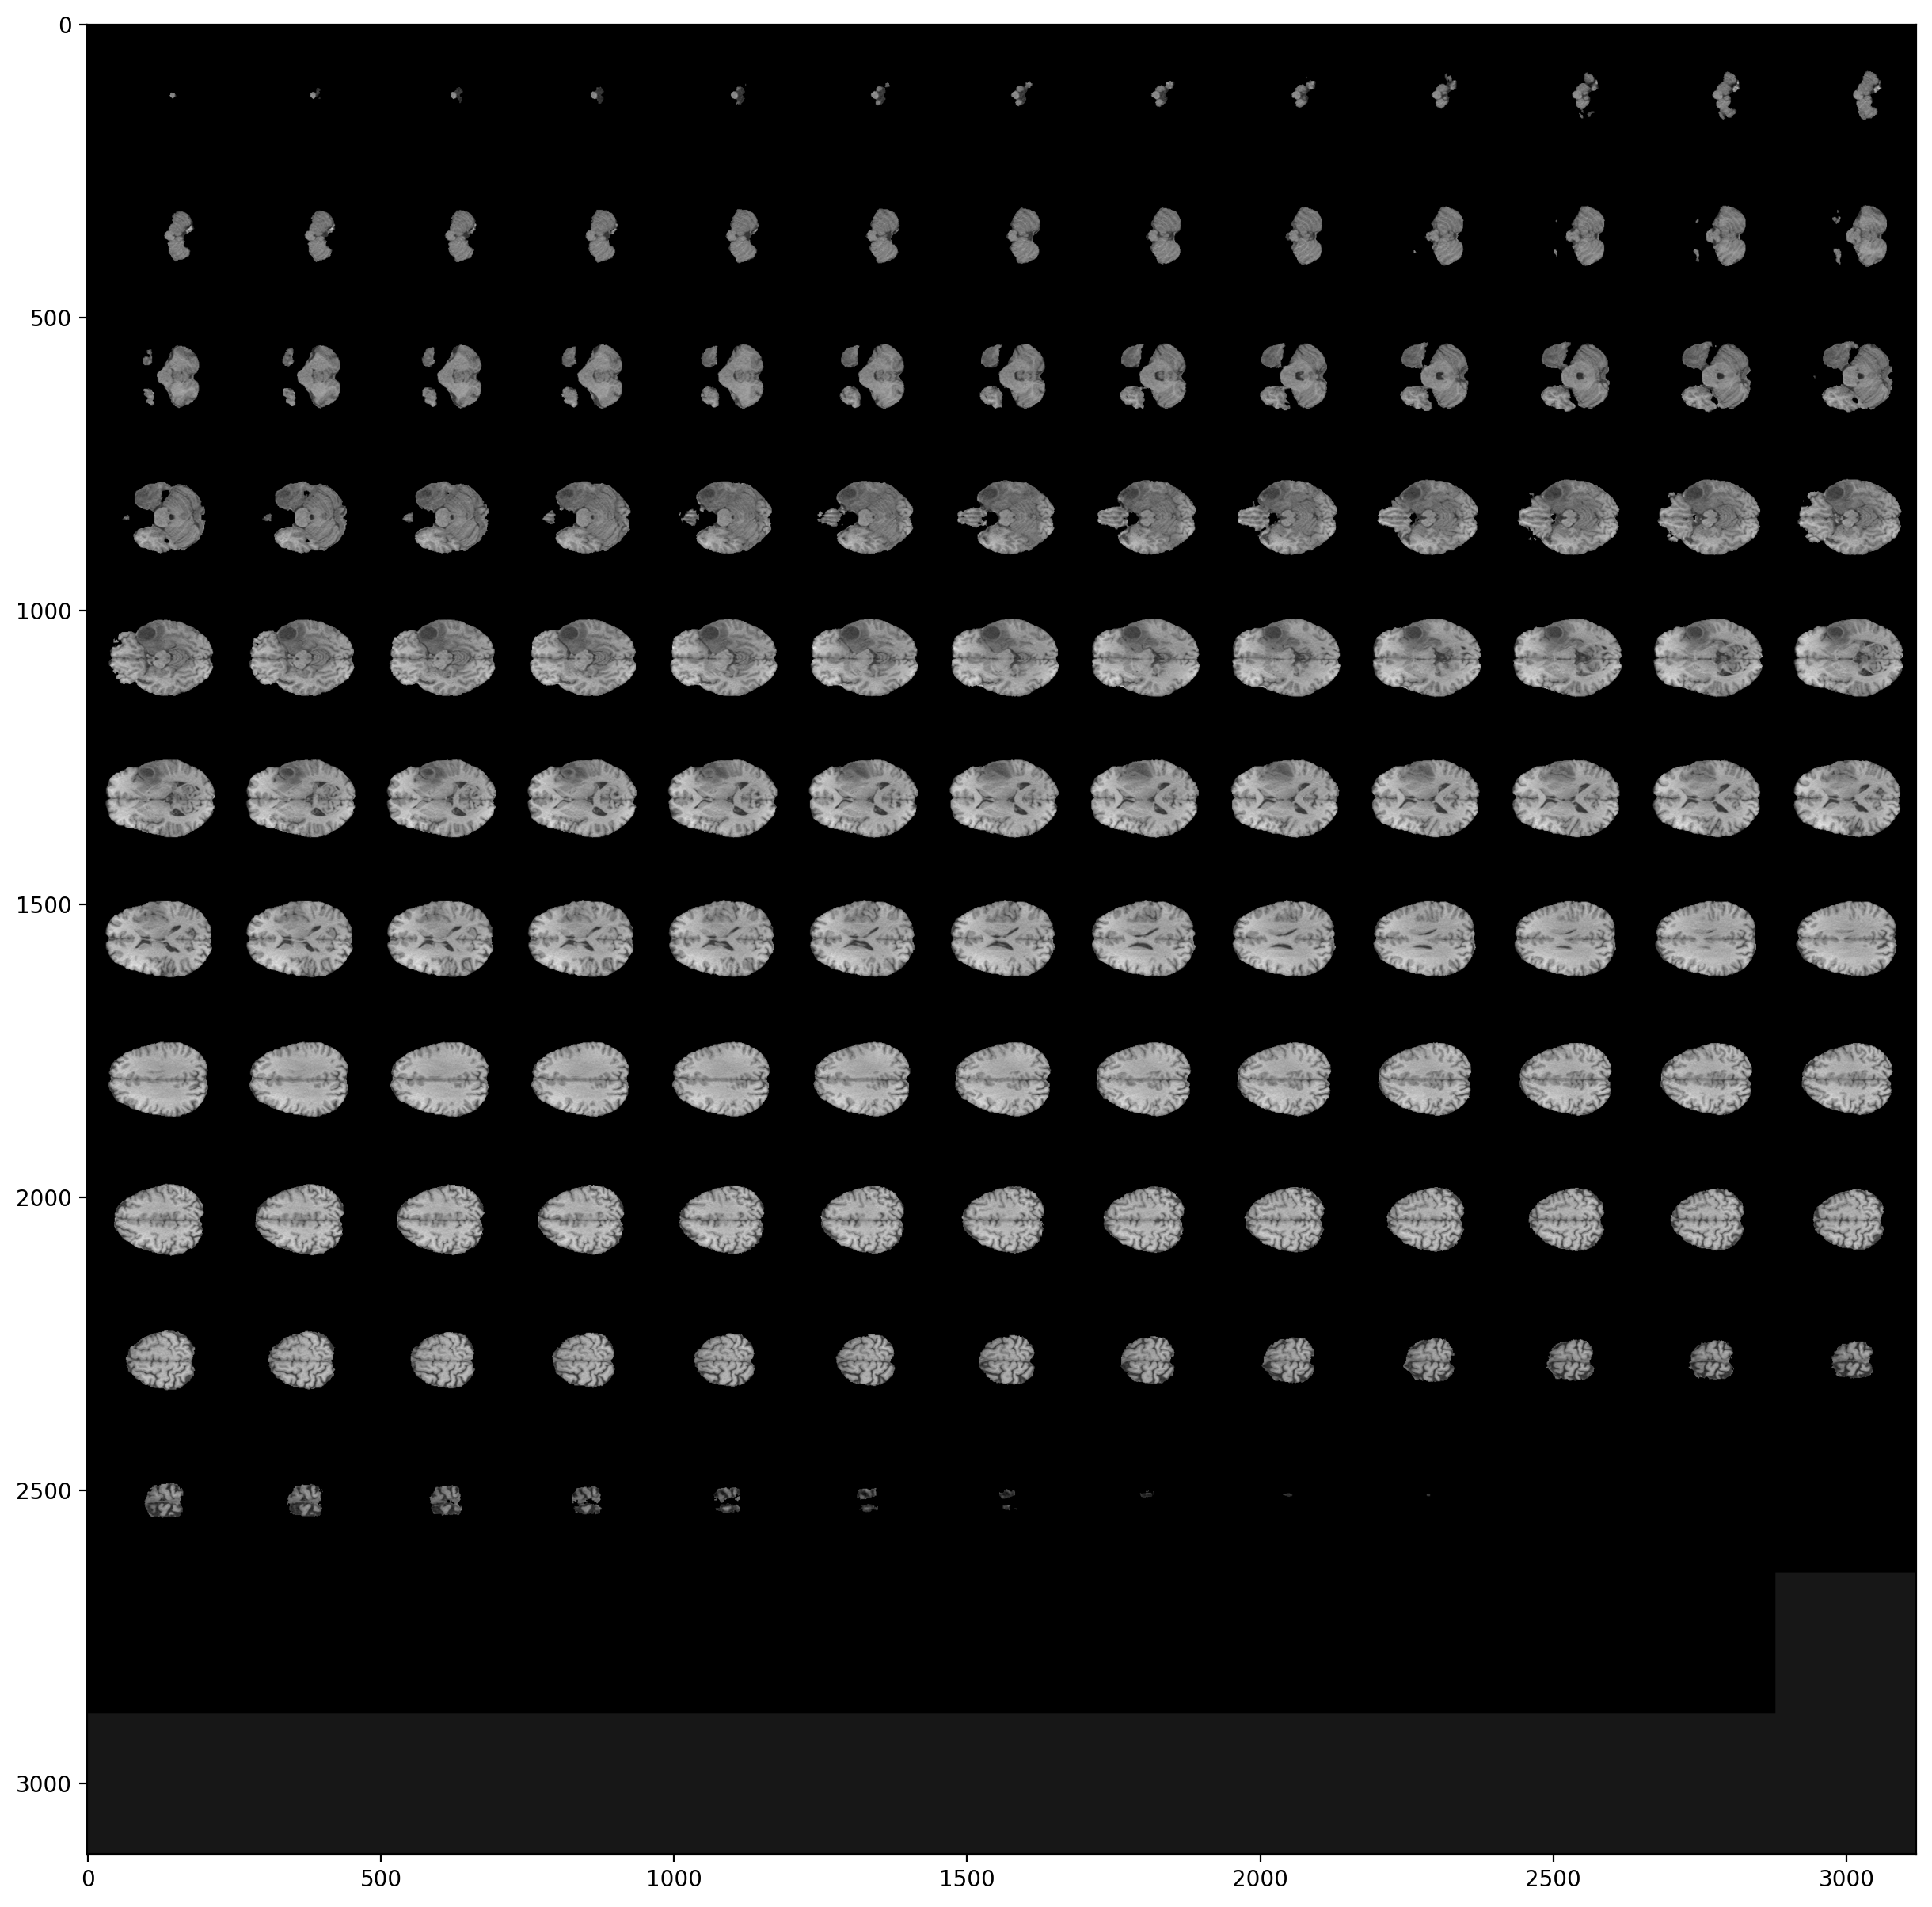

In [22]:
t1_resize = ToTensor()(cv2.resize(t1, (240,240)))
print(t1.shape)
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(montage(t1_resize[:,:,:]), cmap ='gray')

In [23]:
main_path = "./MICCAI_BraTS2020_TrainingData"
sample_path = os.listdir(main_path)
sample_path = [x for x in sample_path if "BraTS" in x]
print(len(sample_path))

369


In [24]:
train_path, val_path = train_test_split(sample_path, test_size=0.3, random_state=100)
val_path, test_path = train_test_split(val_path, test_size=0.33, random_state=100)
print(f'Num train sample: {len(train_path)}')
print(f'Num val sample: {len(val_path)}')
print(f'Num test sample: {len(test_path)}')

Num train sample: 258
Num val sample: 74
Num test sample: 37


In [25]:
START = 52
NUM_SLICE = 50
train_set = BraTS_Data(train_path, start=START, num_slice=NUM_SLICE)
val_set = BraTS_Data(val_path, start=START, num_slice=NUM_SLICE)
test_set = BraTS_Data(test_path, start=START, num_slice=NUM_SLICE)

In [26]:
train_loader = DataLoader(train_set, batch_size=1, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)

In [27]:
train_X, train_y = next(iter(train_loader))
print(train_X.shape)
print(train_y.shape)

torch.Size([1, 50, 2, 128, 128])
torch.Size([1, 50, 4, 128, 128])


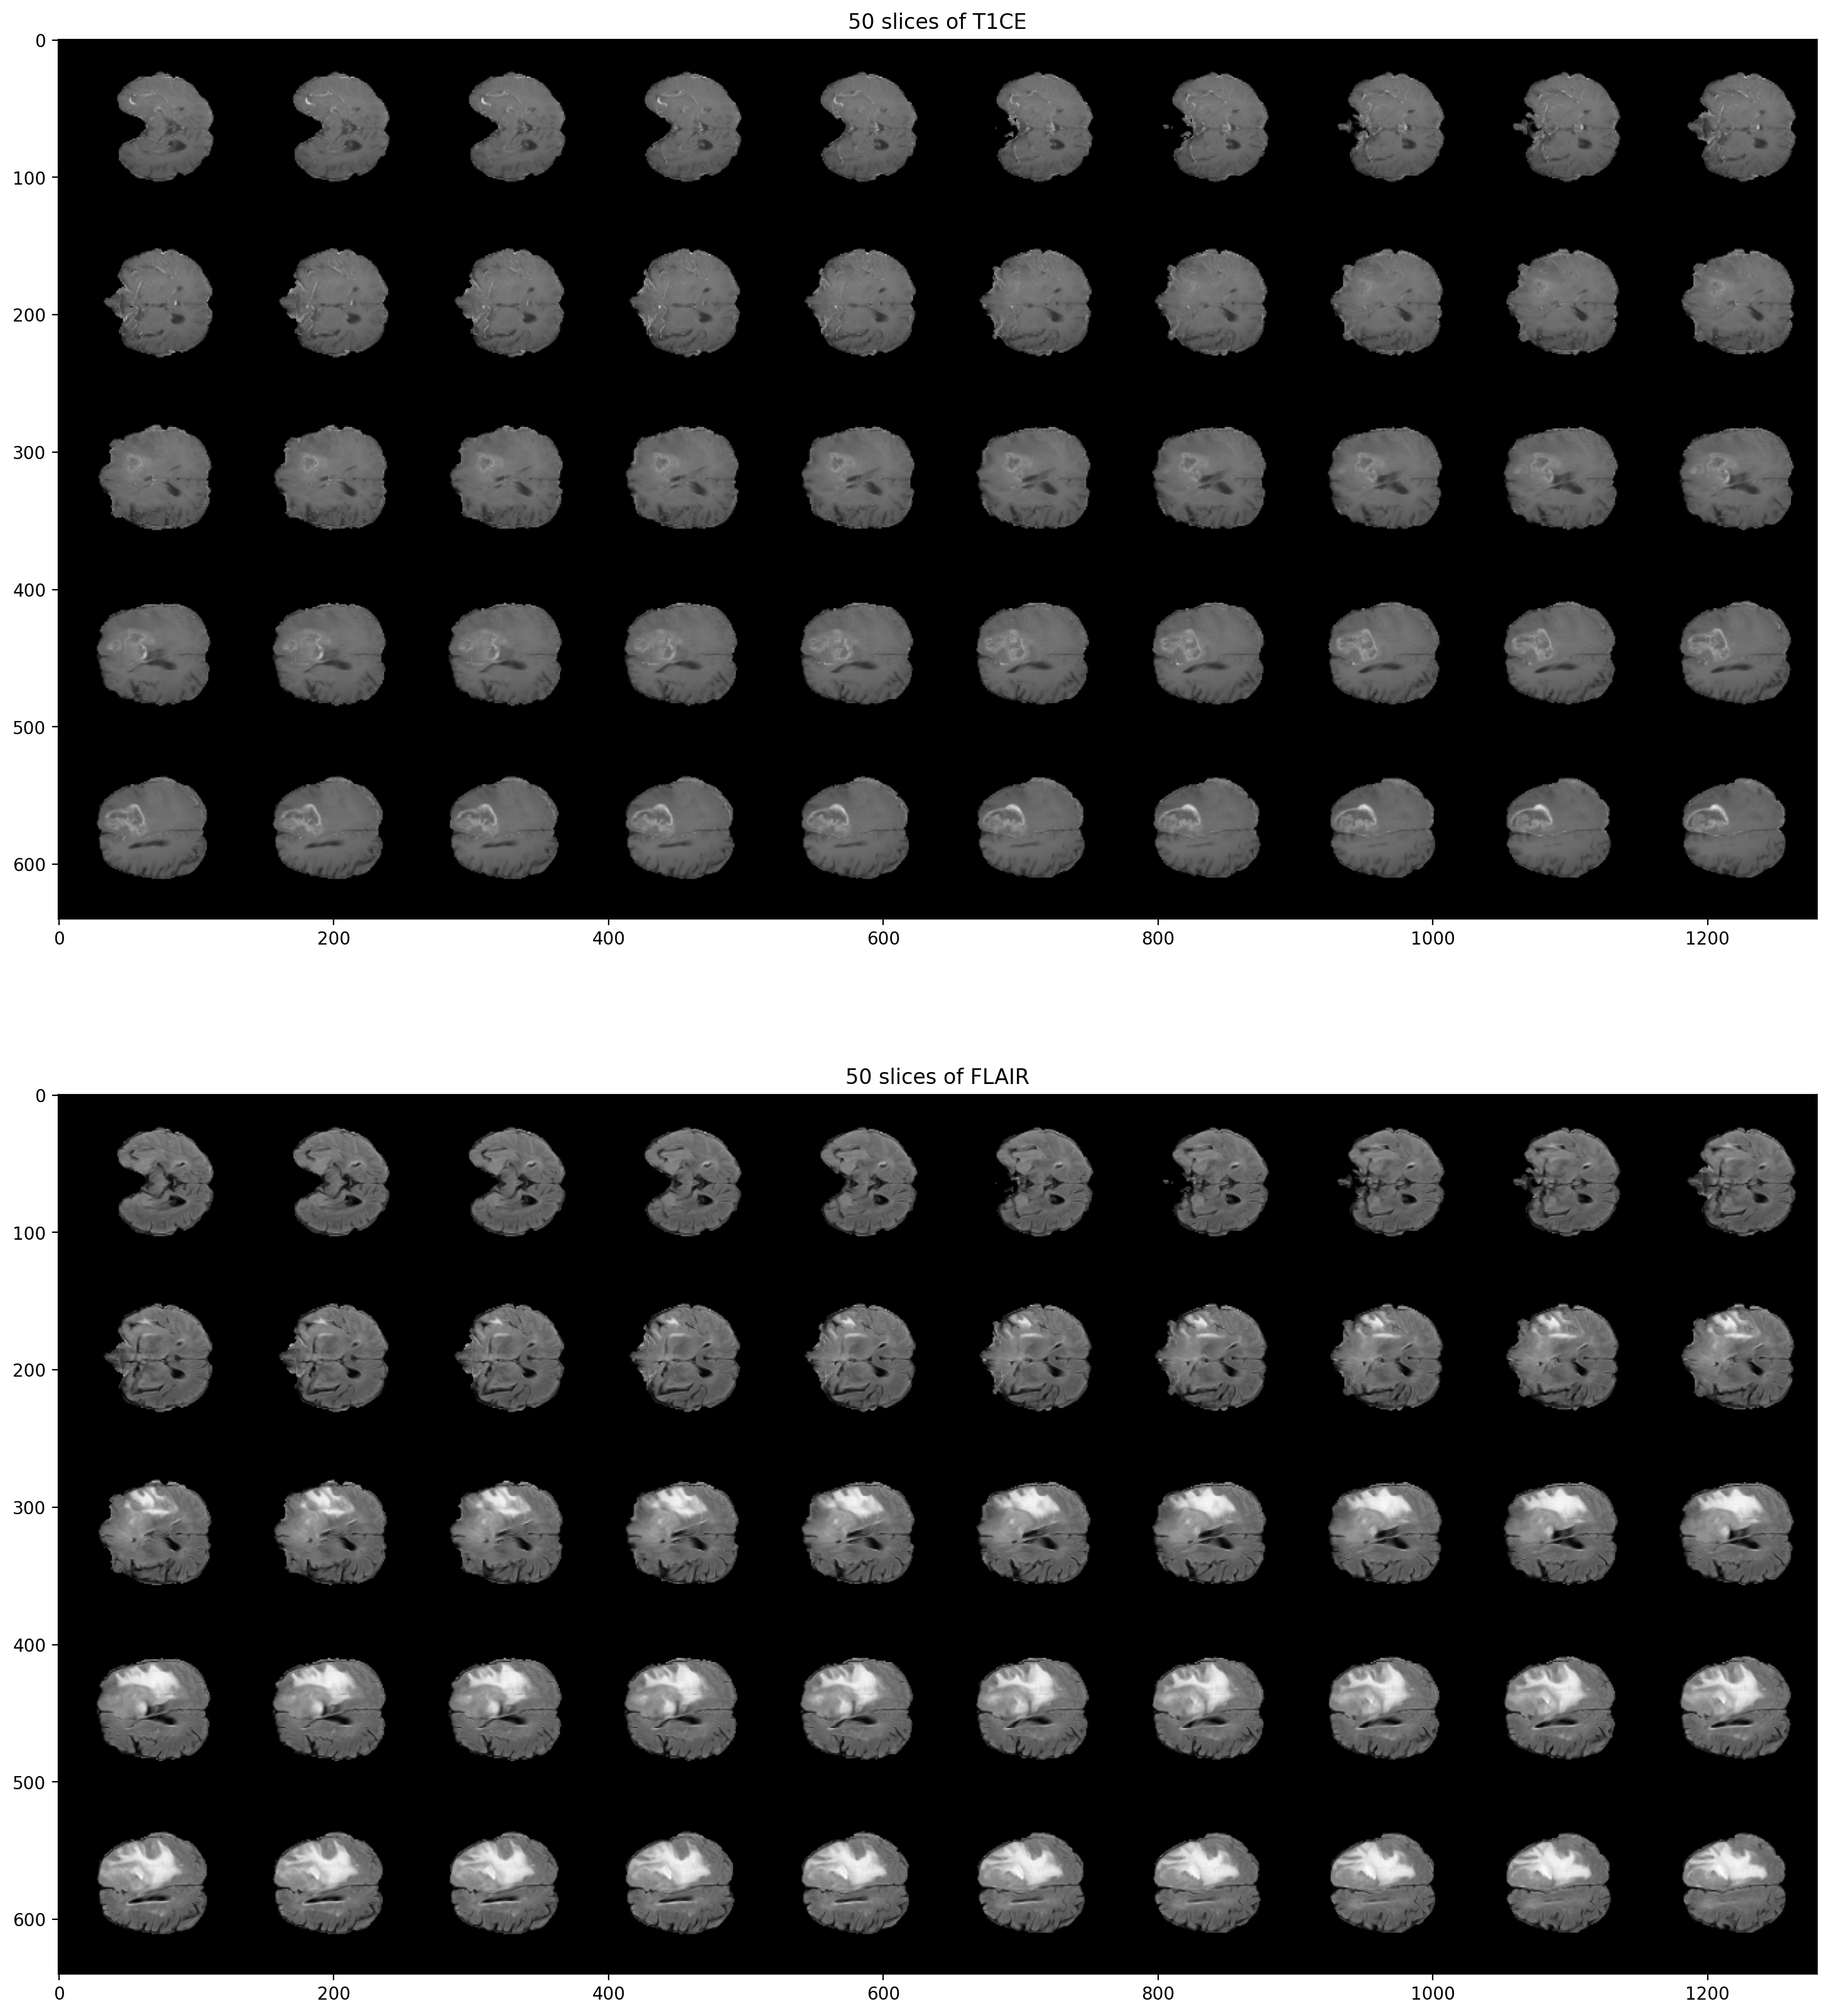

In [28]:
fig, axs = plt.subplots(2,1, figsize=(20,20))
axs[0].imshow(montage(train_X.squeeze(0).numpy()[:,0,:,:], grid_shape=(5,10)), cmap='gray')
axs[0].set_title('50 slices of T1CE')
axs[1].imshow(montage(train_X.squeeze(0).numpy()[:,1,:,:], grid_shape=(5,10)), cmap='gray')
axs[1].set_title('50 slices of FLAIR')
plt.show()

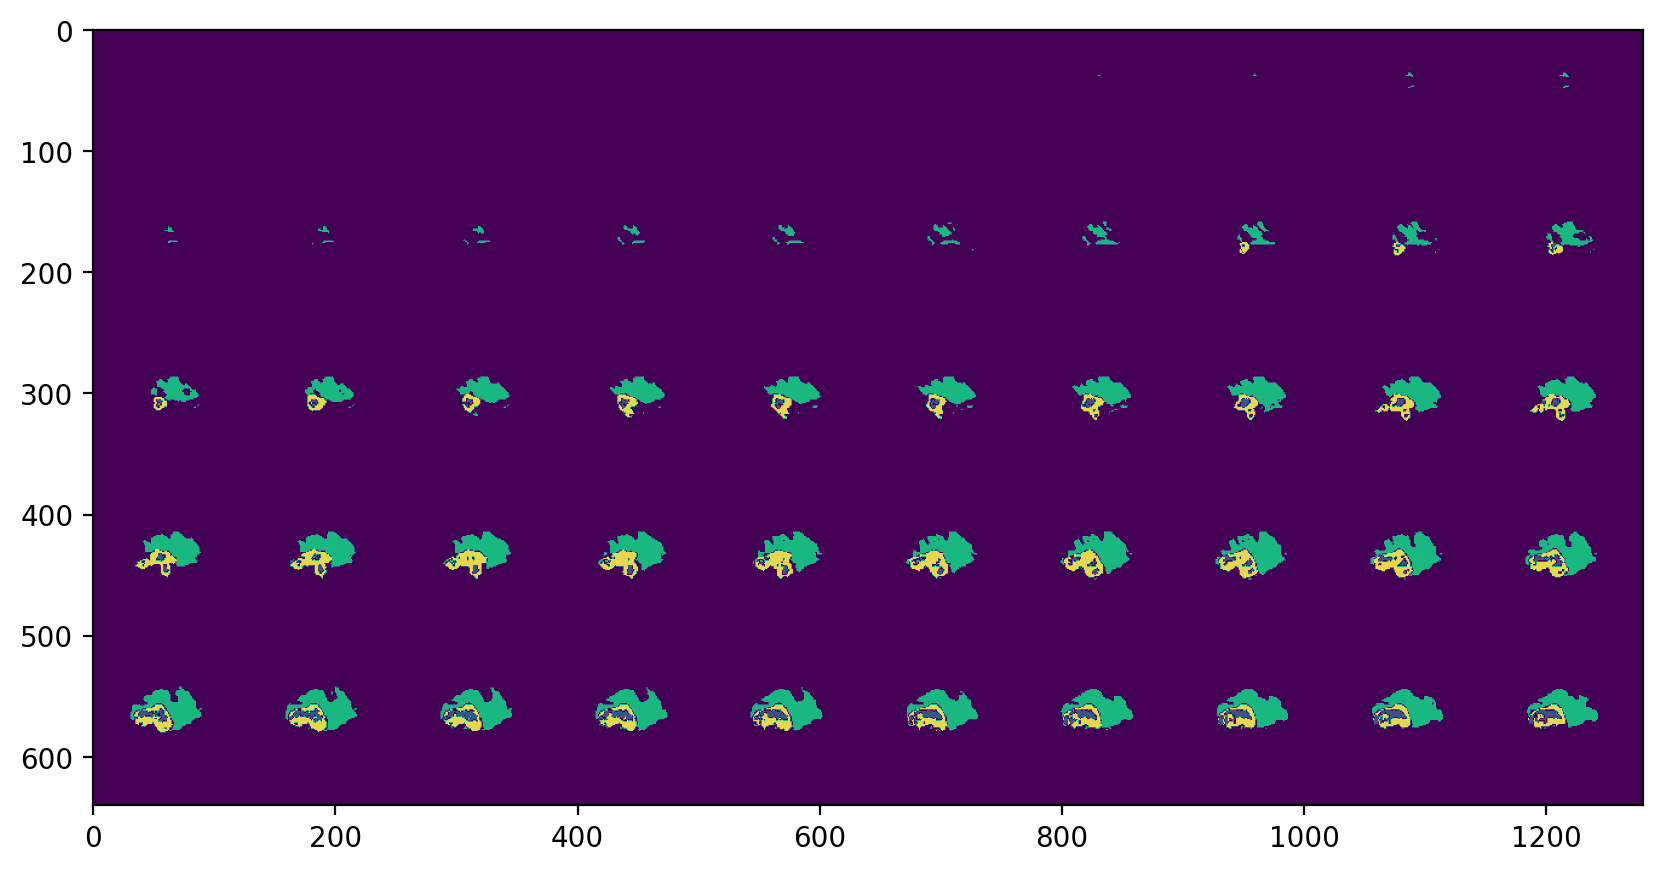

In [29]:
fig, axs = plt.subplots(1,1, figsize=(10,10))
train_y_mod = np.argmax(train_y.squeeze(0).numpy(), axis=1)
axs.imshow(montage(train_y_mod, grid_shape=(5,10)), cmap=cmap, norm=norm)
plt.show()

# Validation and Visualization

In [30]:
cmap = mpl.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

# Define the validation and testing functions
def validate(model, loader, criterion, device):
    model.eval()
    val_loss = 0.0
    dice_all = 0.0
    dice_each = np.zeros(4)
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            labels = labels.squeeze(0)
            labels_float = labels.float()
            
            loss = criterion(outputs, labels_float)
            val_loss += loss.item()
            
            avg_dice, class_dice = DiceScore(outputs, labels_float)
            dice_all += avg_dice
            dice_each += class_dice

    avg_val_loss = val_loss / len(loader)
    avg_dice_all = dice_all / len(loader)
    avg_dice_each = dice_each / len(loader)
    return avg_val_loss, avg_dice_all, avg_dice_each

def visualize_predictions(model, loader, device, num_ex=1, slice_idx=0):
    model.eval()
    for i, (inputs, labels) in enumerate(loader):
        inputs, labels = inputs.to(device), labels.to(device)
        labels = torch.squeeze(labels, dim=0)
    
        with torch.no_grad():
            outputs = model(inputs)
    
        #convert logits to probabilities
        outputs = torch.softmax(outputs - torch.max(outputs, dim=1, keepdim=True)[0], dim=1).cpu().numpy()
        outputs = np.argmax(outputs, axis=1)
        
        inputs = torch.squeeze(inputs, dim=0)
        inputs = inputs.cpu().numpy()
        
        labels = labels.cpu().numpy()
        labels = np.argmax(labels, axis=1)
    
        inputs_slice = inputs[slice_idx]
        labels_slice = labels[slice_idx] 
        outputs_slice = outputs[slice_idx]

        fig, axes = plt.subplots(1, 4, figsize=(15, 5))
        axes[0].imshow(inputs_slice[0], cmap='gray')  #first channel of slice
        axes[0].set_title('Input T1CE')
        axes[1].imshow(inputs_slice[1], cmap='gray')  #second channel of slice
        axes[1].set_title('Input FLAIR')
        axes[2].imshow(labels_slice, cmap=cmap, norm=norm)  # Show ground truth for slice
        axes[2].set_title('Ground Truth')
        axes[3].imshow(outputs_slice, cmap=cmap, norm=norm)  # Show model output for slice
        axes[3].set_title('Prediction')
    
        plt.show()
        if (i+1) == num_ex:
            break

def load_and_visualize(model_class, model_path, val_loader, device, num_ex=5, slice_indices=[15, 25, 35], train_loss_path=None, val_loss_path=None):
    """
    Parameters:
    - model_class: The class of the model to be instantiated.
    - model_path: Path to the model's state dictionary.
    - val_loader: DataLoader for the validation set.
    - device: The device to run the model on ('cuda' or 'cpu').
    - num_ex: Number of examples to visualize (default is 5).
    - slice_indices: List of slice indices to visualize (default is [15, 25, 35]).
    - train_loss_path: Path to the JSON file containing training loss data.
    - val_loss_path: Path to the JSON file containing validation loss data.
    """
    np.random.seed(20)
    torch.manual_seed(20)
    # Instantiate the model
    model = model_class()
    
    # Load the model state dictionary
    model.load_state_dict(torch.load(model_path))
    
    model.eval()
    
    model.to(device)
    
    # Visualize predictions for each slice index
    for slice_idx in slice_indices:
        print(f"Visualizing slice index: {slice_idx}")
        visualize_predictions(model, val_loader, device, num_ex=num_ex, slice_idx=slice_idx)
    
        # Load training loss data
    with open(train_loss_path, 'r') as f:
        training_data = json.load(f)

        # Load validation loss data
    with open(val_loss_path, 'r') as f:
        val_data = json.load(f)

    # Generate epoch numbers based on the length of the lists
    epochs = list(range(1, len(training_data) + 1))

        # Plotting the data
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, training_data, label='Training Loss')
    plt.plot(epochs, val_data, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [31]:
def quick_visualize(model, val_loader, device, num_ex=5, slice_indices=[15, 25, 35]):
    """
    Parameters:
    - model_class: The class of the model to be instantiated.
    - model_path: Path to the model's state dictionary.
    - val_loader: DataLoader for the validation set.
    - device: The device to run the model on ('cuda' or 'cpu').
    - num_ex: Number of examples to visualize (default is 5).
    - slice_indices: List of slice indices to visualize (default is [15, 25, 35]).
    - train_loss_path: Path to the JSON file containing training loss data.
    - val_loss_path: Path to the JSON file containing validation loss data.
    """
    np.random.seed(20)
    torch.manual_seed(20)
    
    model.eval()
    
    model.to(device)
    
    # Visualize predictions for each slice index
    for slice_idx in slice_indices:
        print(f"Visualizing slice index: {slice_idx}")
        visualize_predictions(model, val_loader, device, num_ex=num_ex, slice_idx=slice_idx)

# Training Loop

In [32]:
def train(model, optimizer, criterion, scheduler=None, epochs=20, device='cpu'):
    '''Scheduler is a dictionary
    Ex: scheduler = {'fac': 0.8, 'pat': 10, 'thr': 1e-4, 'thr_mode': 'rel'}
    'thr_mode' can be either 'rel' or 'abs'
    '''
    torch.backends.cudnn.allow_tf32 = True
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic= False
    
    scaler = torch.cuda.amp.GradScaler()
    if scheduler is not None:
        if scheduler['type'] == 'plateau':
            sche = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',\
                factor=scheduler['fac'], patience=scheduler['pat'],\
                threshold=scheduler['thr'], threshold_mode=scheduler['thr_mode'])
            
        elif scheduler['type'] == 'step':
            sche = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler['size'], gamma=scheduler['gamma'])
            
        elif scheduler['type'] == 'multi':
            sche = optim.lr_scheduler.MultiStepLR(optimizer, milestones=scheduler['milestones'], gamma=scheduler['gamma'])
            
    train_losses = []
    val_losses = []
    s_list = []
    dice = []
    for e in range(epochs):
        c_t = time.time()
        model.train()
        train_loss = 0.0

        for i, (inputs, labels) in enumerate(train_loader):
            #labels shape is torch.Size([1, 40, 4, 128, 128])
            #output shape is torch.Size([40, 4, 128, 128])
            
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad(set_to_none=True)

            # Forward pass
            labels = labels.squeeze(0)
            labels_float = labels.float()
            with torch.autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(inputs)

                # Calculate loss
                loss = criterion(outputs, labels_float)

            scaler.scale(loss).backward()
            
            # Update weights
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.detach()

        avg_train_loss = train_loss.item() / len(train_loader)
        avg_val_loss, dice_all, dice_each = validate(model, val_loader, criterion, device)
    
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        if scheduler is not None:
            if scheduler['type'] == 'plateau':
                sche.step(avg_val_loss)
            elif scheduler['type'] == 'step':
                sche.step()
            elif scheduler['type'] == 'multi':
                sche.step()

        nl = '\n'
        tab = '\t'
        s1 = f'Epoch [{e+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Time elapsed: {time.time()-c_t:.3f}'
        s2 = f'{tab}Dice Score (Overall): {dice_all:.4f} {nl}{tab}Dice Score (Healthy/Background): {dice_each[0]:.4f} {nl}{tab}Dice Score (Necrotic): {dice_each[1]:.4f} {nl}{tab}Dice Score (Edema): {dice_each[2]:.4f} {nl}{tab}Dice Score (Enhancing): {dice_each[3]:.4f}'
        s_list.append(s1)
        s_list.append(s2)
        print(s1)
        print(s2)
        # print(f'{tab}LR: {sche.get_last_lr()}')

    return train_losses, val_losses, s_list, dice

# Training Start Here

- ## Use `BraTS_Data` if you only want T1CE and FLAIR, or `BraTS_Data_Test` if you want T2 also
- ## Available models: `UNET`, `R_UNET`, `PR_UNET`, `ResUNET` (use BatchNorm), `ResUNET_Test` (use InstanceNorm)
- ## Available loss functions: `FocalLoss`, `DiceLoss`, `FocalDice`, `FocalLossTest`
- ## Default alpha is `[0.25, 0.8, 0.8, 0.8]`
- ## Available schedulers:
    - ### Plateau: `scheduler = {'type': 'plateau', 'fac': #Value#, 'pat': #Value#, 'thr': #Value#, 'thr_mode': 'abs'}`
    - ### Step: `scheduler = {'type': 'step', 'gamma': #Value#, 'size': #Value#}`
    - ### MultiStep: `scheduler = {'type': 'multi', 'gamma': #Value#, 'milestones': [#Value1#, #Value2#, ...]}`

# Final Model

In [39]:
# Get image paths
train_path, val_path = train_test_split(sample_path, test_size=0.3, random_state=100)
val_path, test_path = train_test_split(val_path, test_size=0.33, random_state=100)

# Create train/validation/test dataset
START = 52
NUM_SLICE = 50

train_set = BraTS_Data(train_path, start=START, num_slice=NUM_SLICE)
val_set = BraTS_Data(val_path, start=START, num_slice=NUM_SLICE)
test_set = BraTS_Data(test_path, start=START, num_slice=NUM_SLICE)

# Create train/validation/test dataloader
train_loader = DataLoader(train_set, batch_size=1, shuffle=True, num_workers=16, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=True, num_workers=16, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=16, pin_memory=True)

In [40]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 200
model = PR_UNET(c=2, start_c=32)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = FocalDice(alpha=[0.2, 1.0, 1.0, 1.0], gamma=2, reduction='mean')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [47]:
# Train loop
scheduler = {'type': 'plateau', 'fac': 0.8, 'pat': 10, 'thr': 1e-4, 'thr_mode': 'abs'}
train_losses, val_losses, s_list, d = train(model, optimizer, criterion, scheduler=scheduler, epochs=num_epochs, device=device)

Epoch [1/200], Train Loss: 0.6695, Val Loss: 0.4894, Time elapsed: 13.789
	Dice Score (Overall): 0.6094 
	Dice Score (Healthy/Background): 0.9951 
	Dice Score (Necrotic): 0.2970 
	Dice Score (Edema): 0.7590 
	Dice Score (Enhancing): 0.7723
Epoch [2/200], Train Loss: 0.5384, Val Loss: 0.4814, Time elapsed: 13.623
	Dice Score (Overall): 0.6415 
	Dice Score (Healthy/Background): 0.9949 
	Dice Score (Necrotic): 0.3645 
	Dice Score (Edema): 0.7676 
	Dice Score (Enhancing): 0.7924
Epoch [3/200], Train Loss: 0.4820, Val Loss: 0.4146, Time elapsed: 13.978
	Dice Score (Overall): 0.7185 
	Dice Score (Healthy/Background): 0.9956 
	Dice Score (Necrotic): 0.5681 
	Dice Score (Edema): 0.7952 
	Dice Score (Enhancing): 0.7922
Epoch [4/200], Train Loss: 0.4552, Val Loss: 0.4432, Time elapsed: 13.661
	Dice Score (Overall): 0.7209 
	Dice Score (Healthy/Background): 0.9958 
	Dice Score (Necrotic): 0.5732 
	Dice Score (Edema): 0.7727 
	Dice Score (Enhancing): 0.8167
Epoch [5/200], Train Loss: 0.4225, Val L

In [42]:
# torch.save(model.state_dict(), './Files/final_model.pth')

# with open('./Files/loss_train_final_model.json', 'w') as f:
#     json.dump(train_losses, f)

# with open('./Files/loss_val_final_model.json', 'w') as f:
#     json.dump(val_losses, f)

# with open('./Files/dice_final_model.json', 'w') as f:
#     json.dump(d, f)

# with open('./Files/log_final_model.txt', 'w') as f:
#     f.write("\n".join(s_list))

# Visualizing Predictions

Visualizing slice index: 5


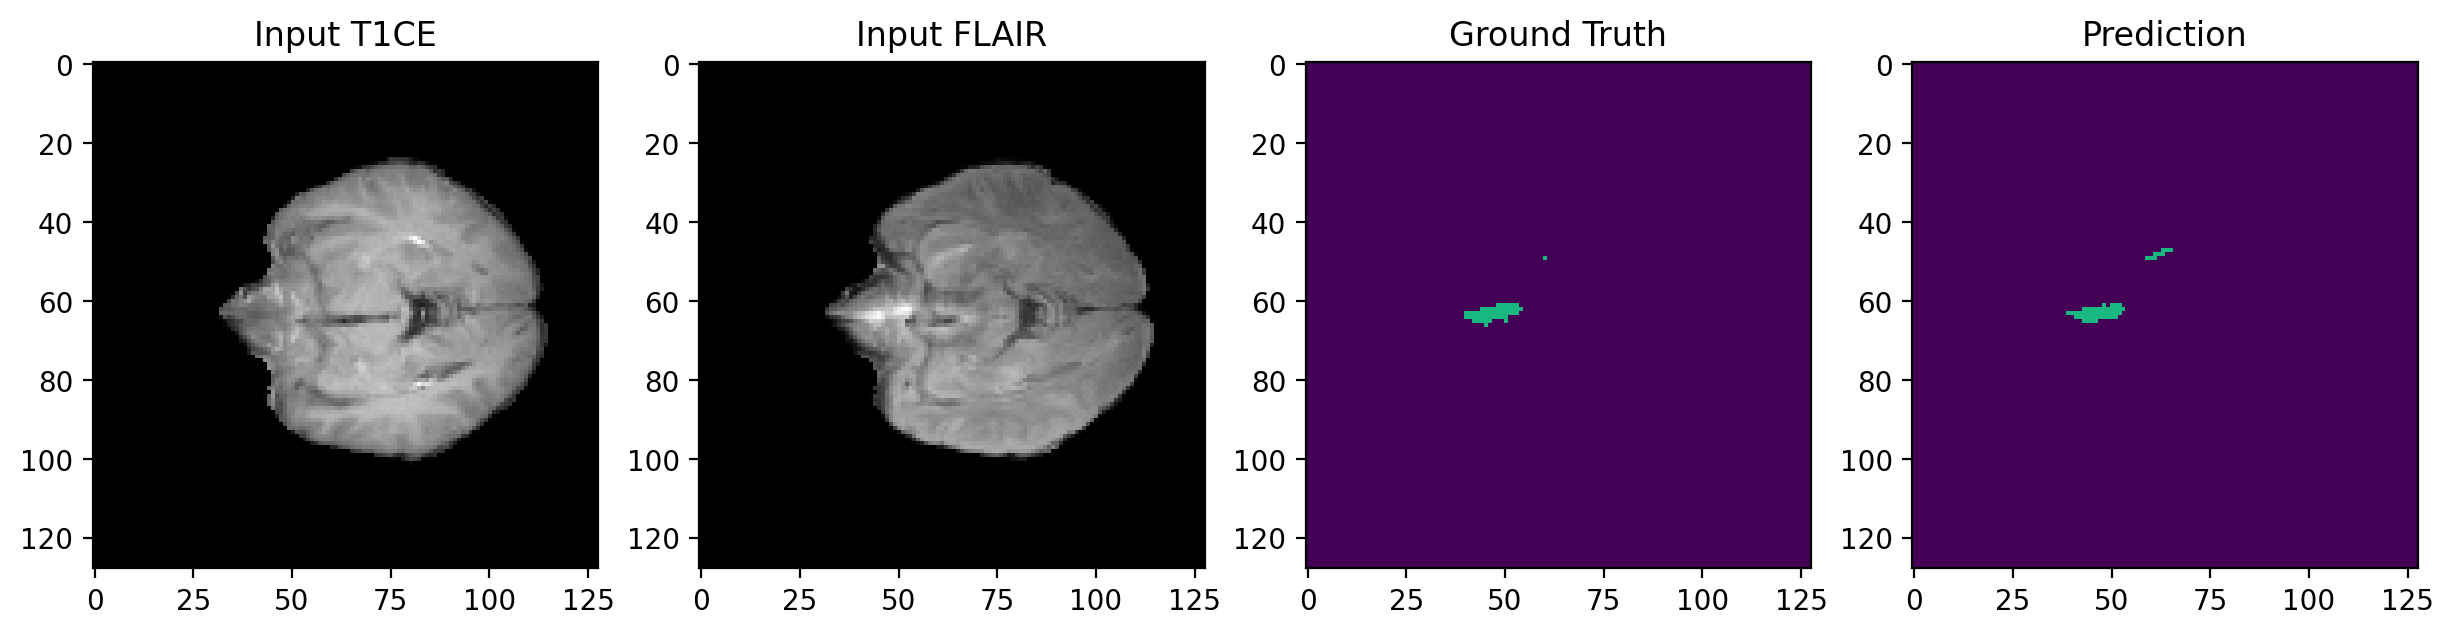

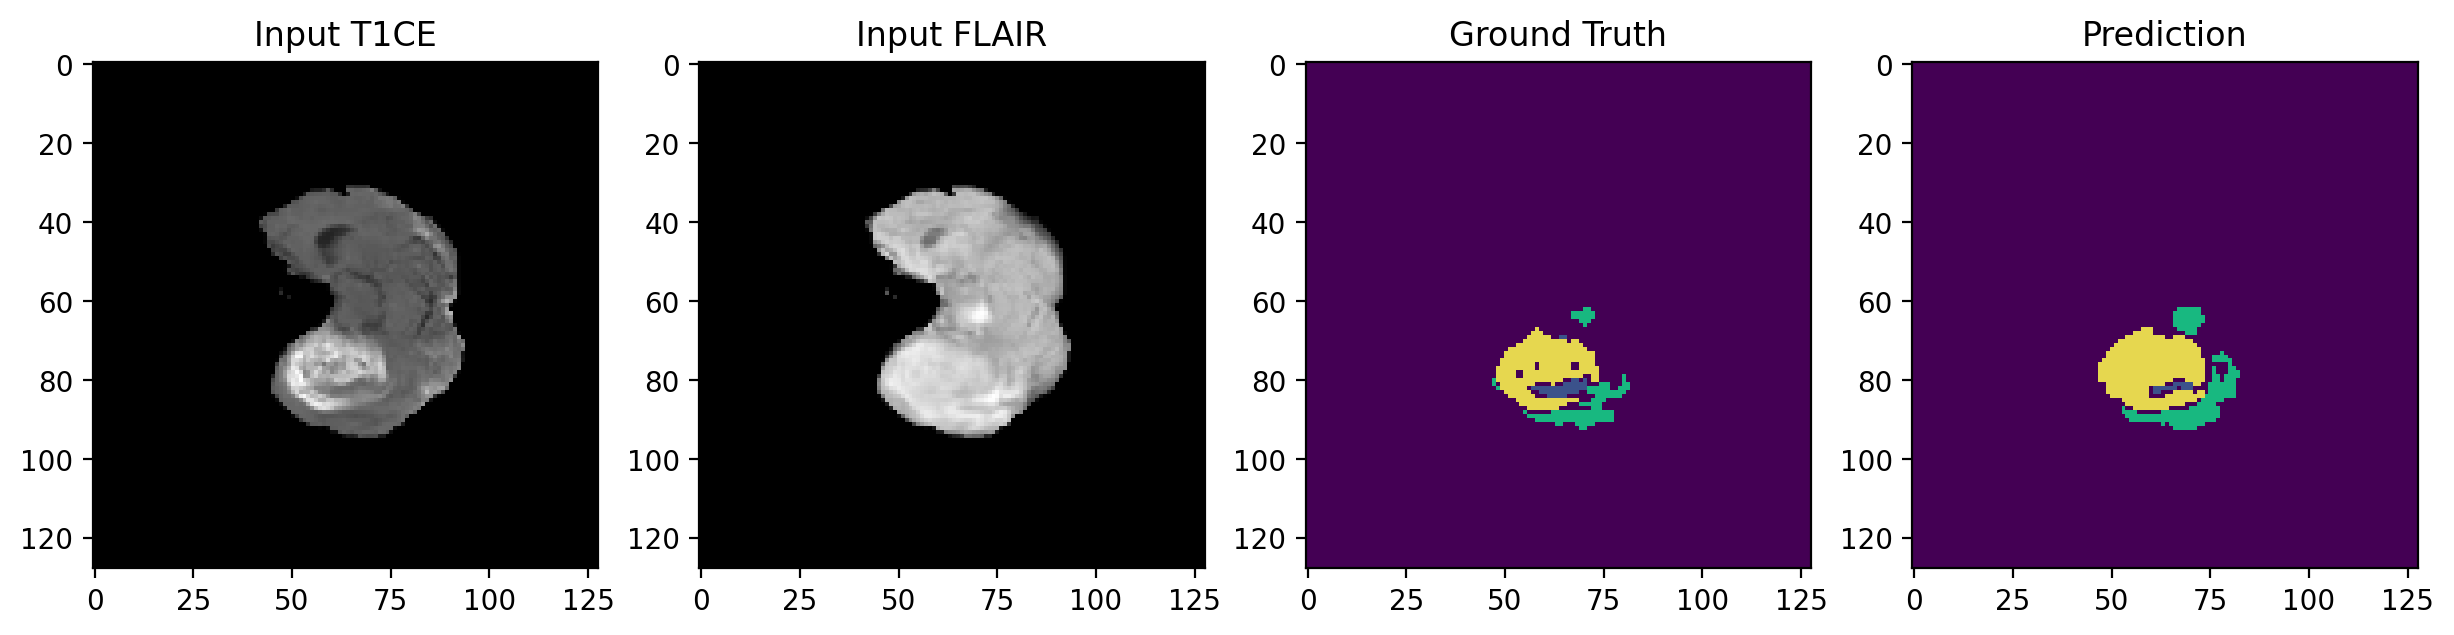

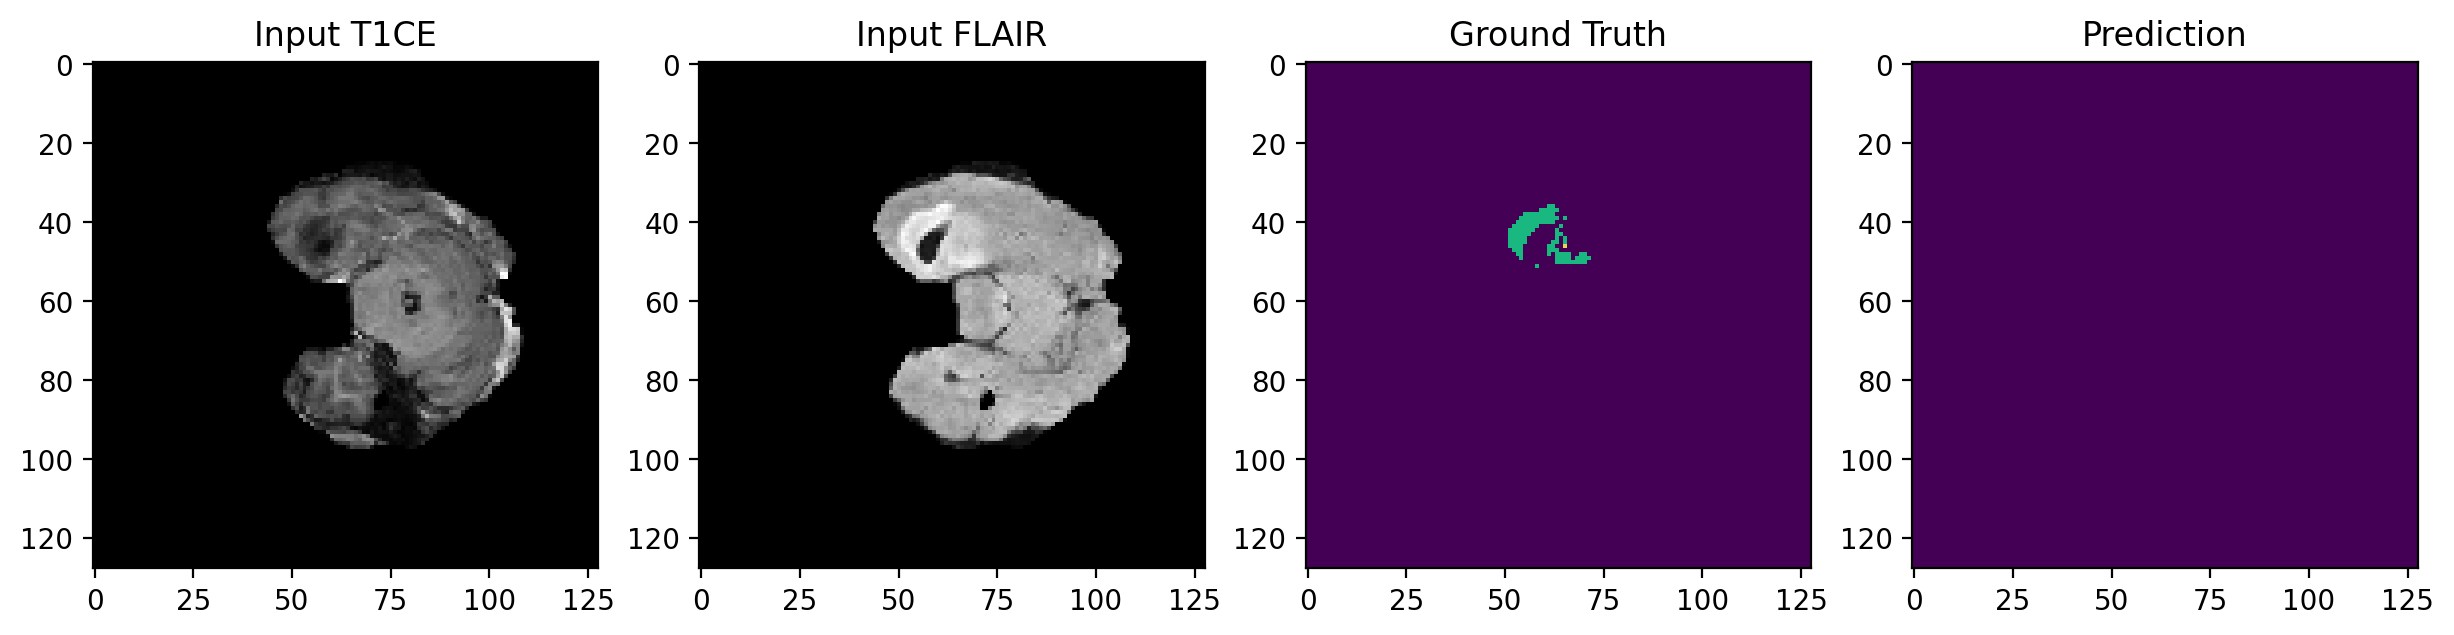

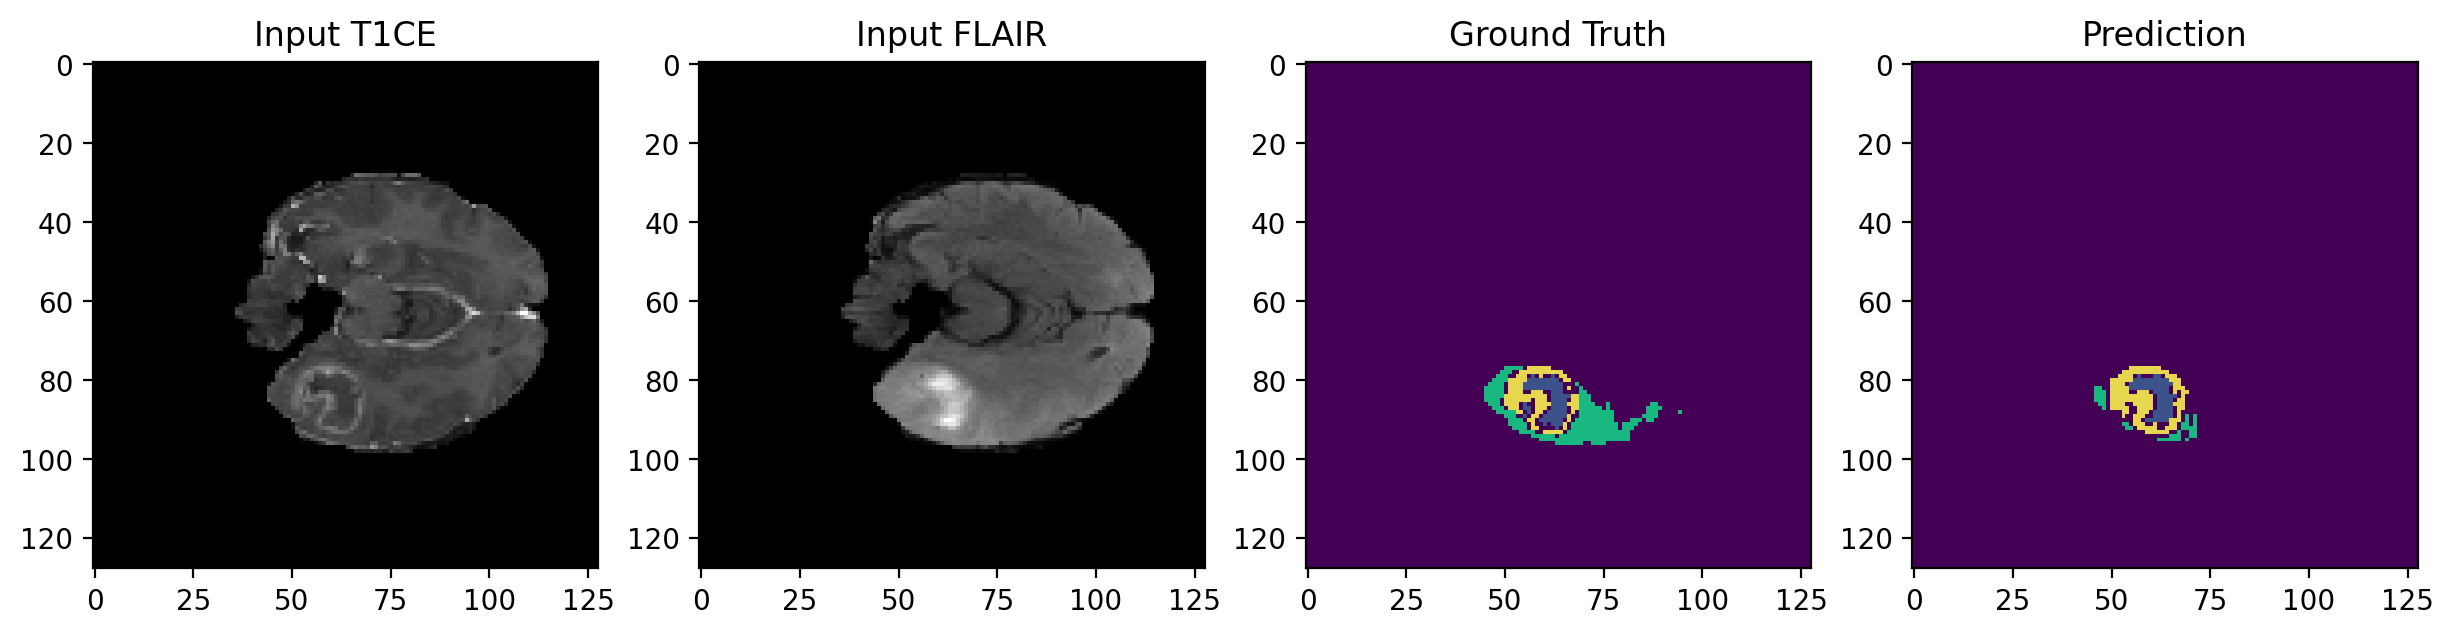

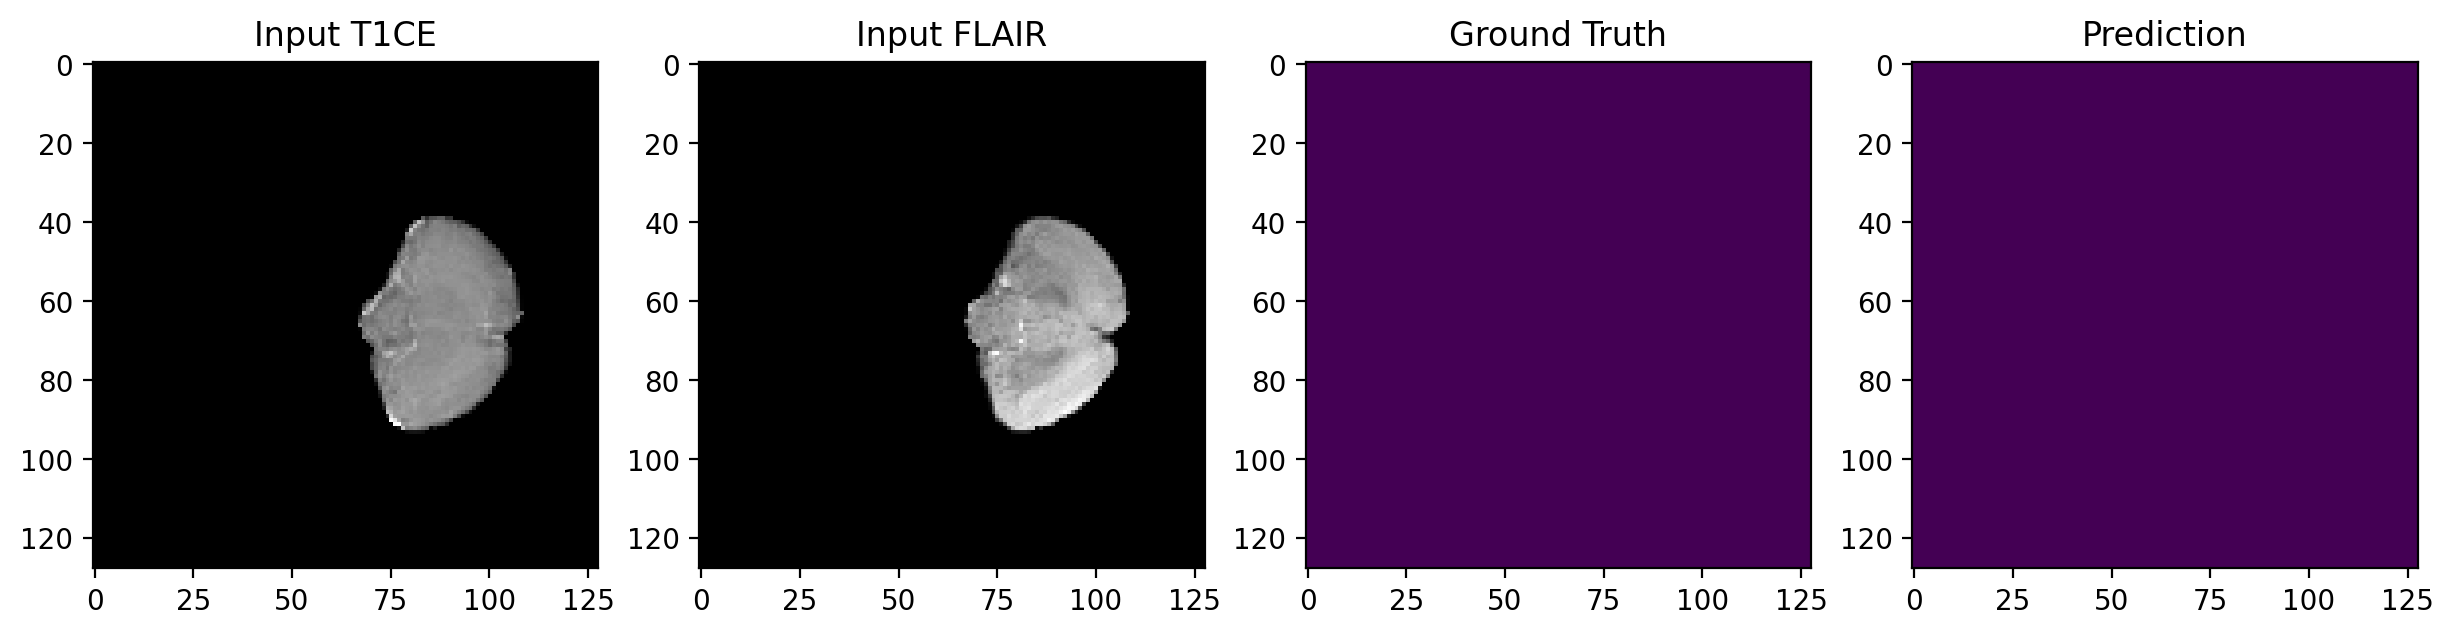

Visualizing slice index: 15


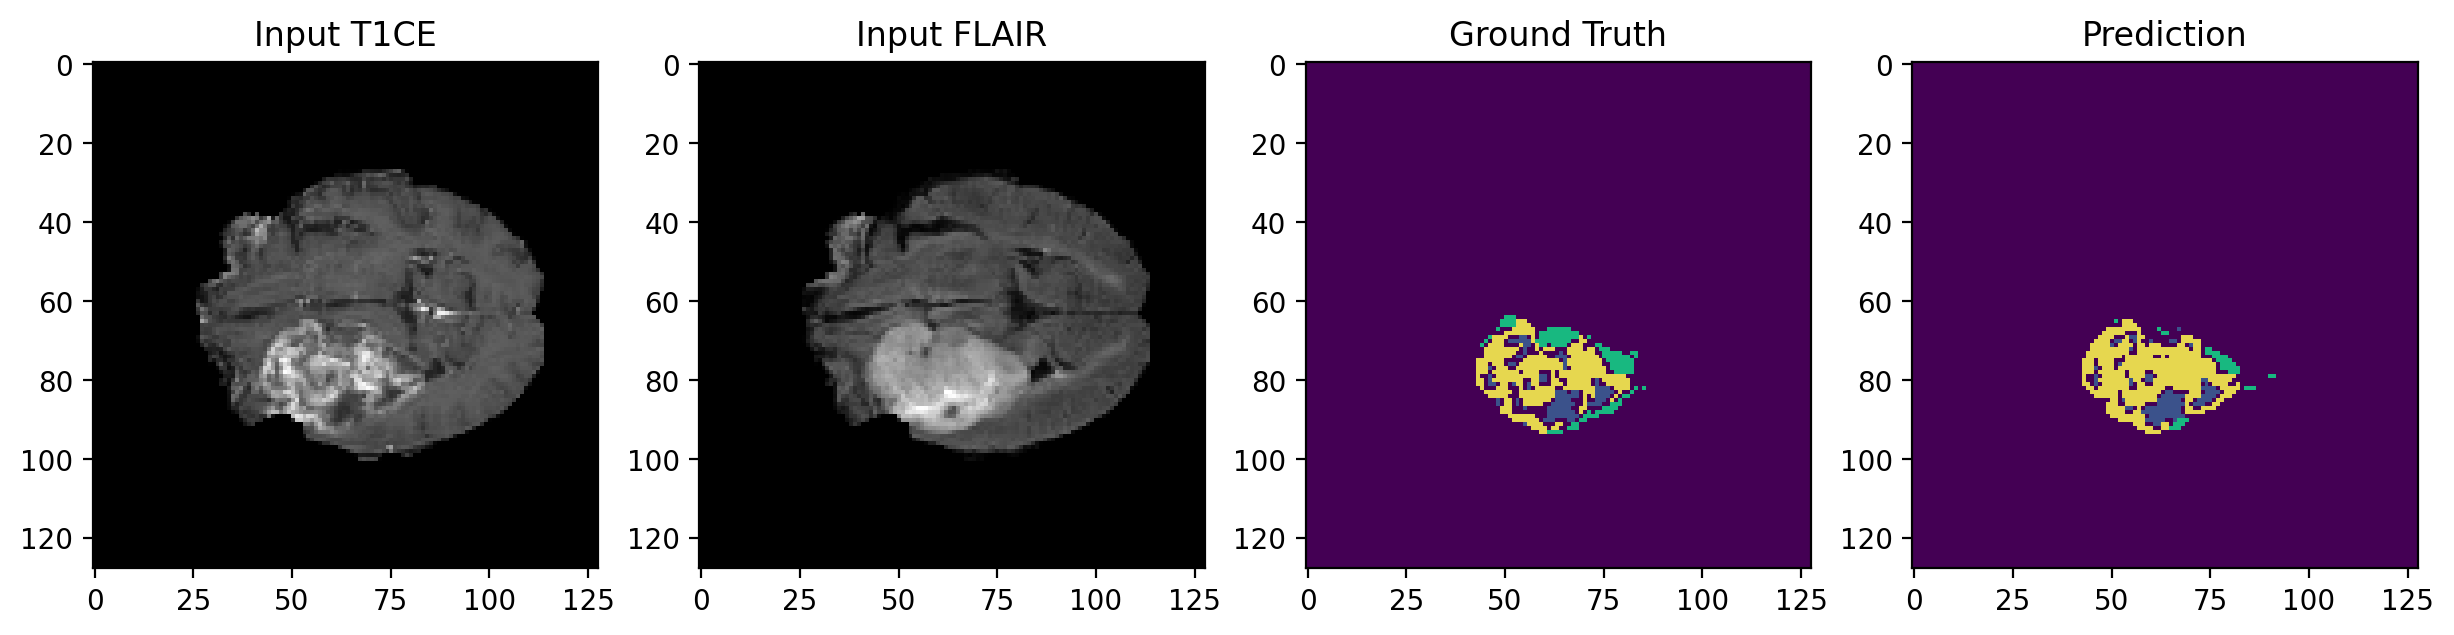

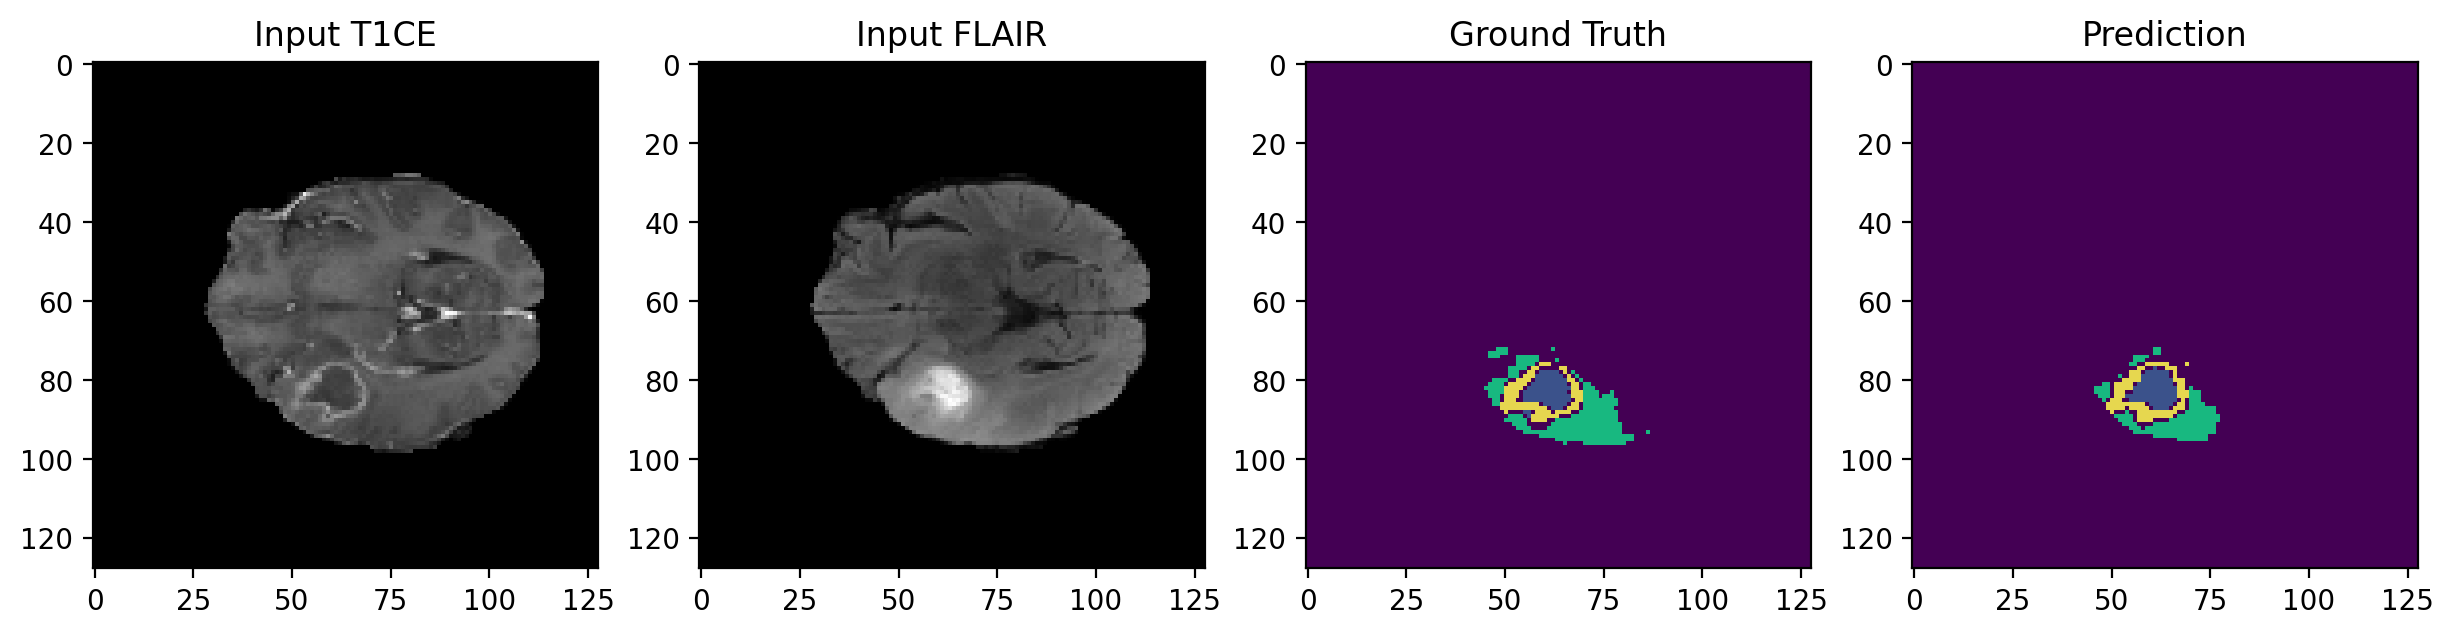

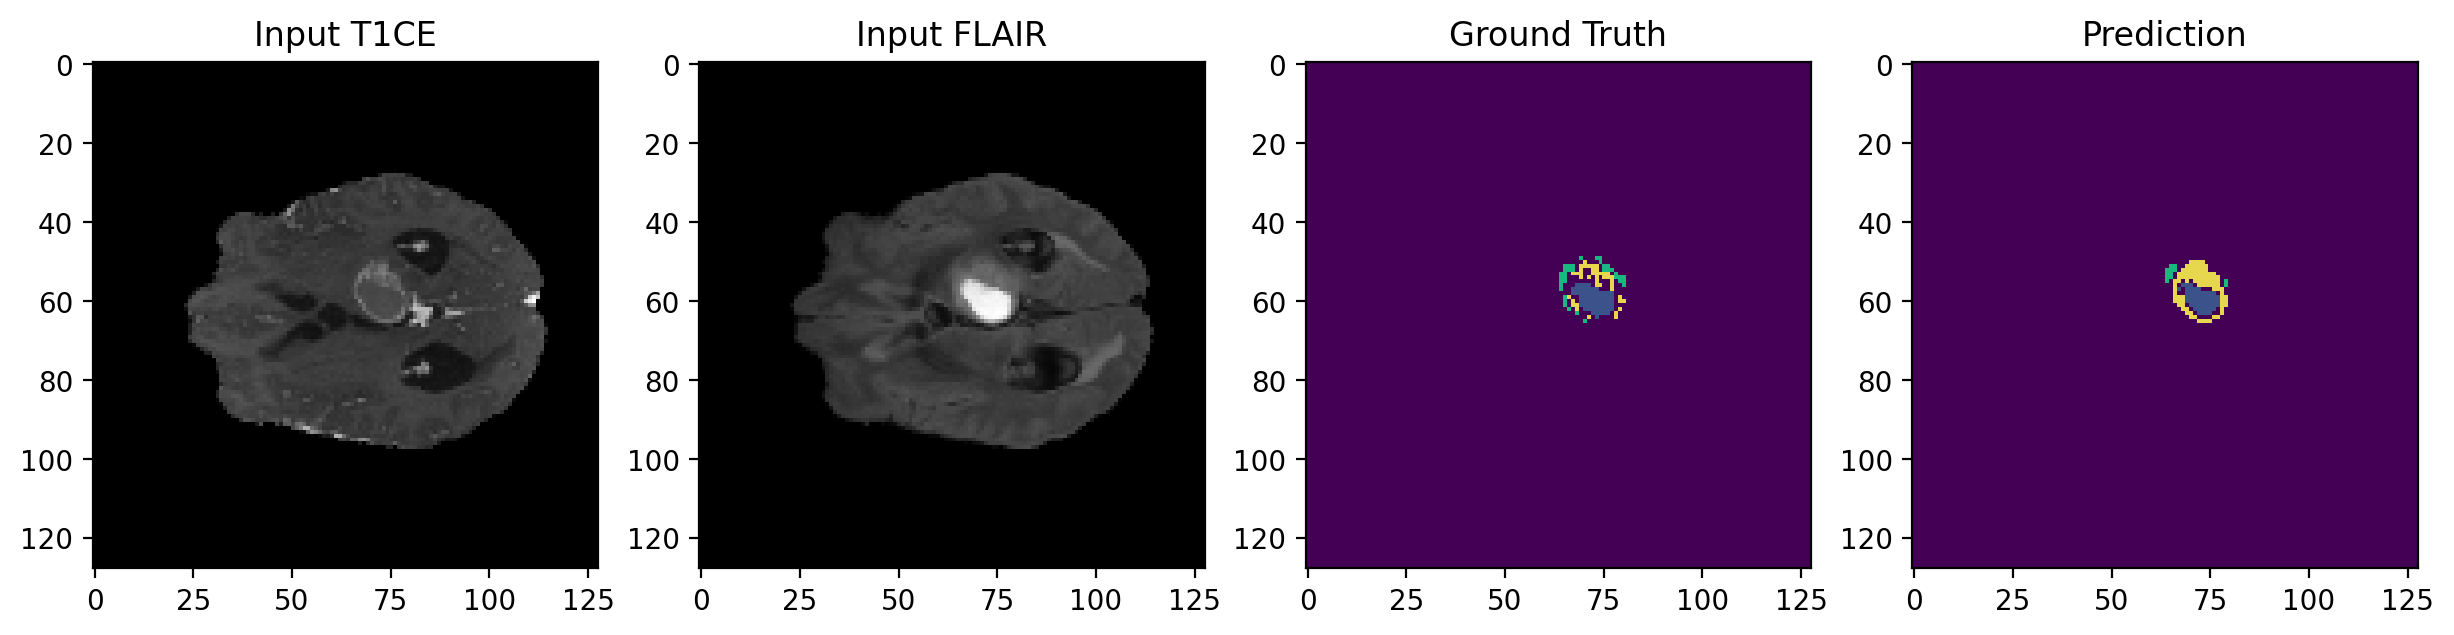

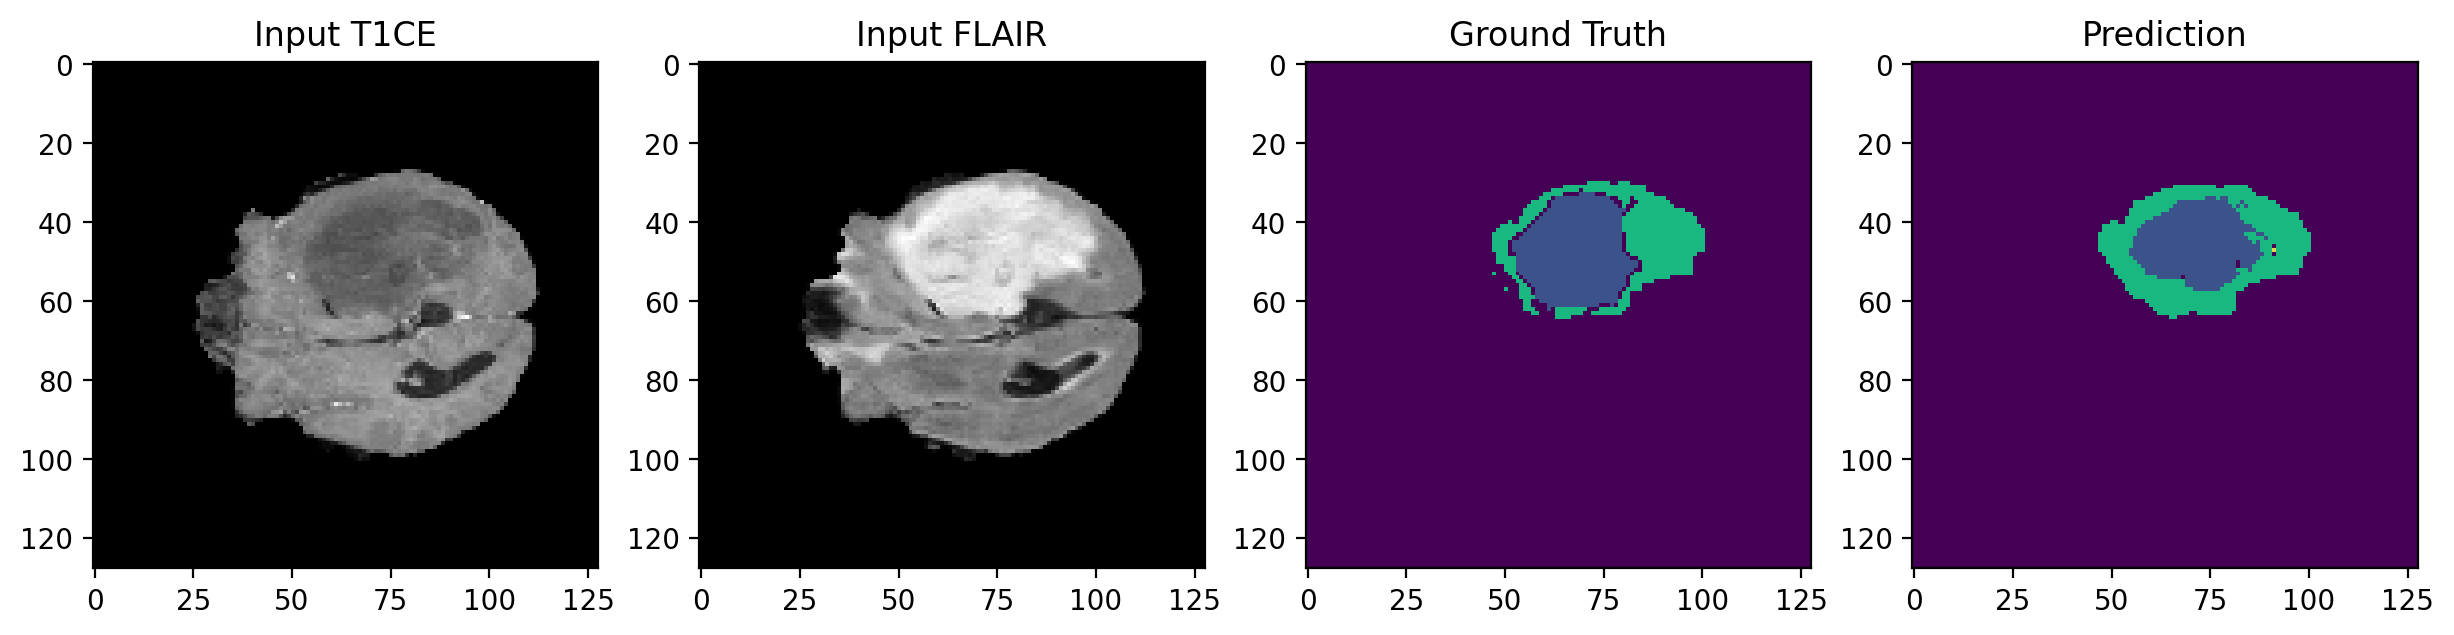

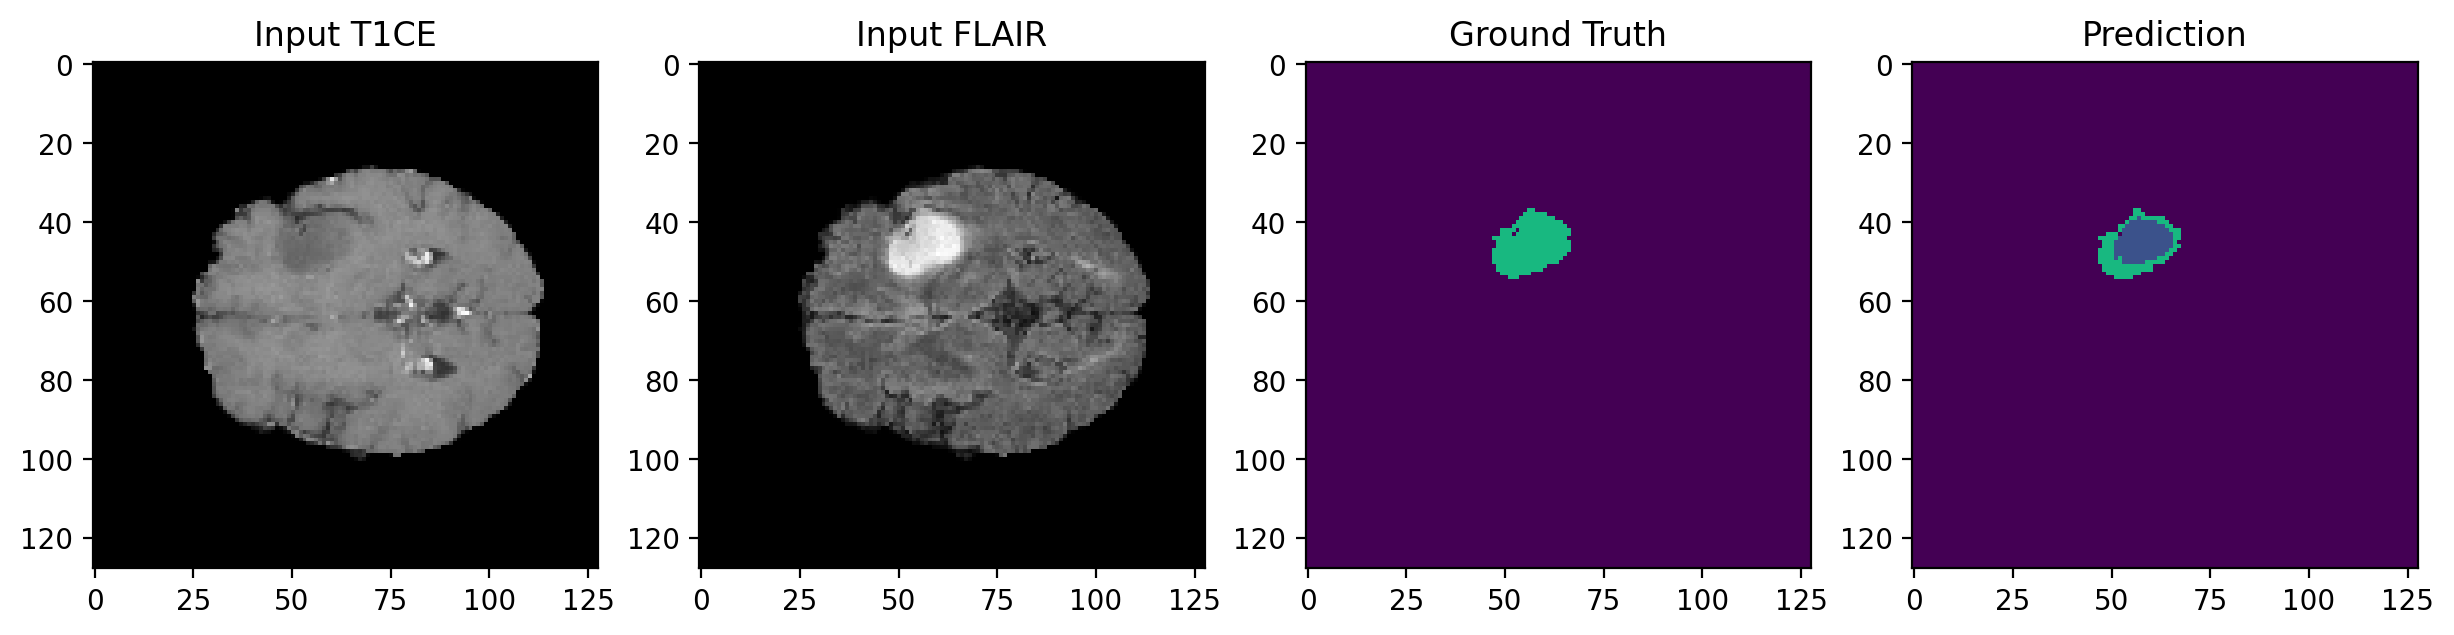

Visualizing slice index: 25


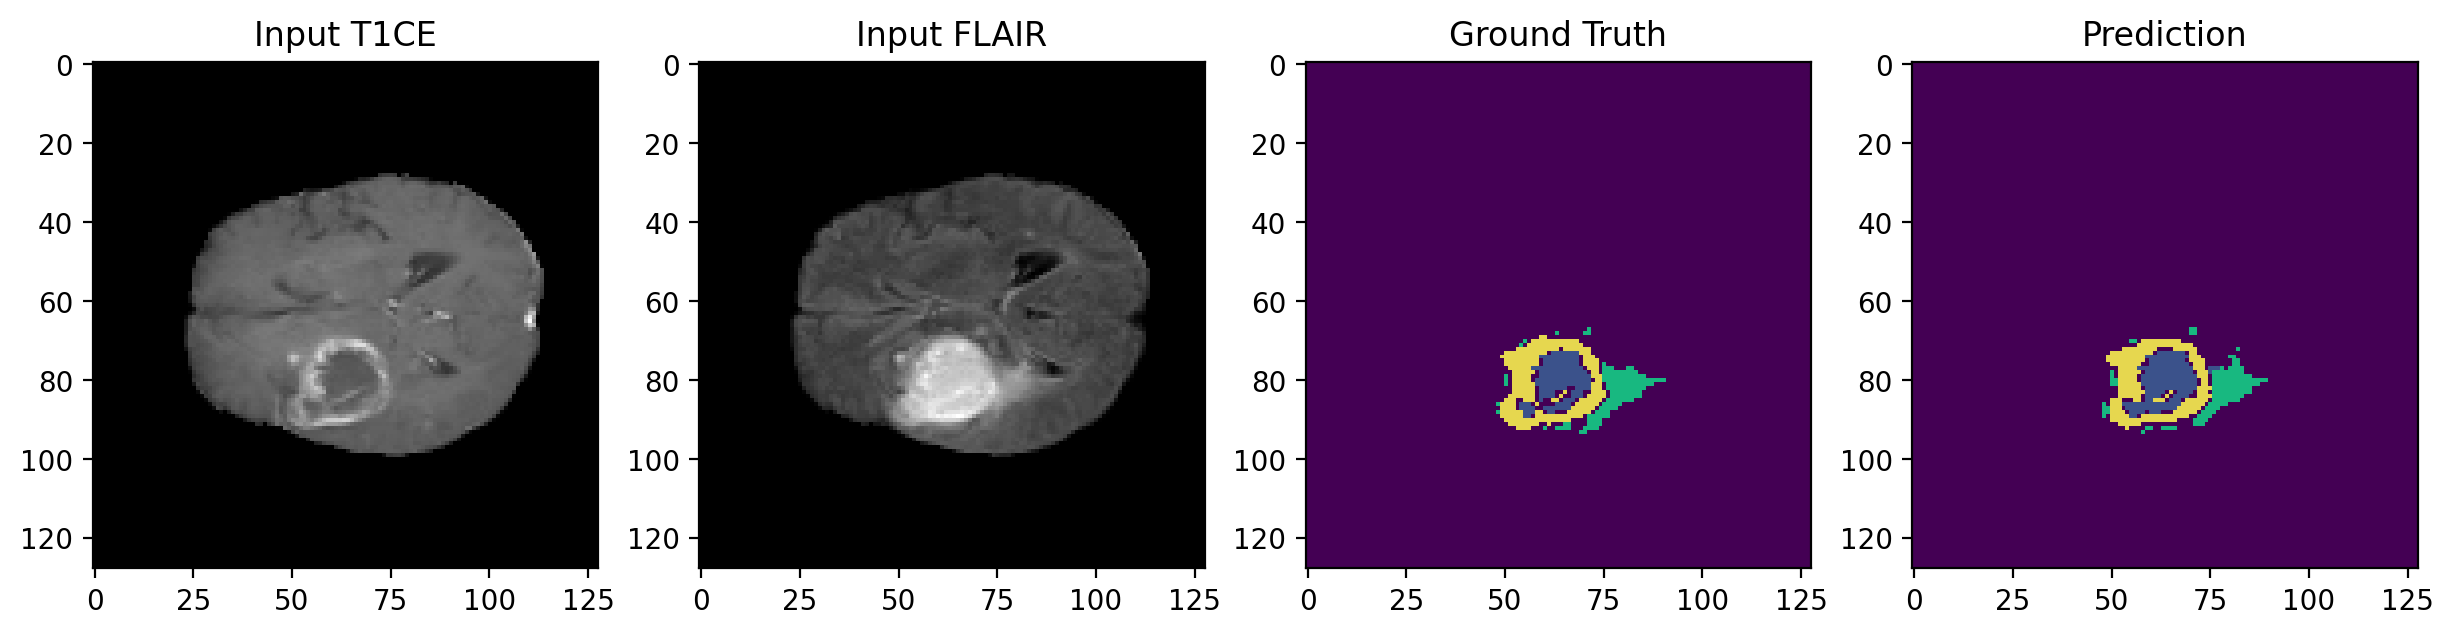

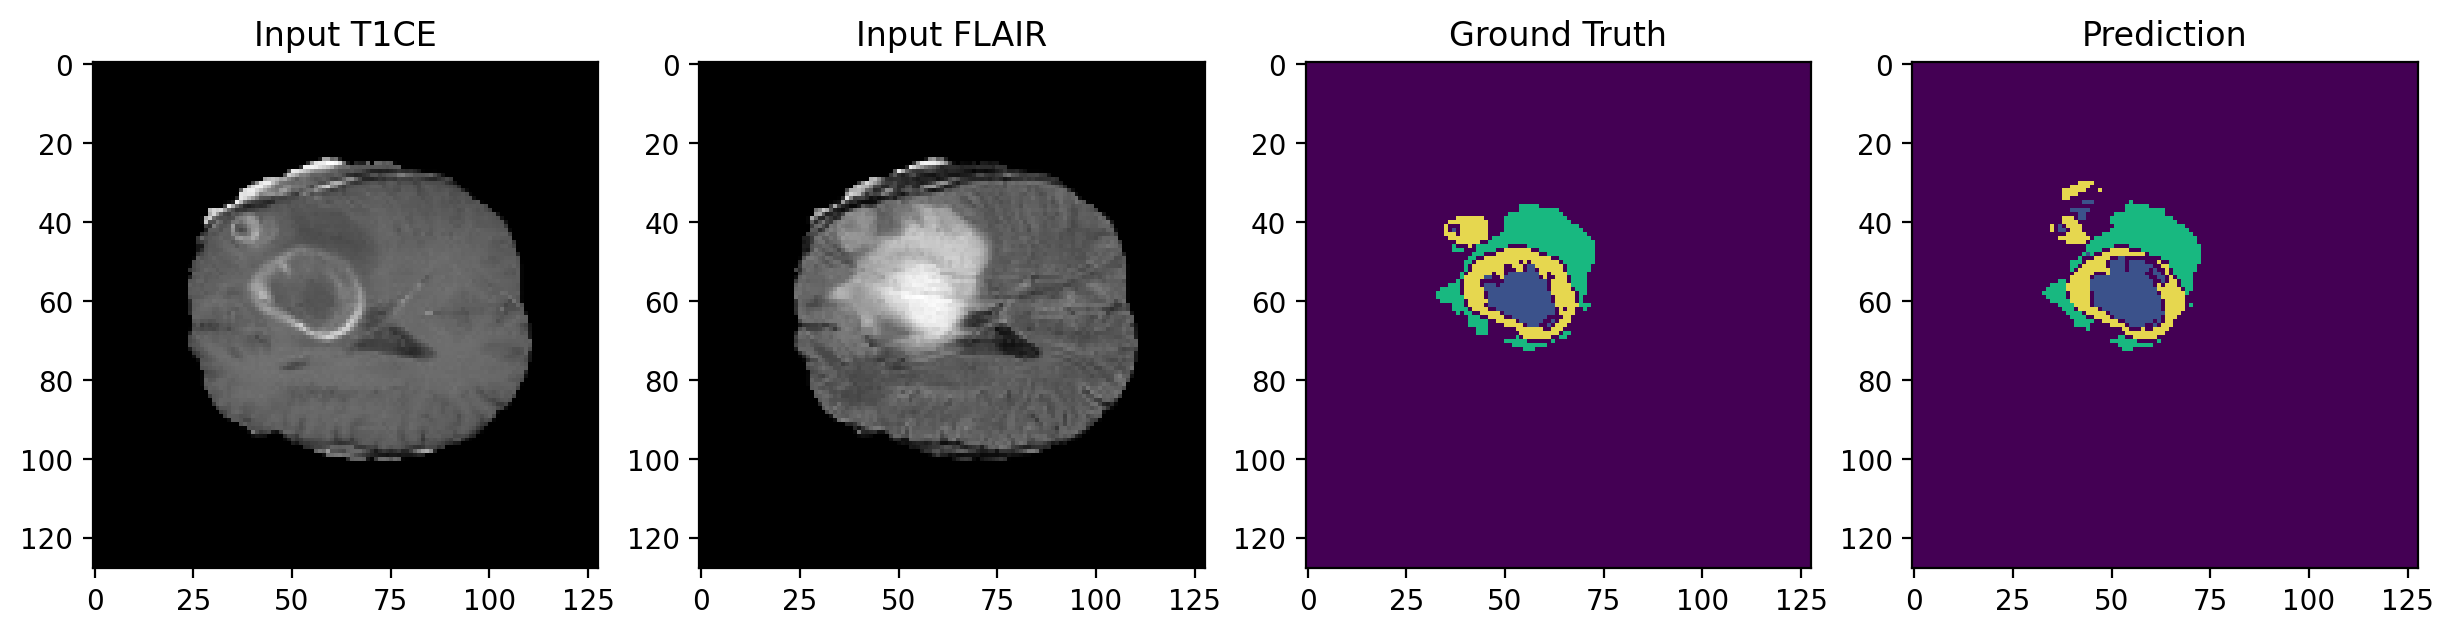

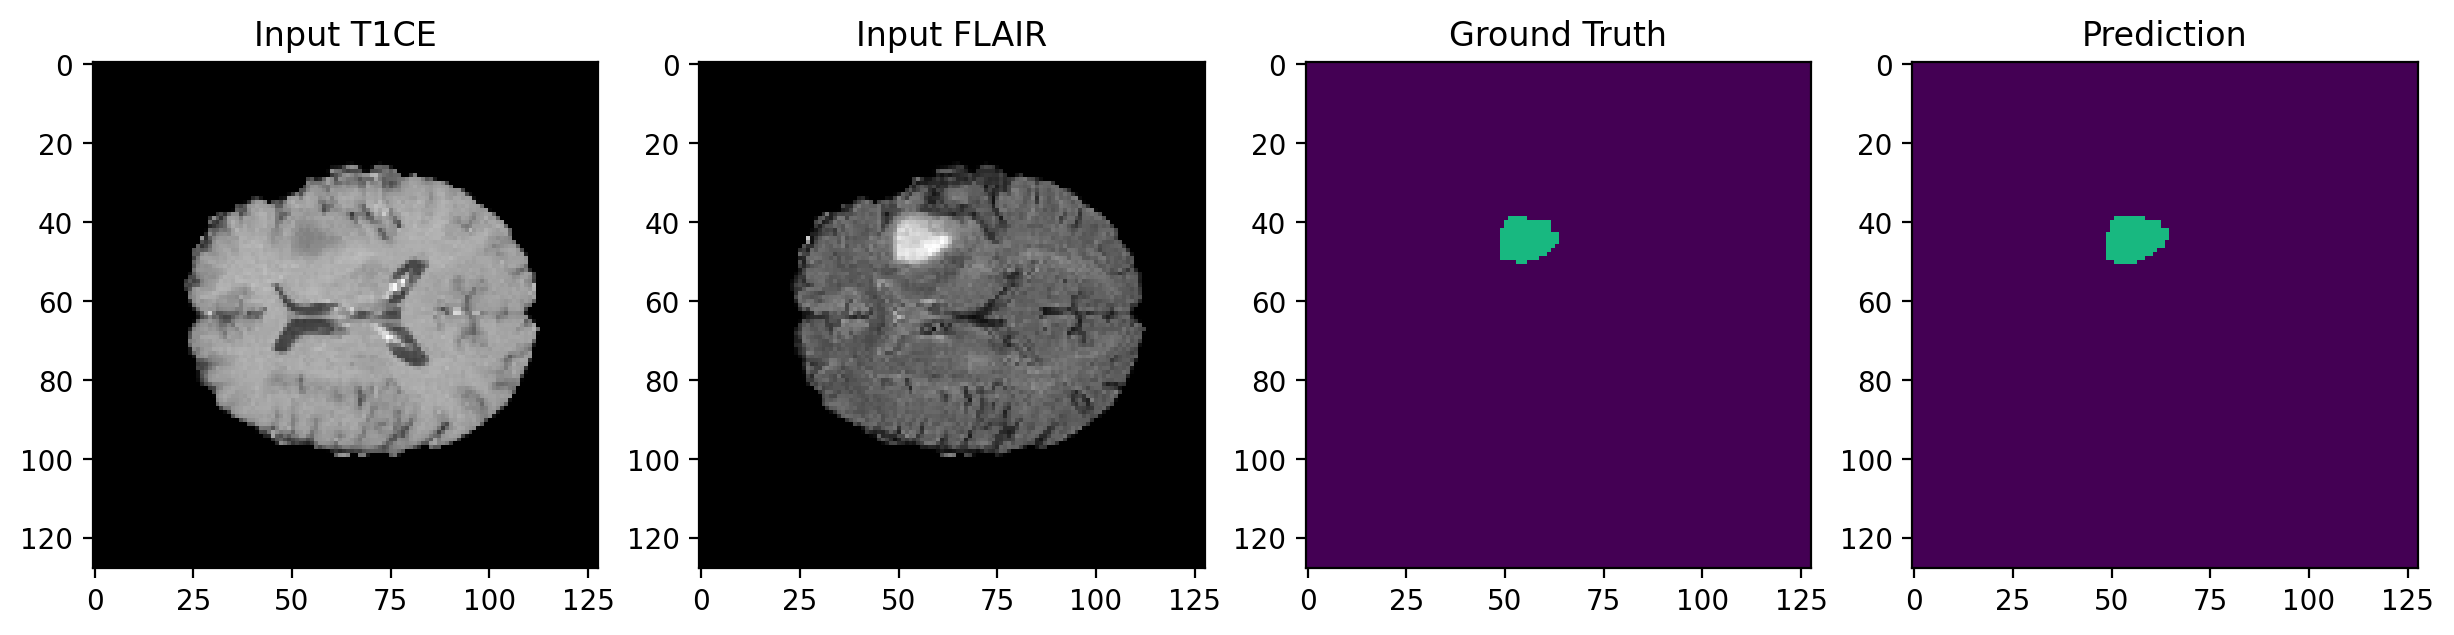

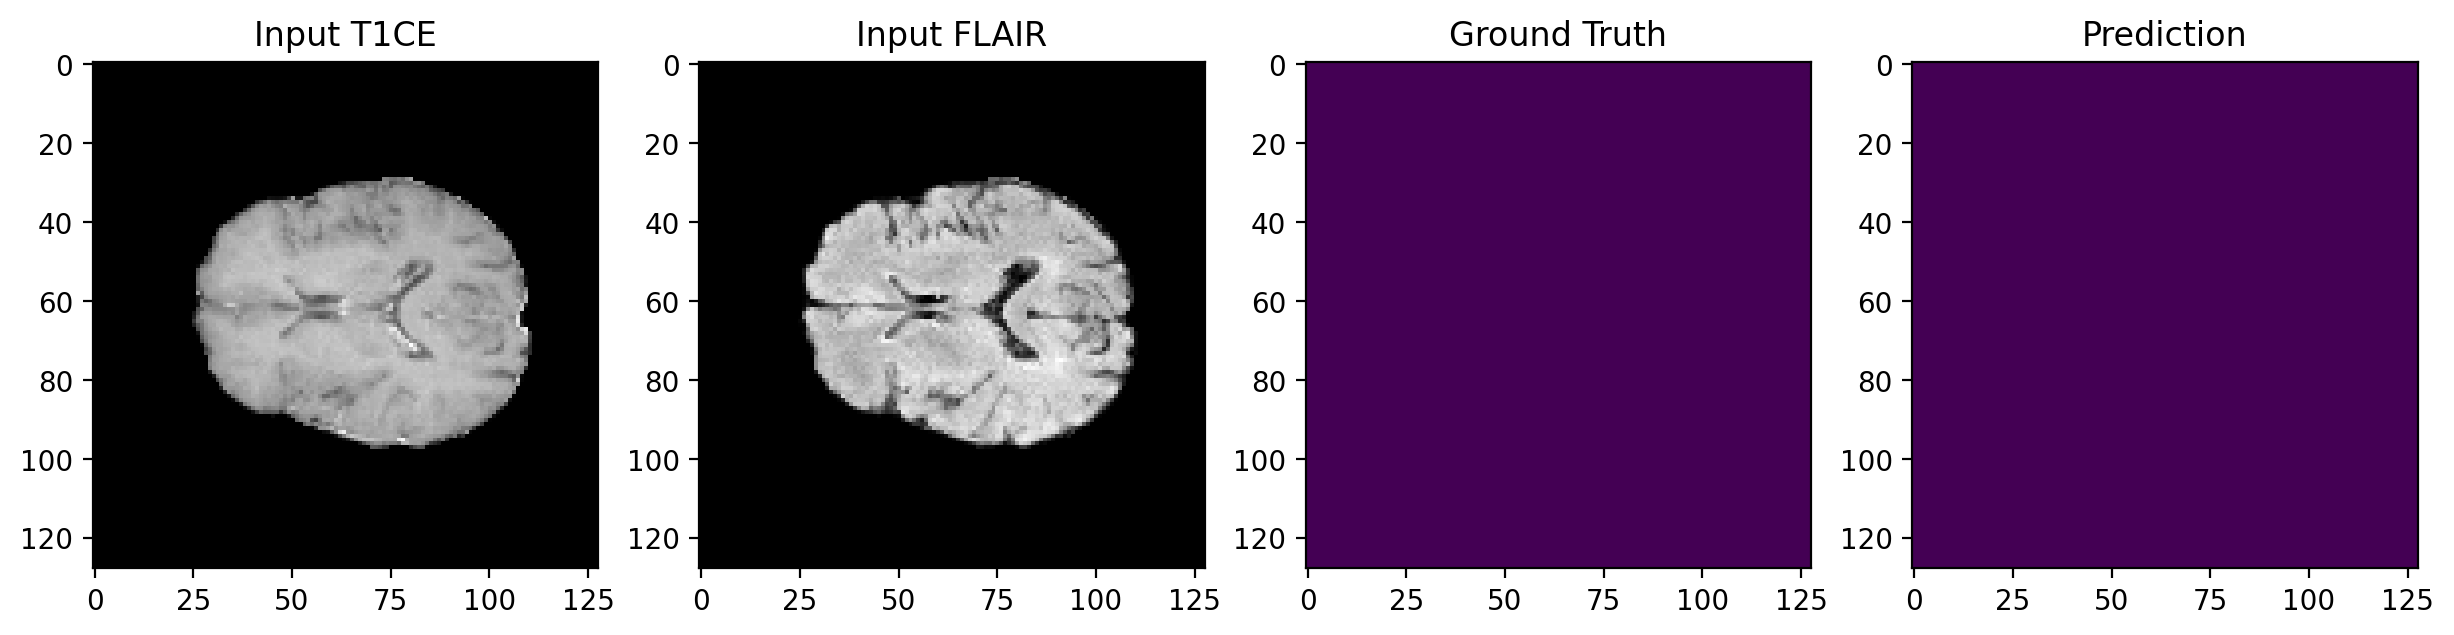

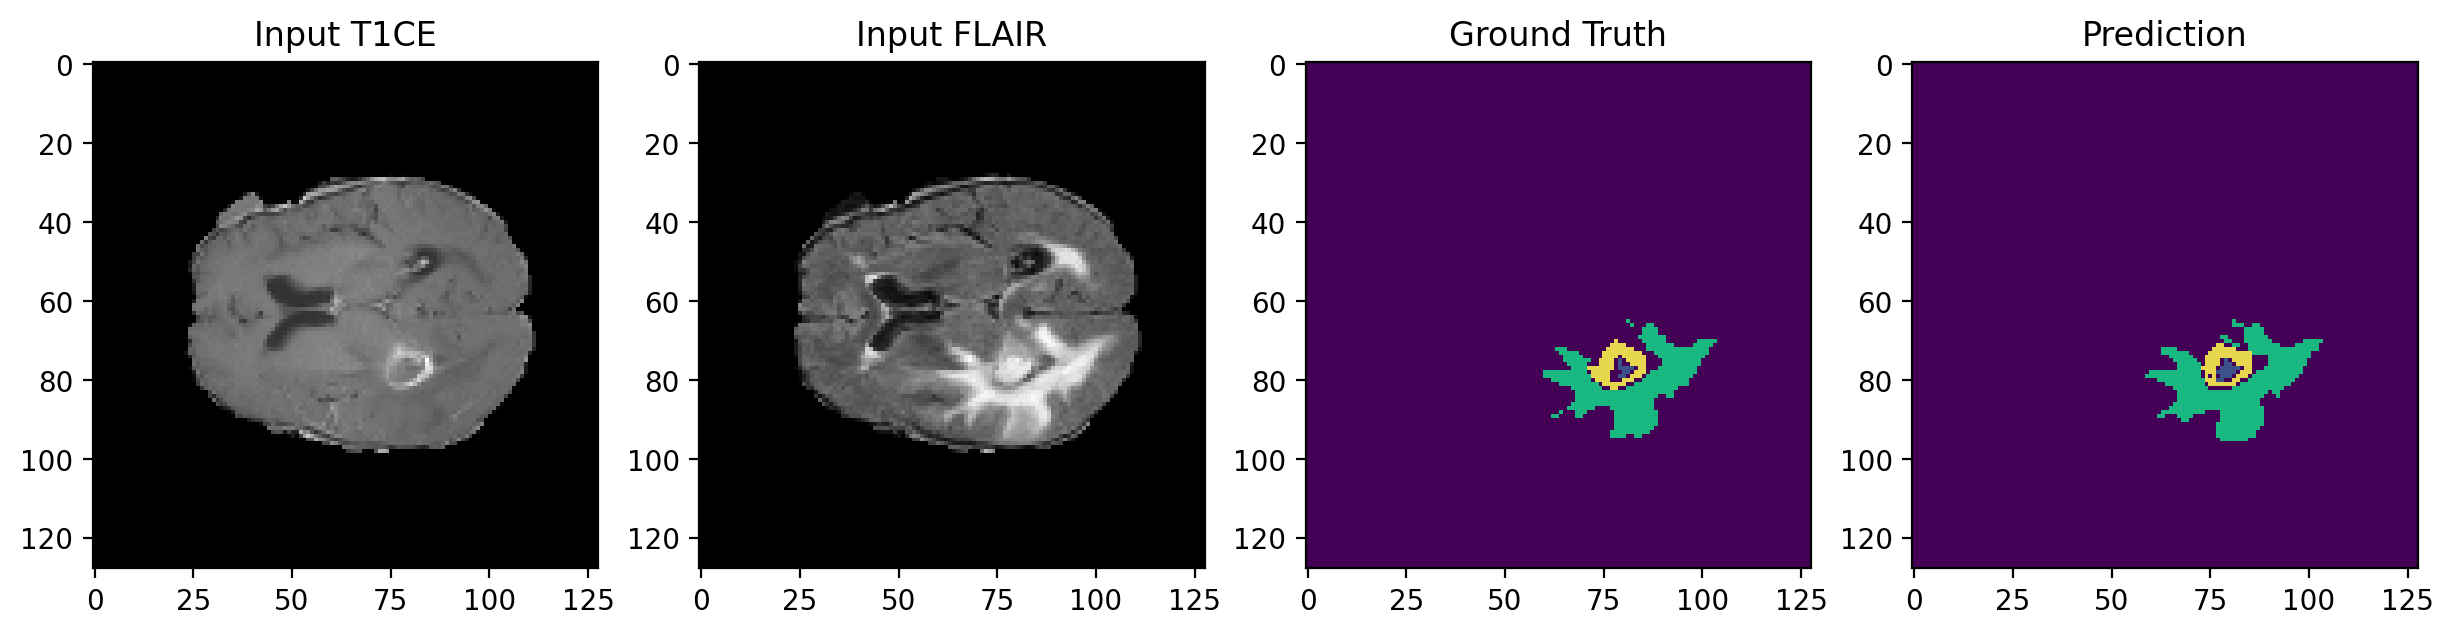

Visualizing slice index: 35


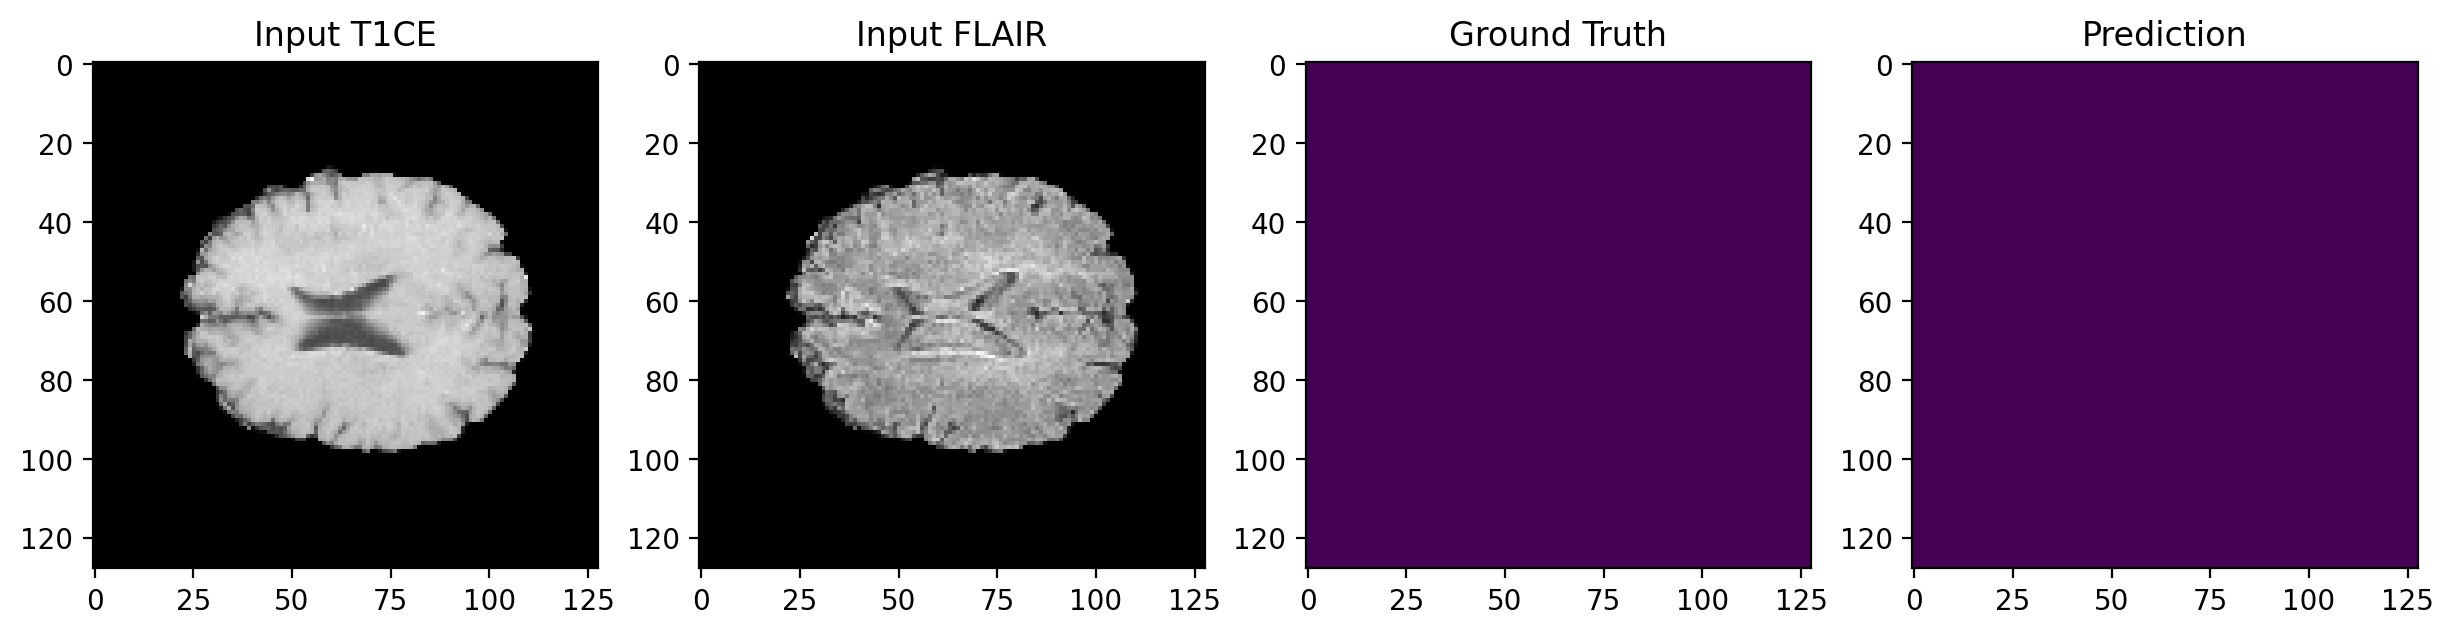

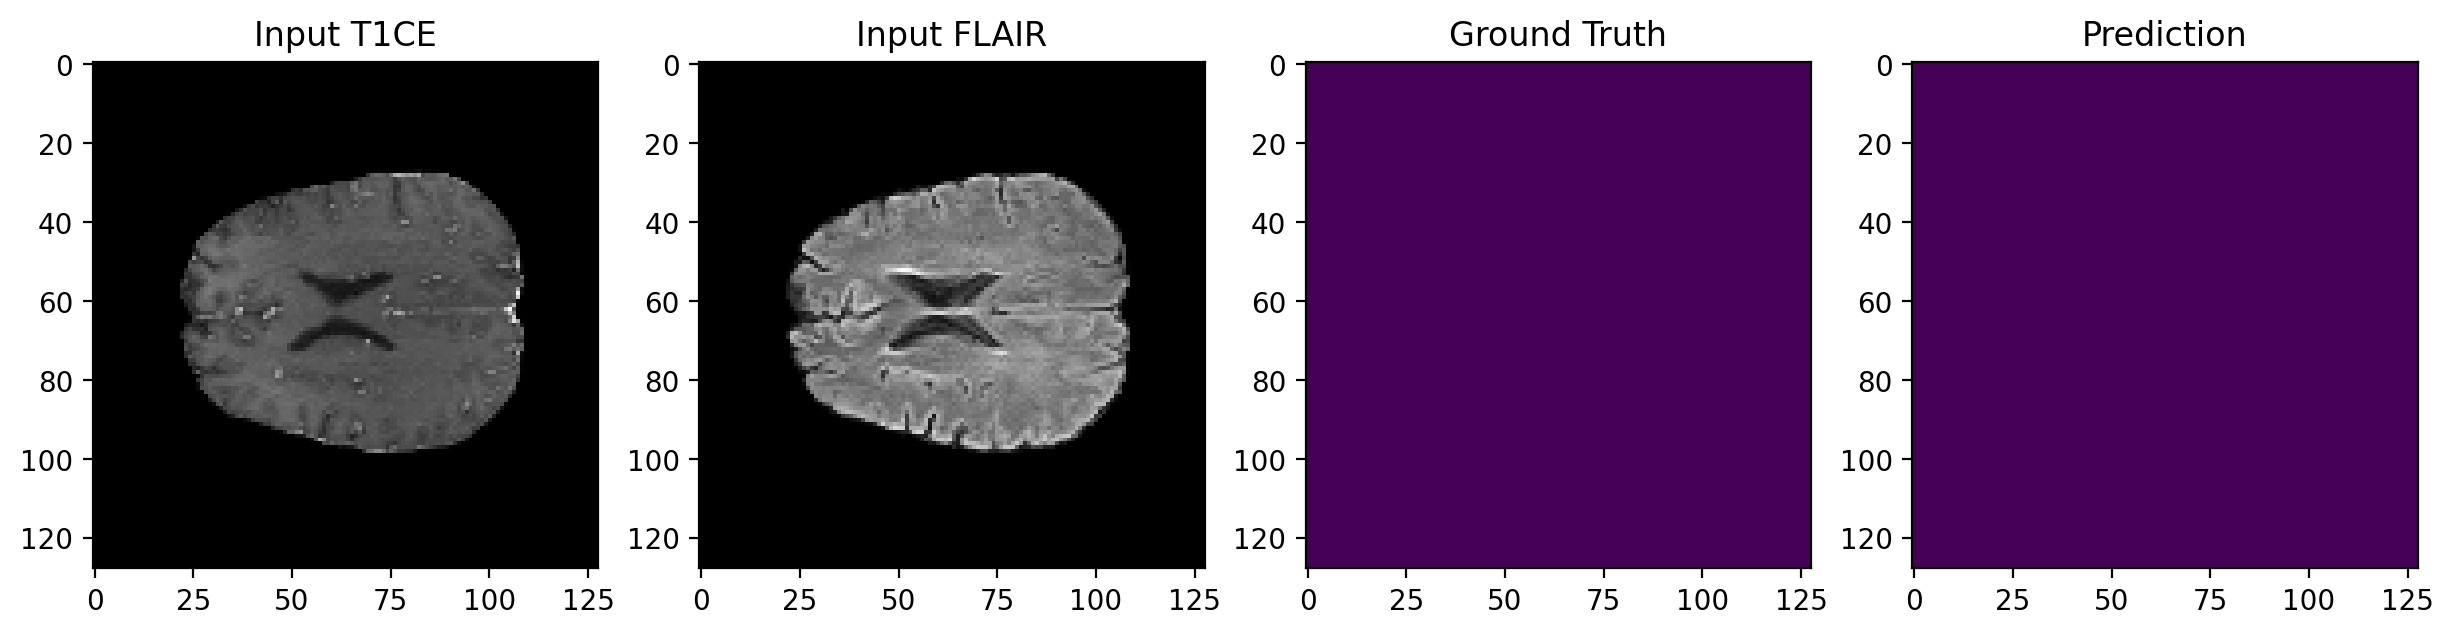

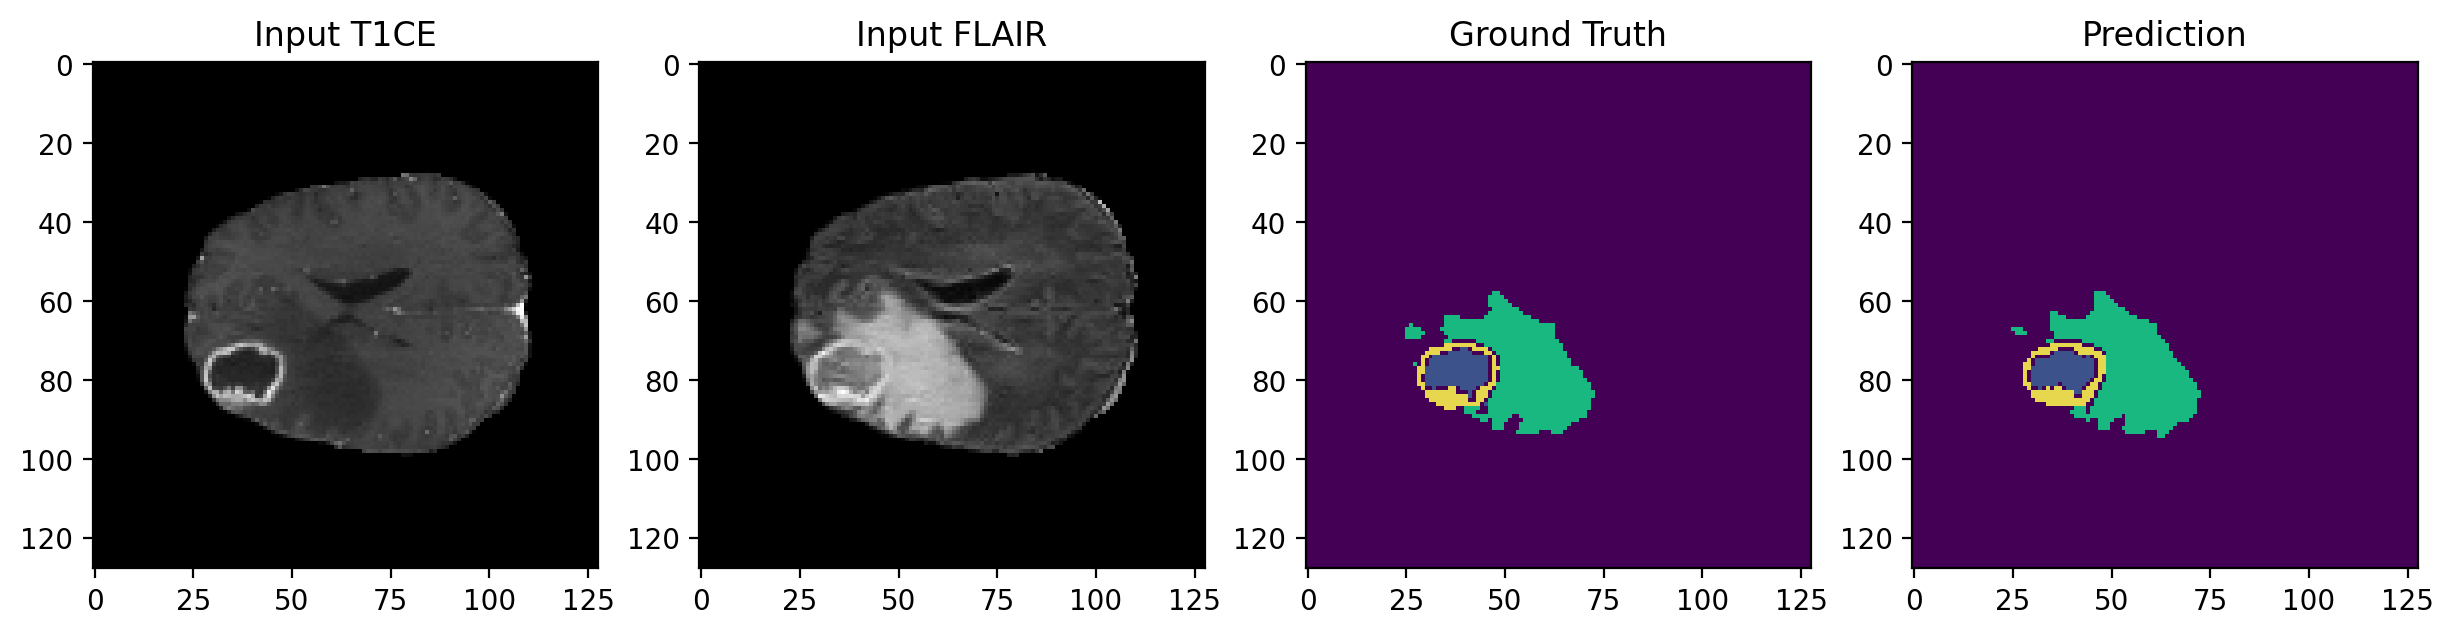

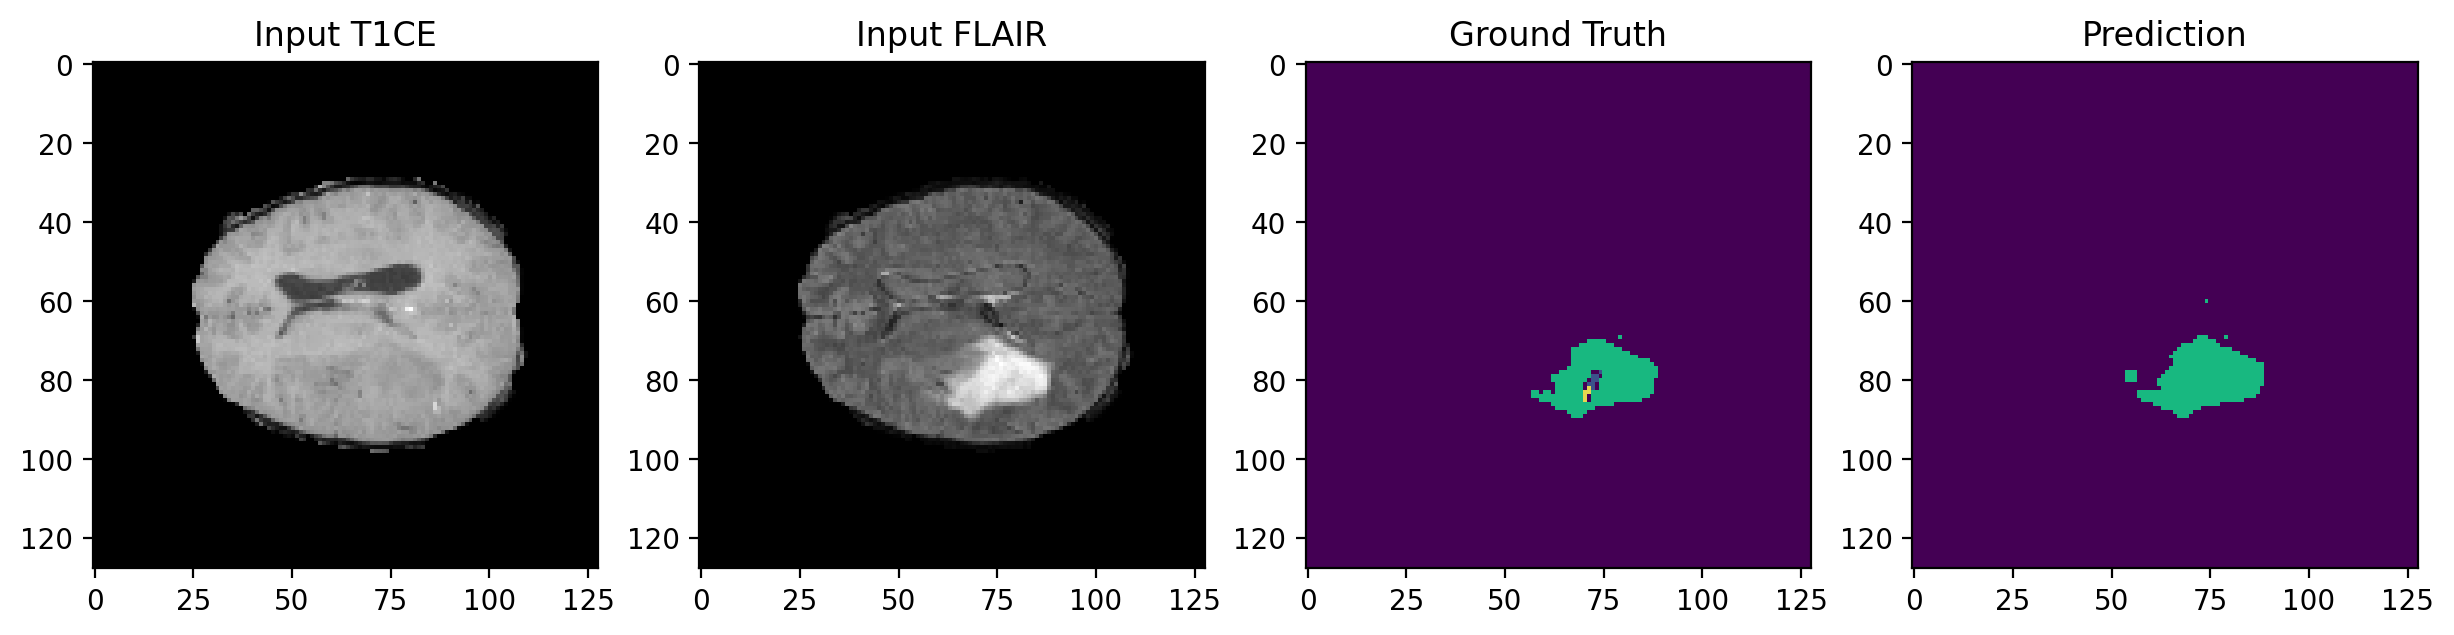

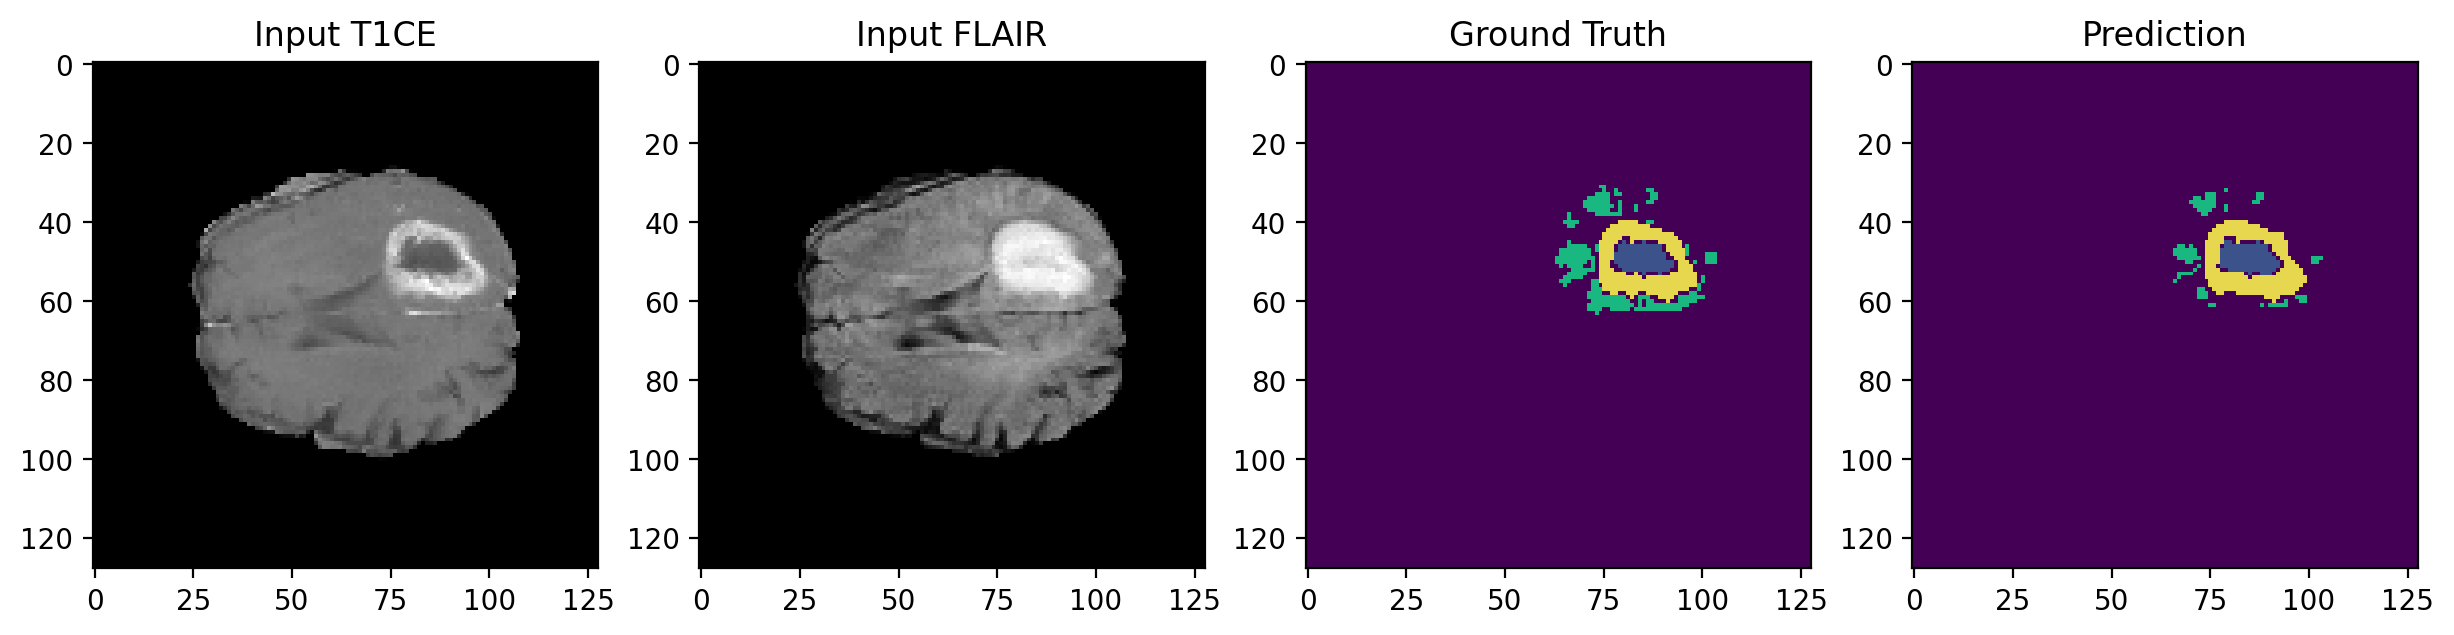

Visualizing slice index: 45


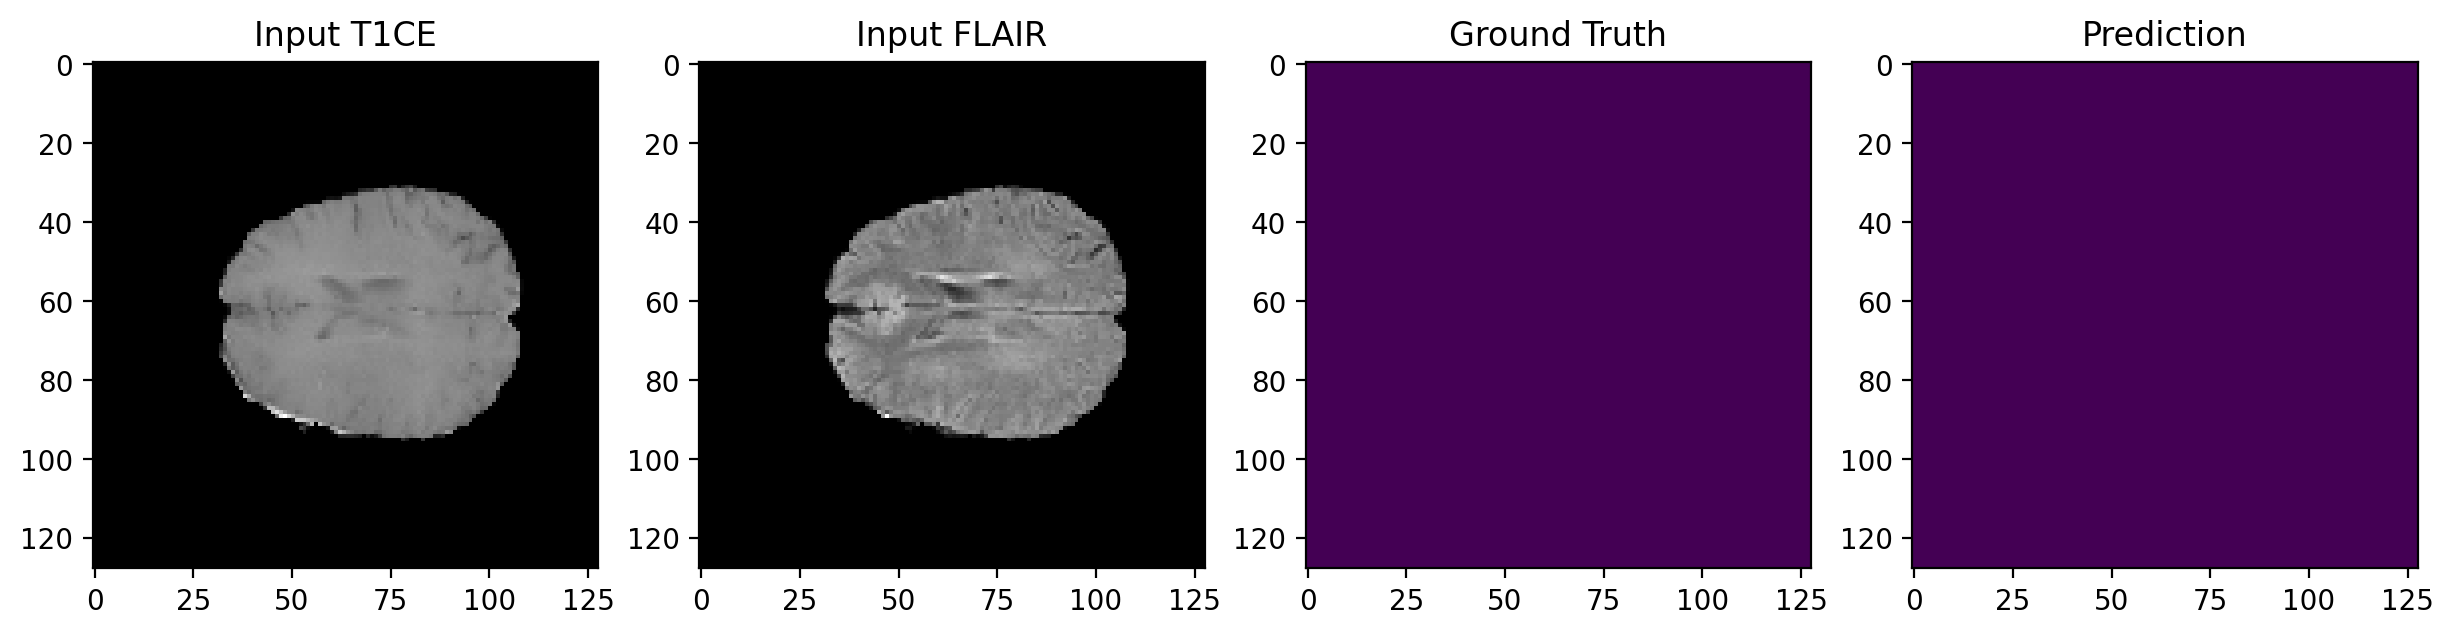

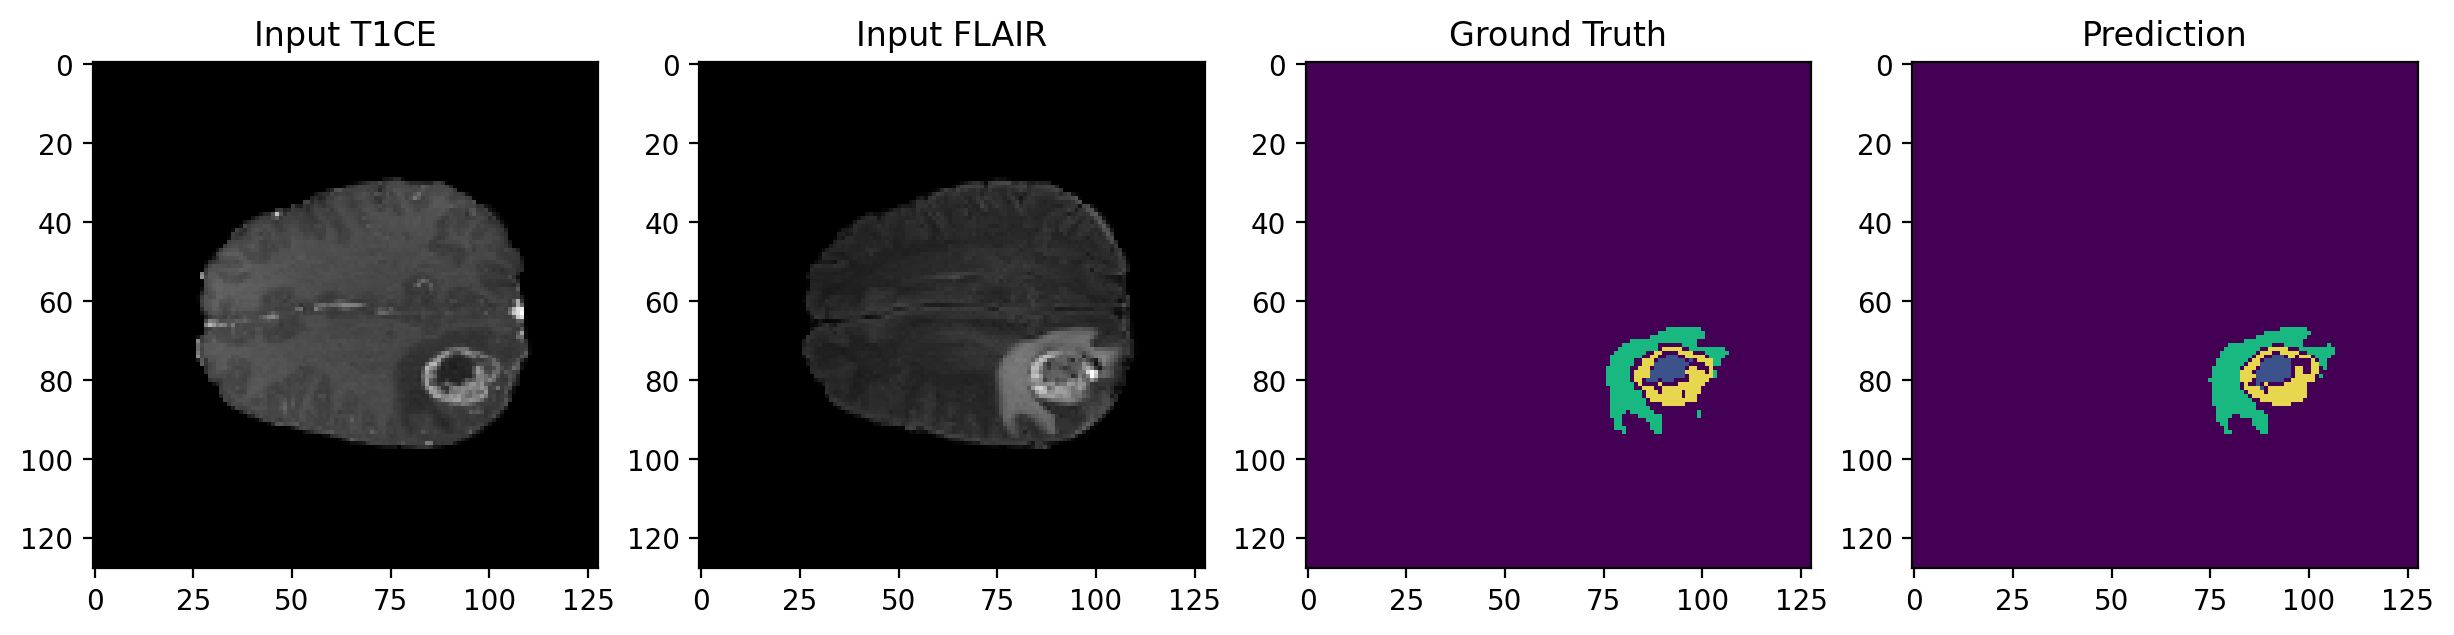

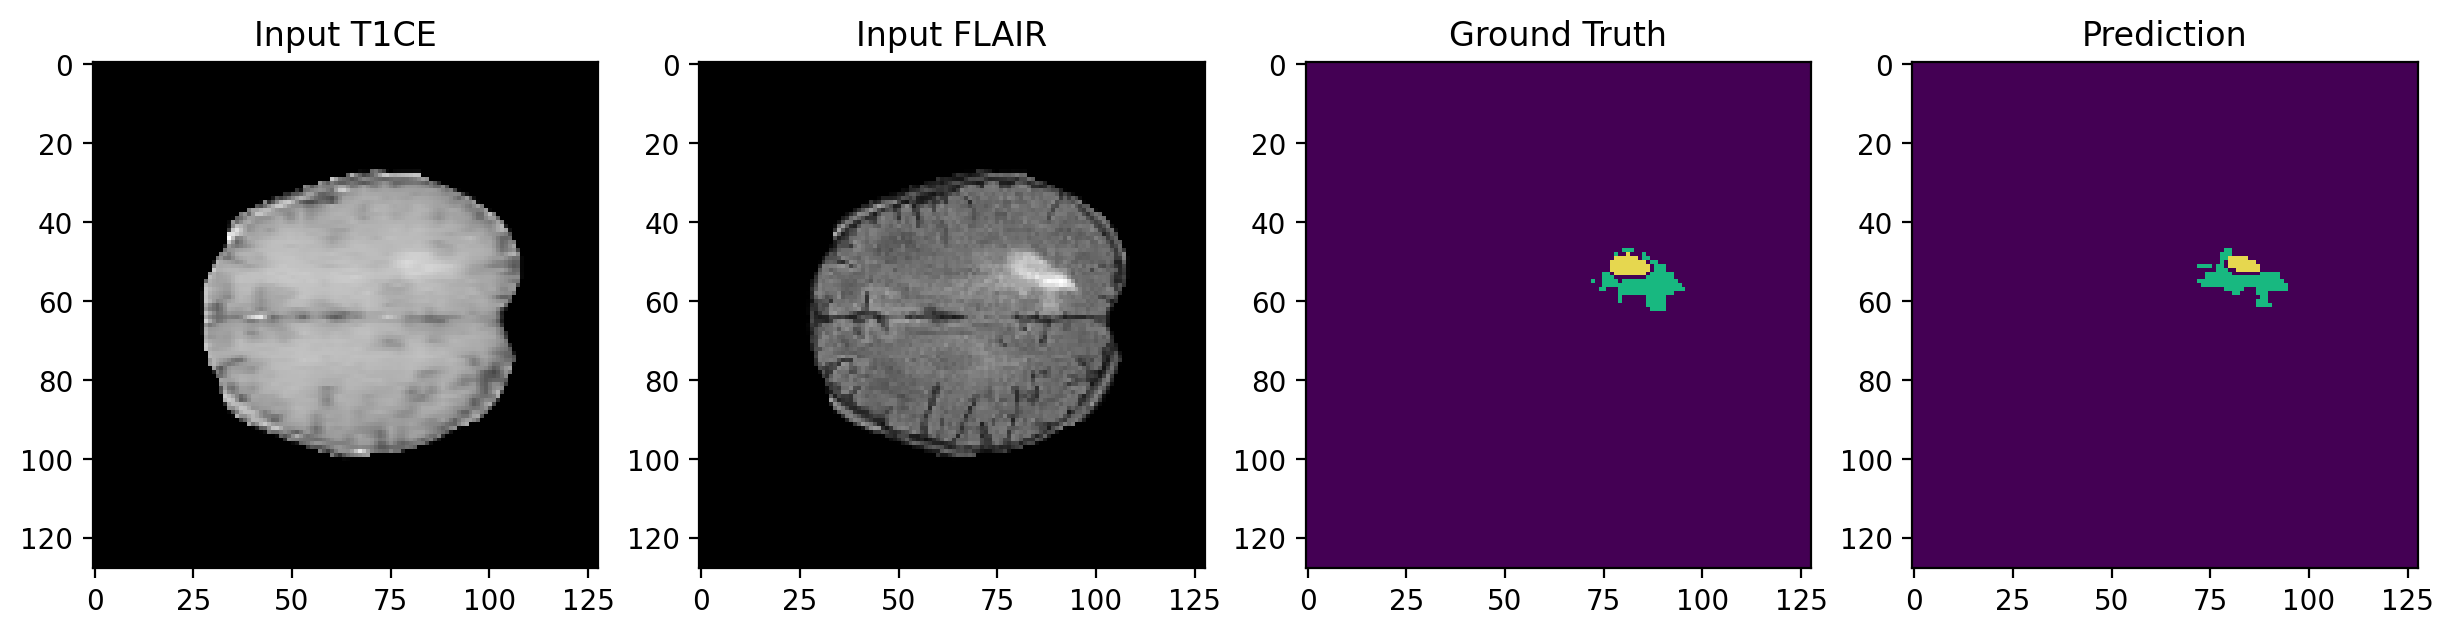

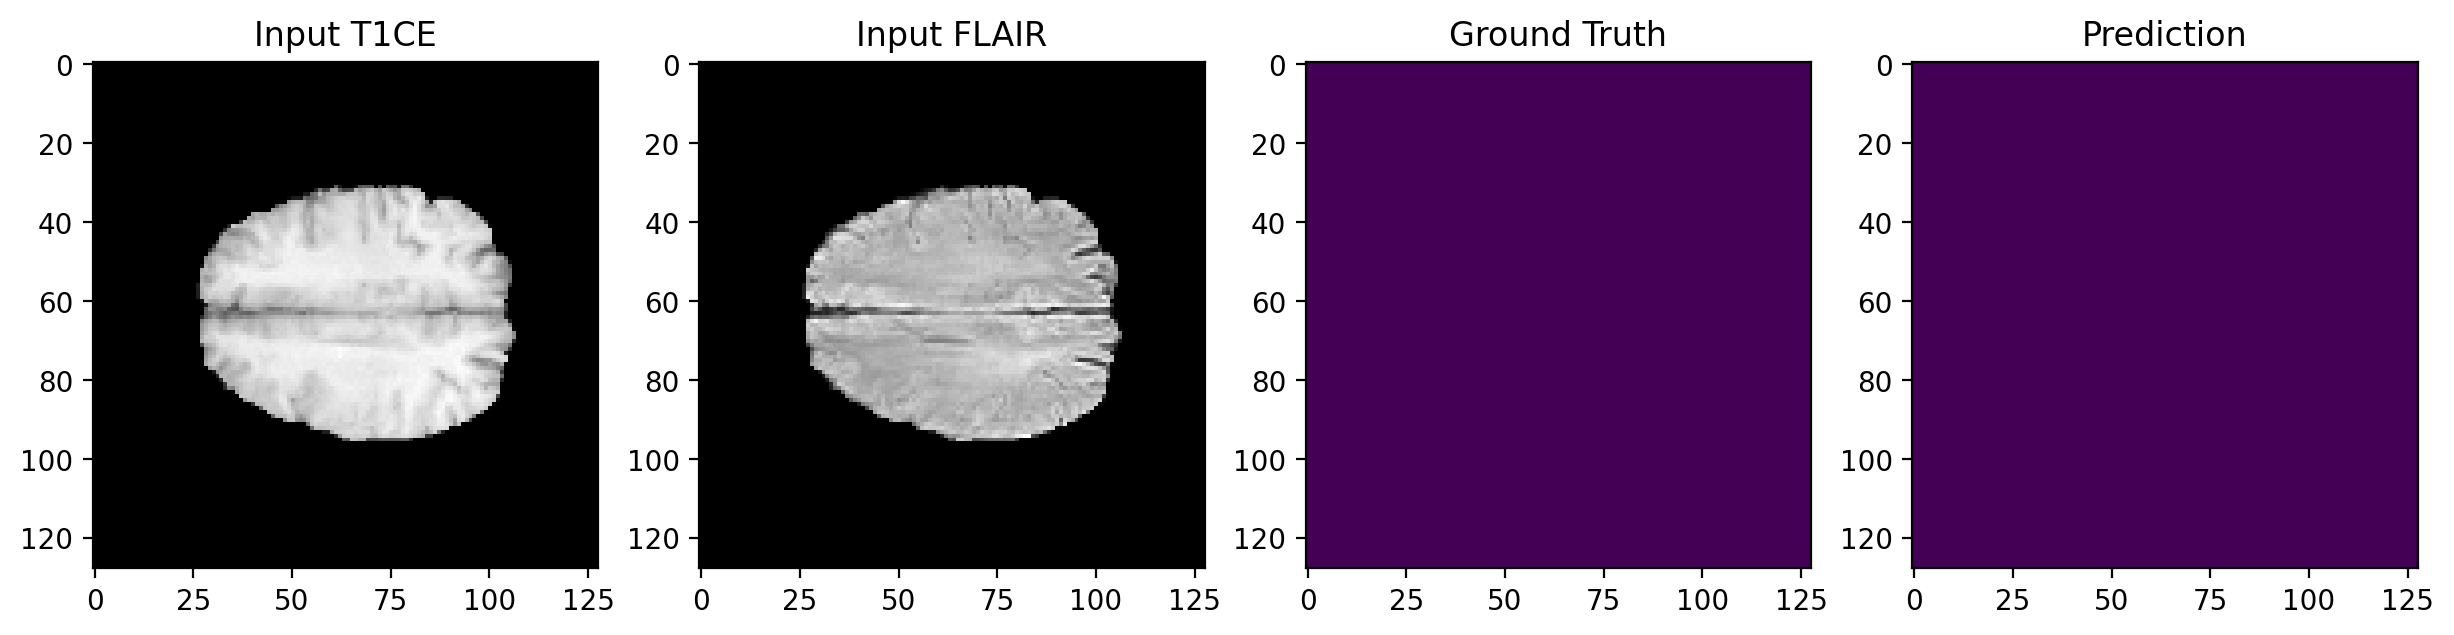

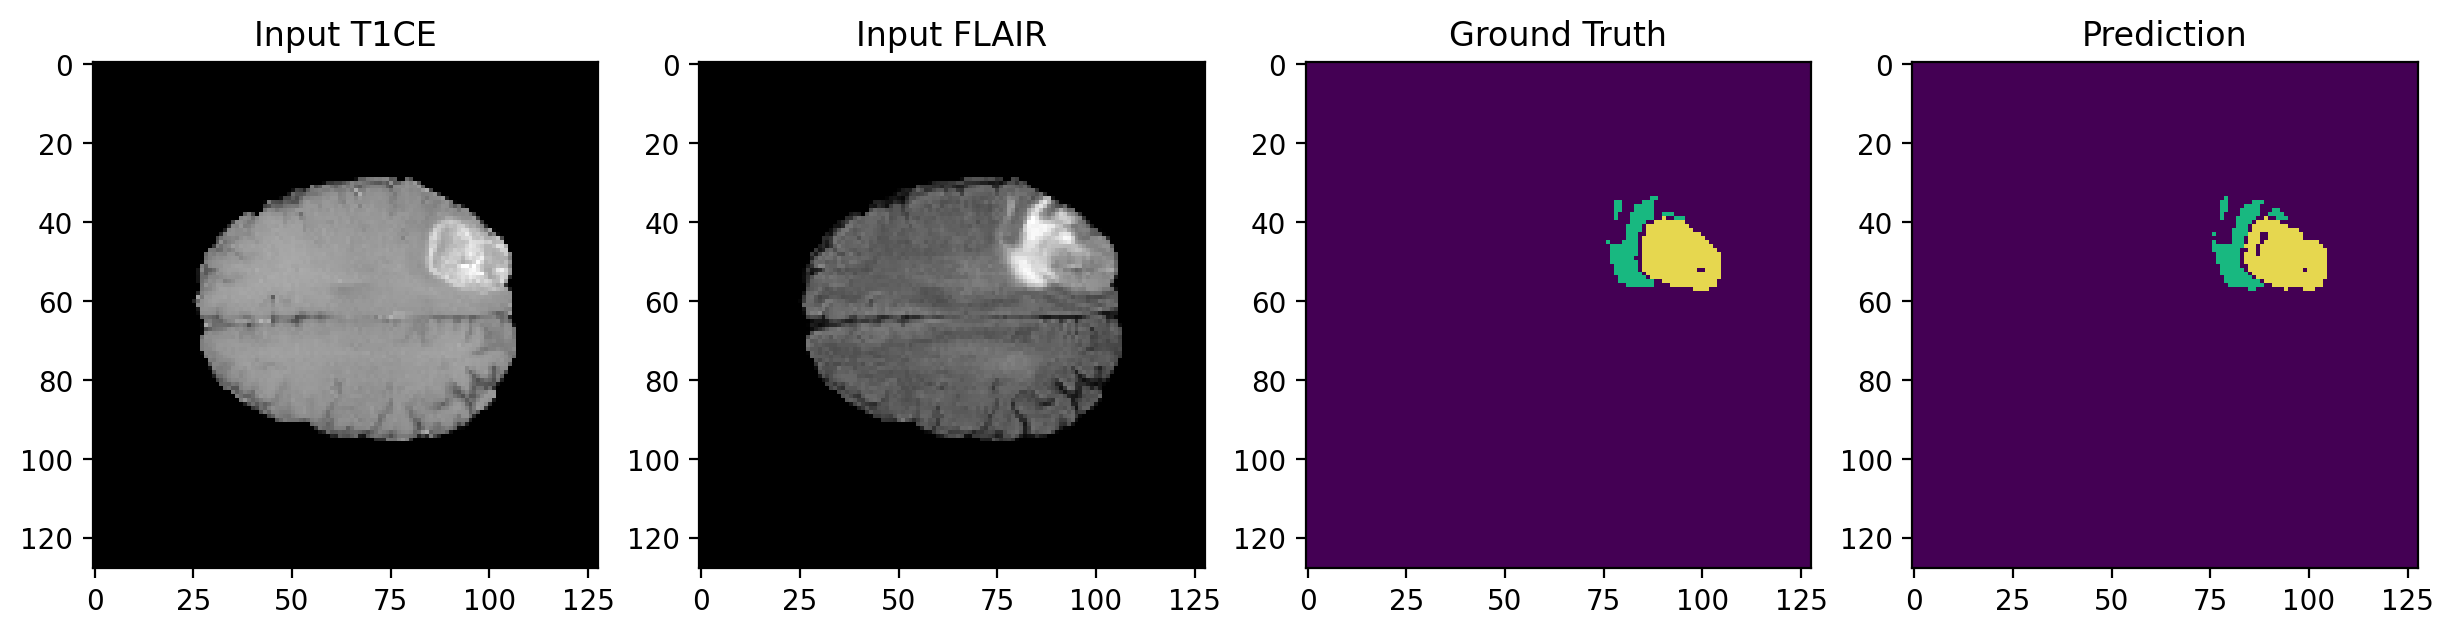

In [43]:
# Validation set
quick_visualize(model, val_loader, device, 5, [5,15,25,35,45])

Visualizing slice index: 5


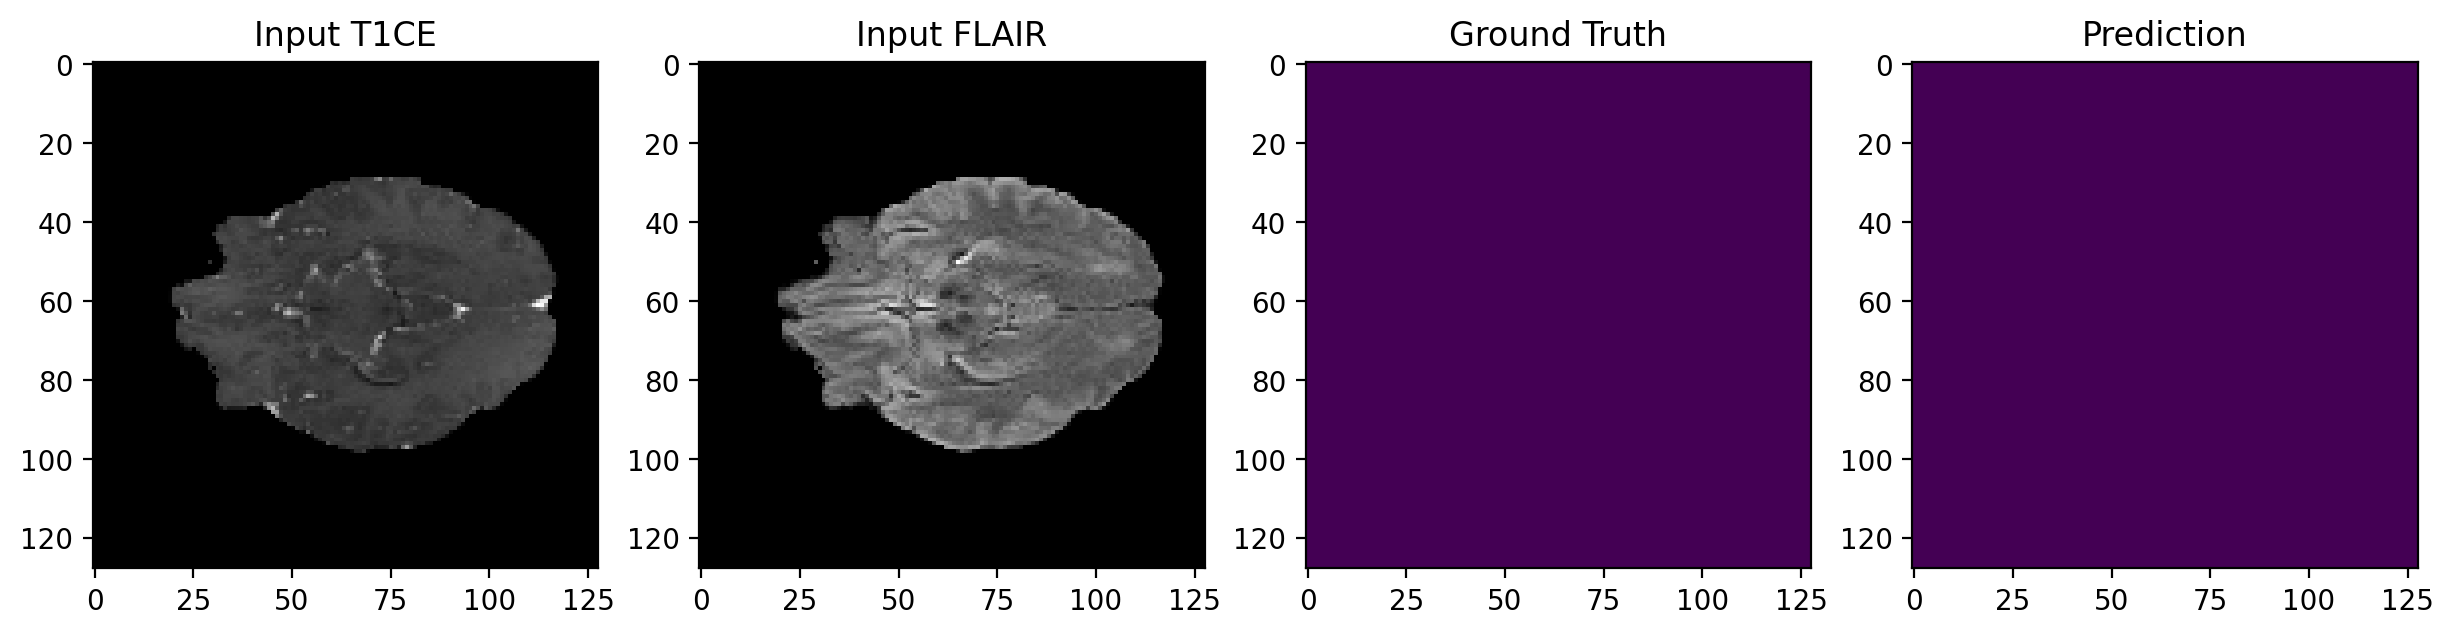

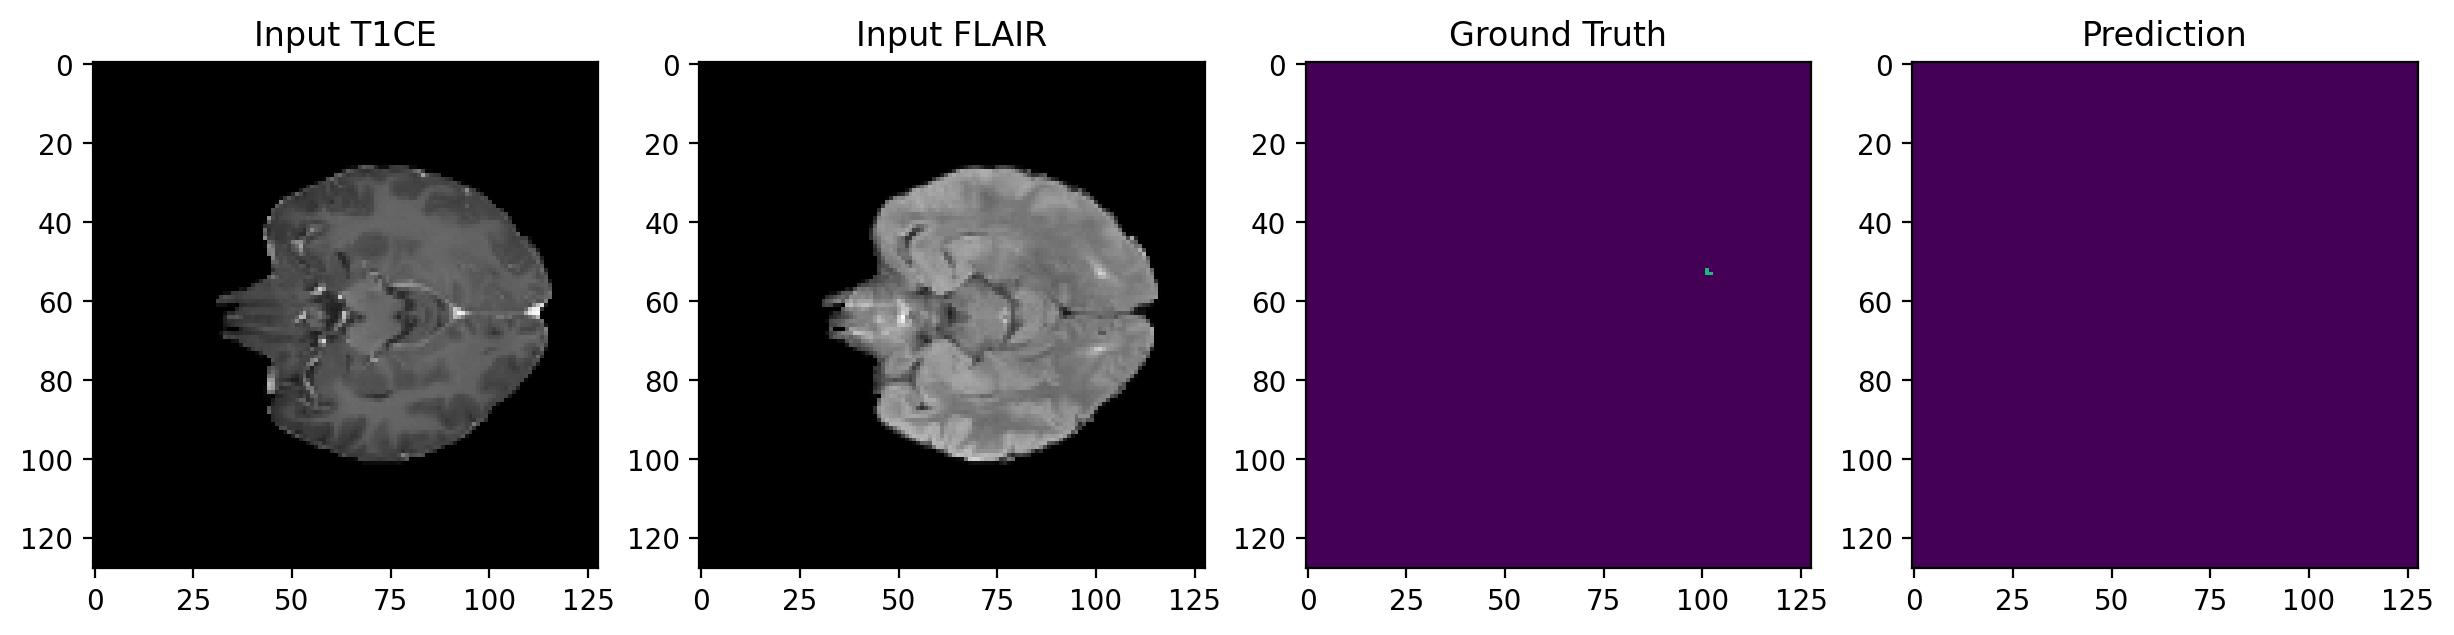

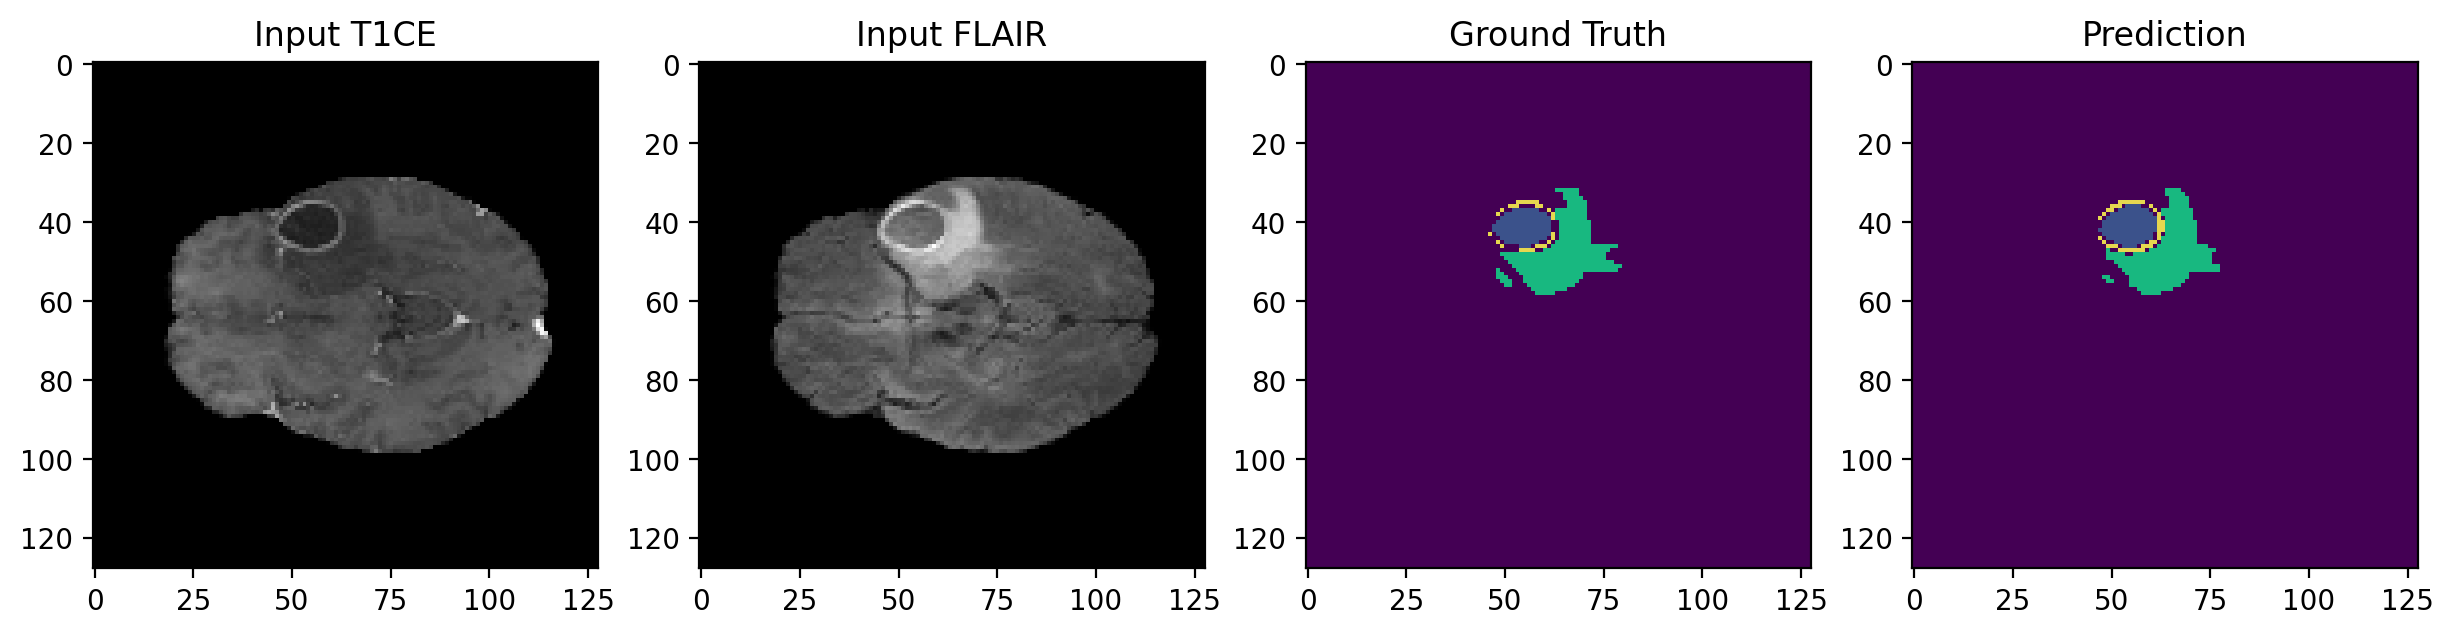

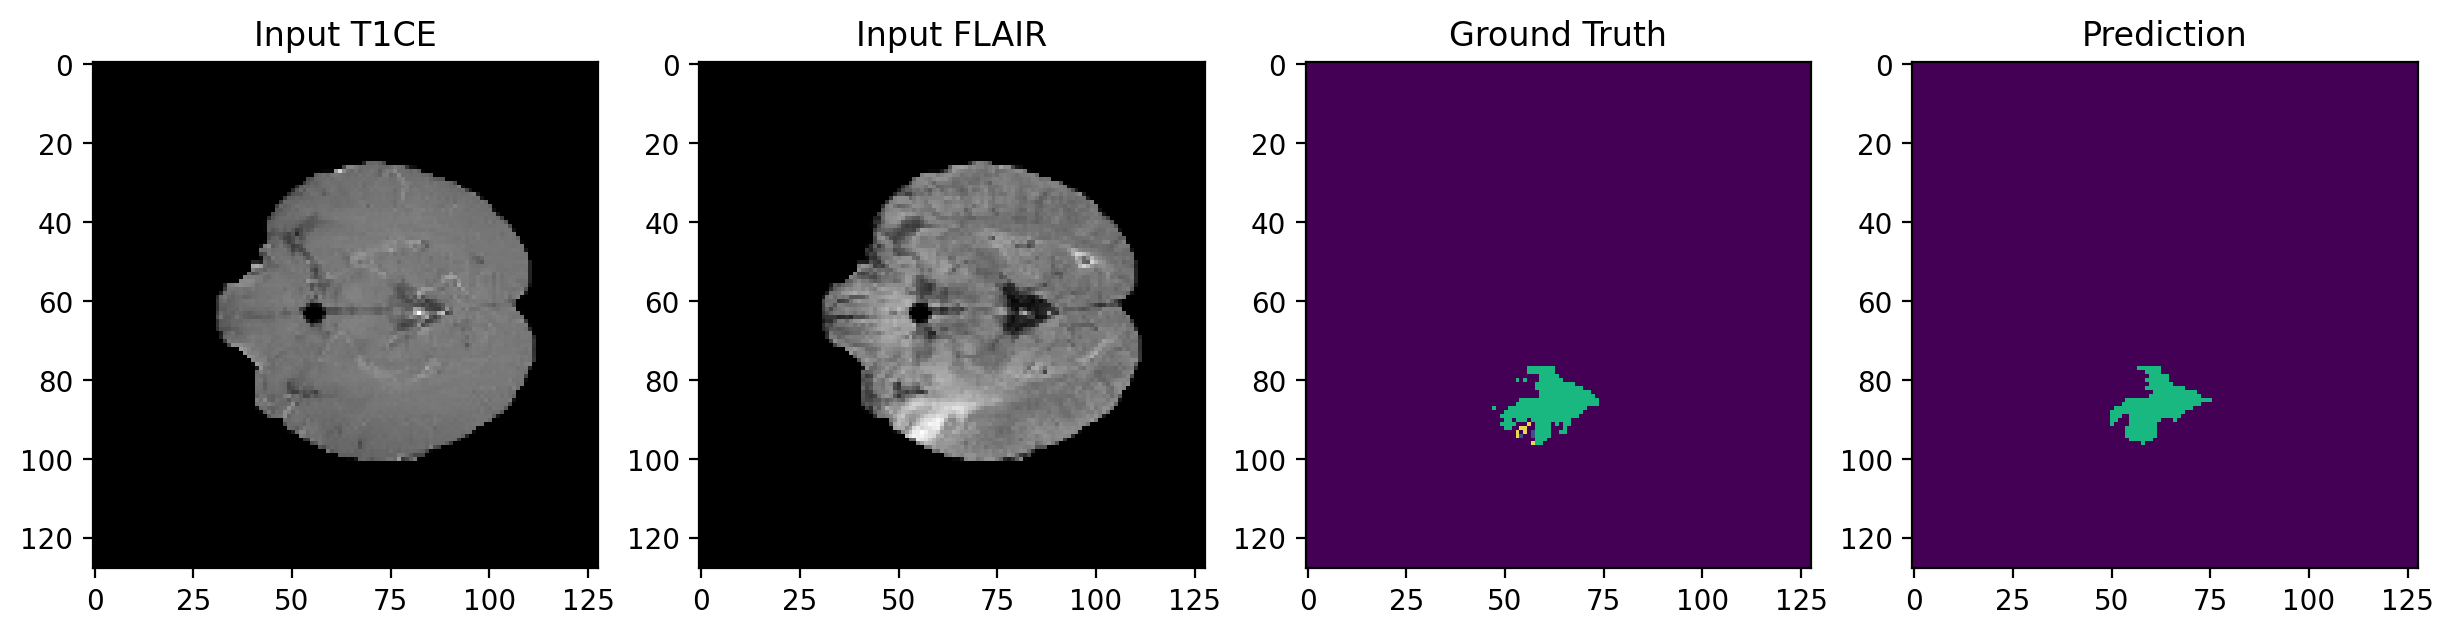

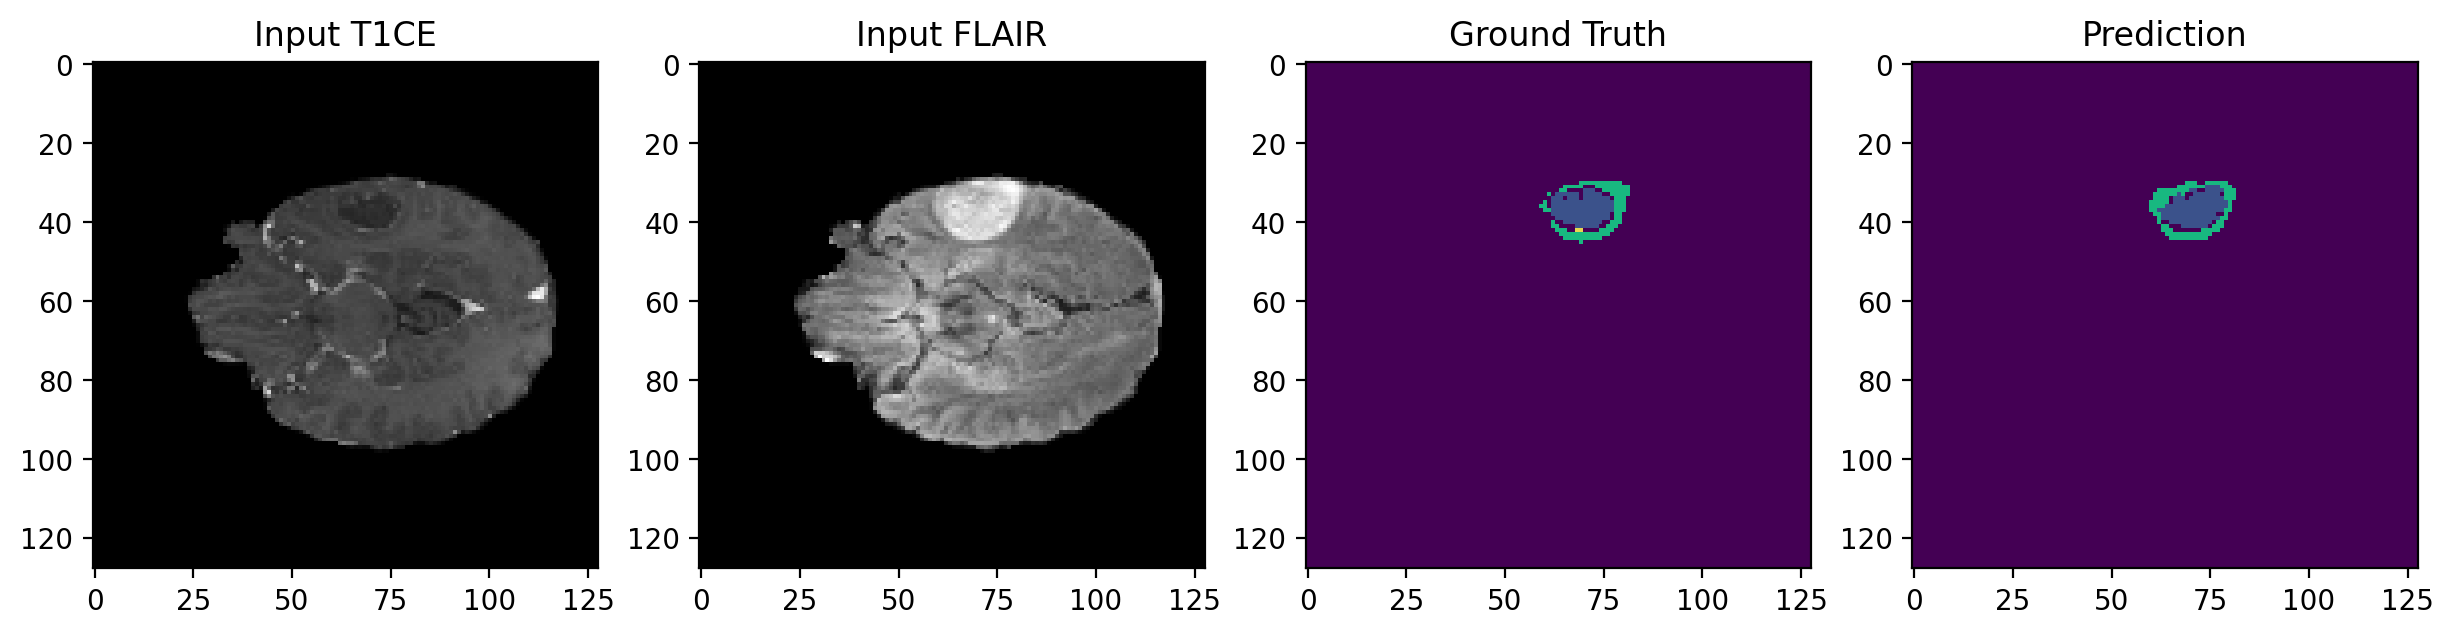

Visualizing slice index: 15


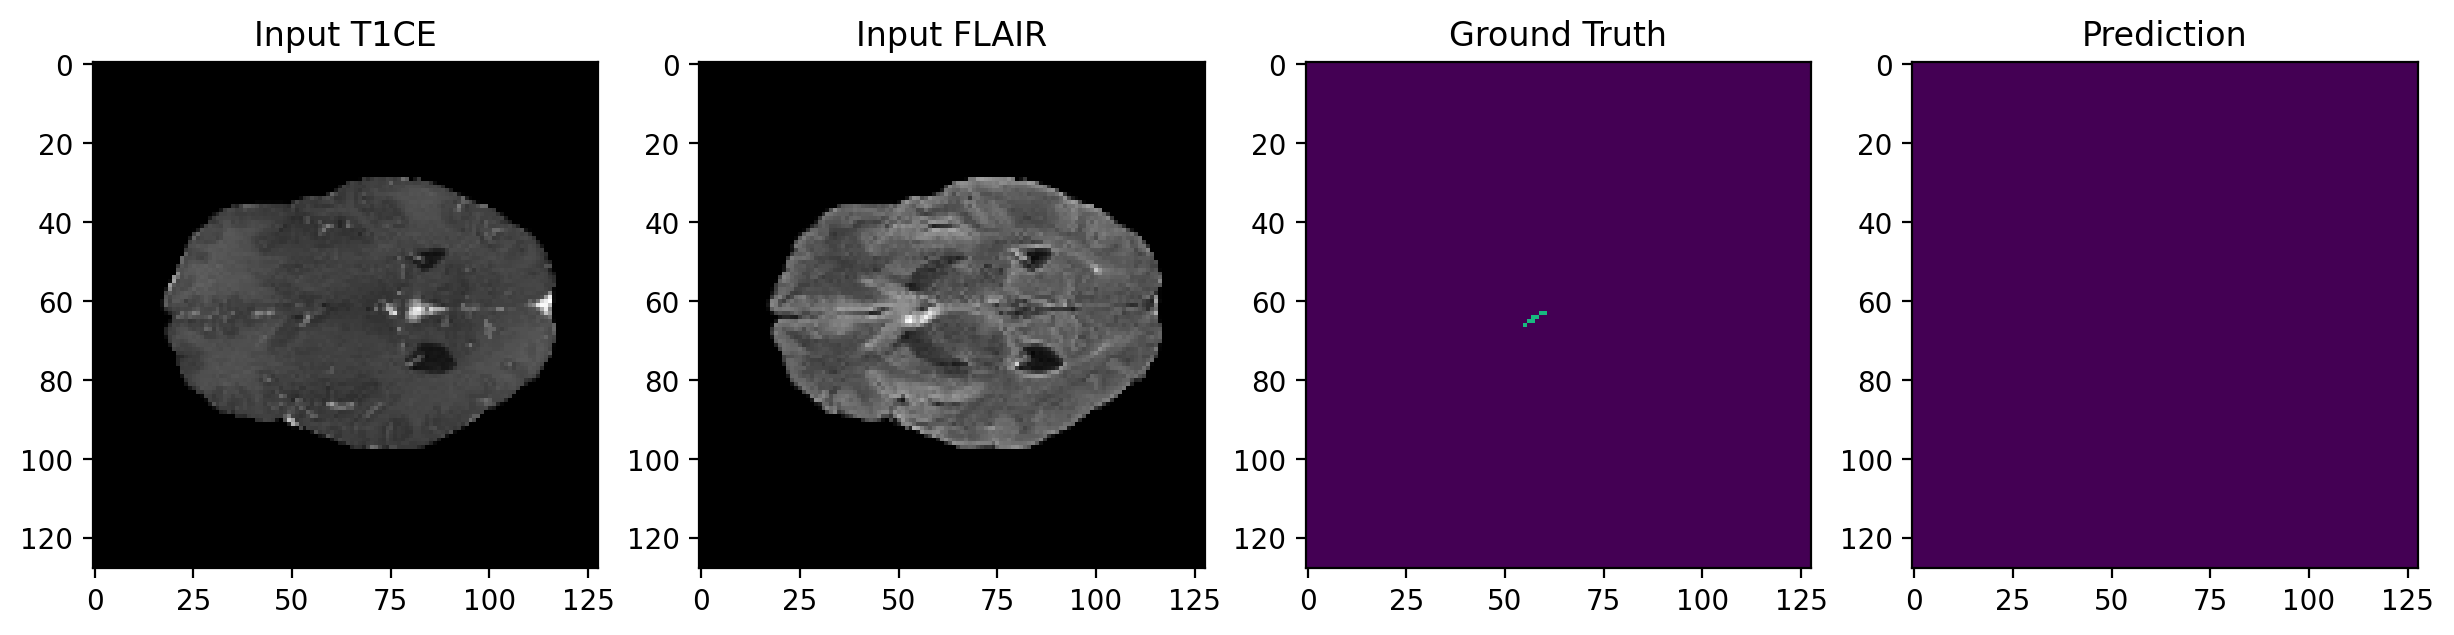

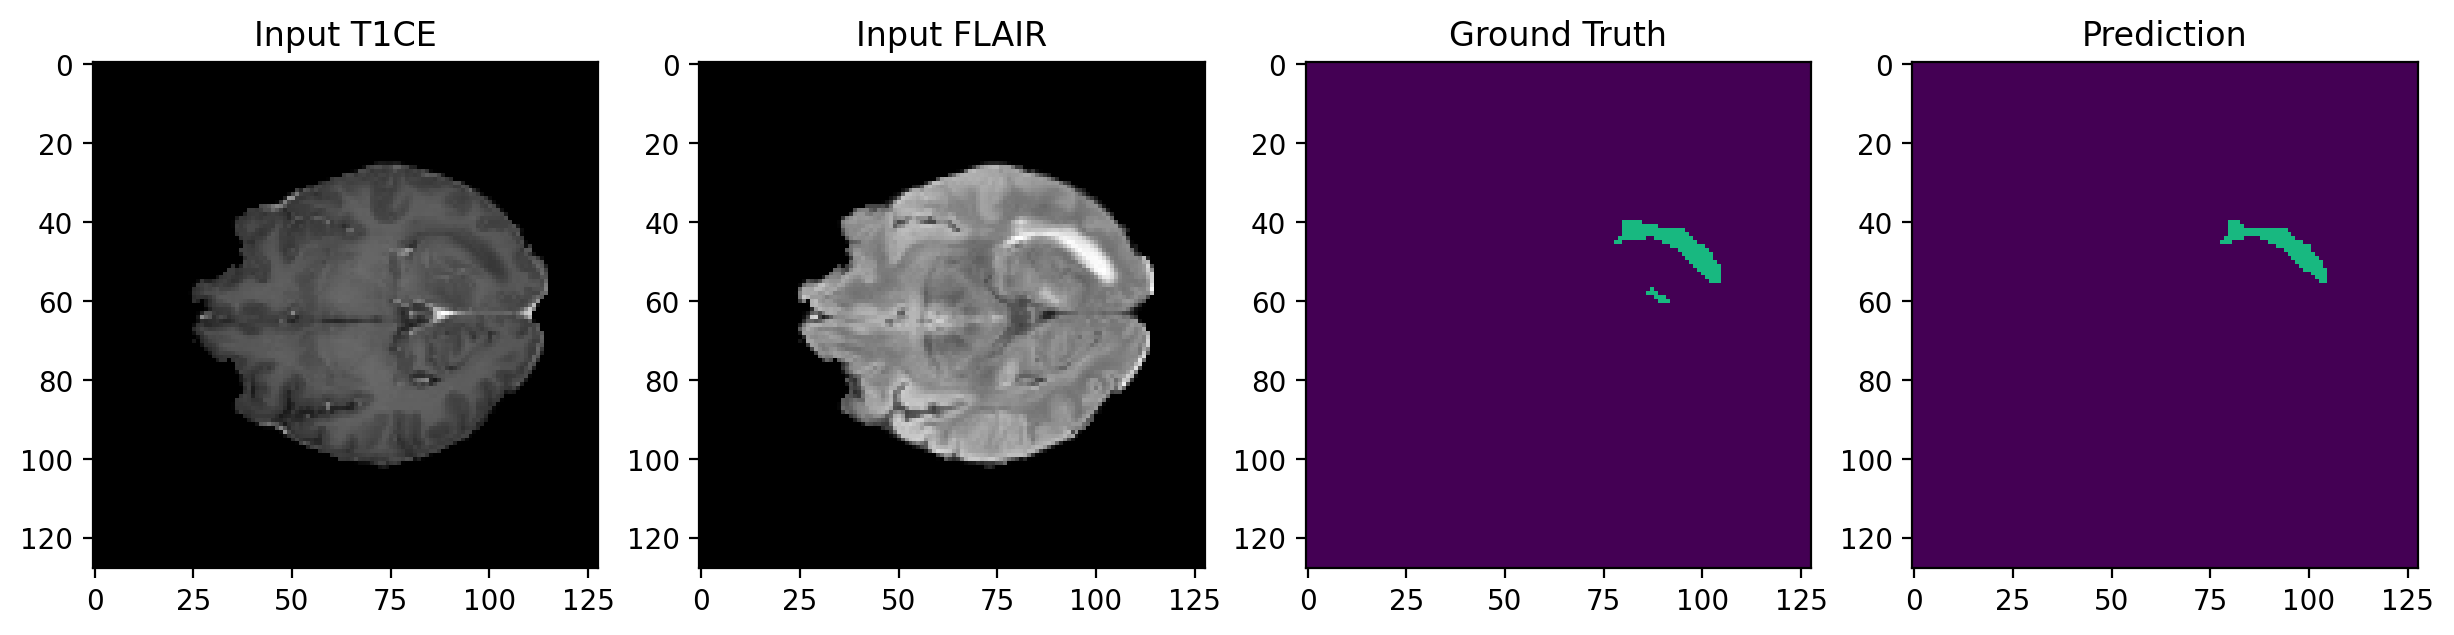

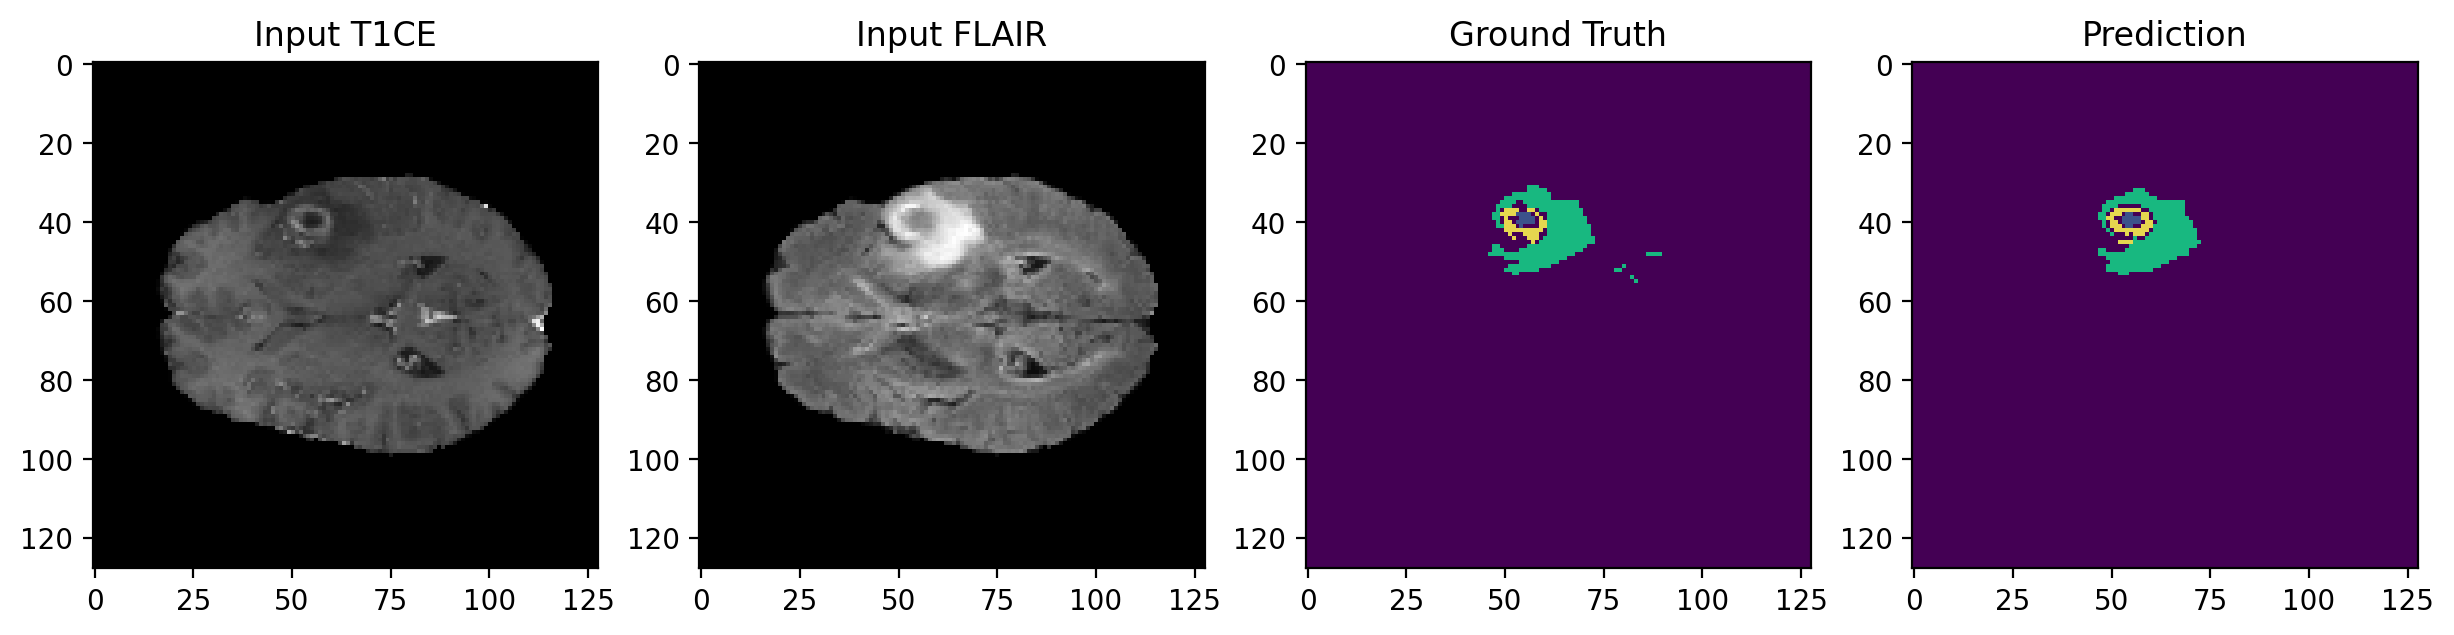

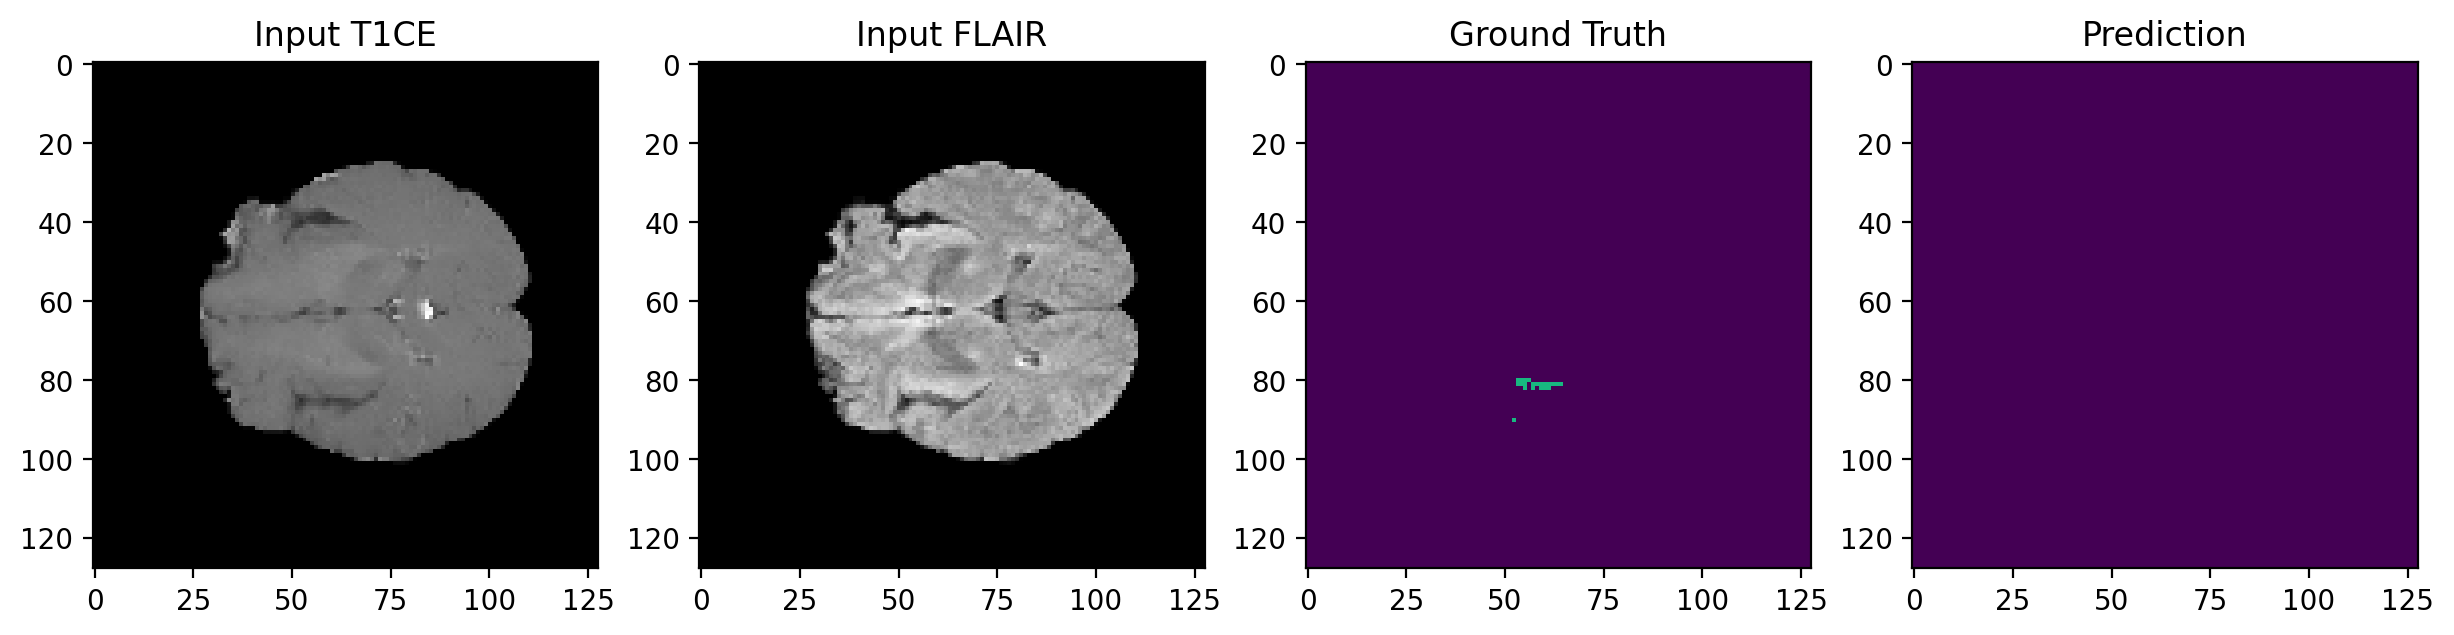

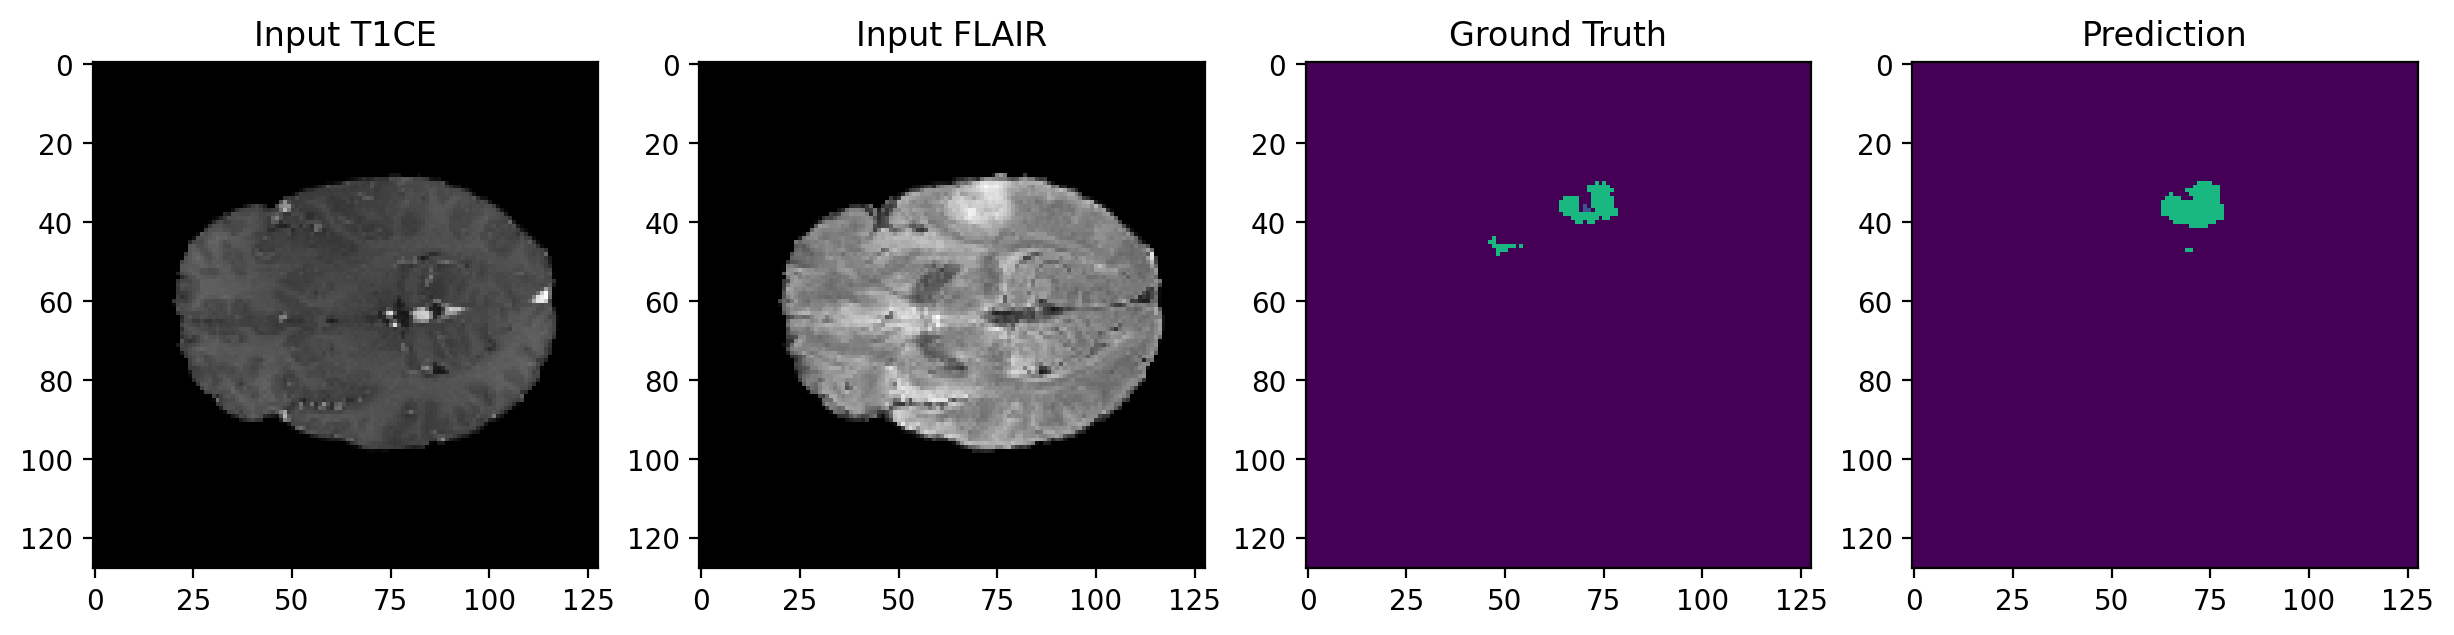

Visualizing slice index: 25


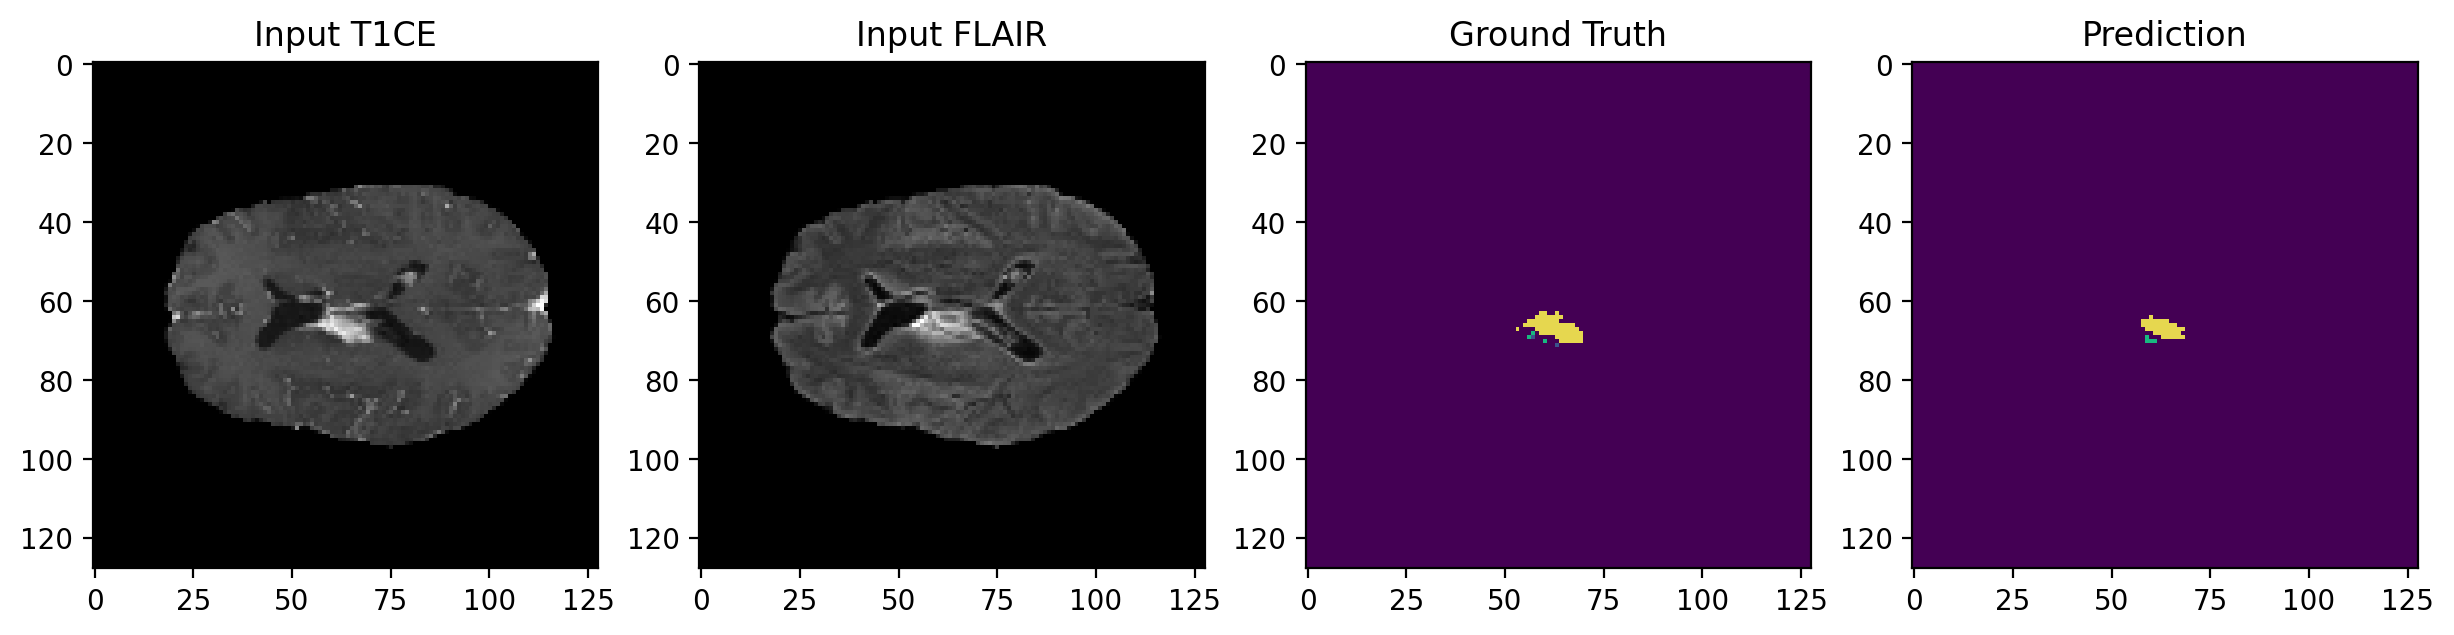

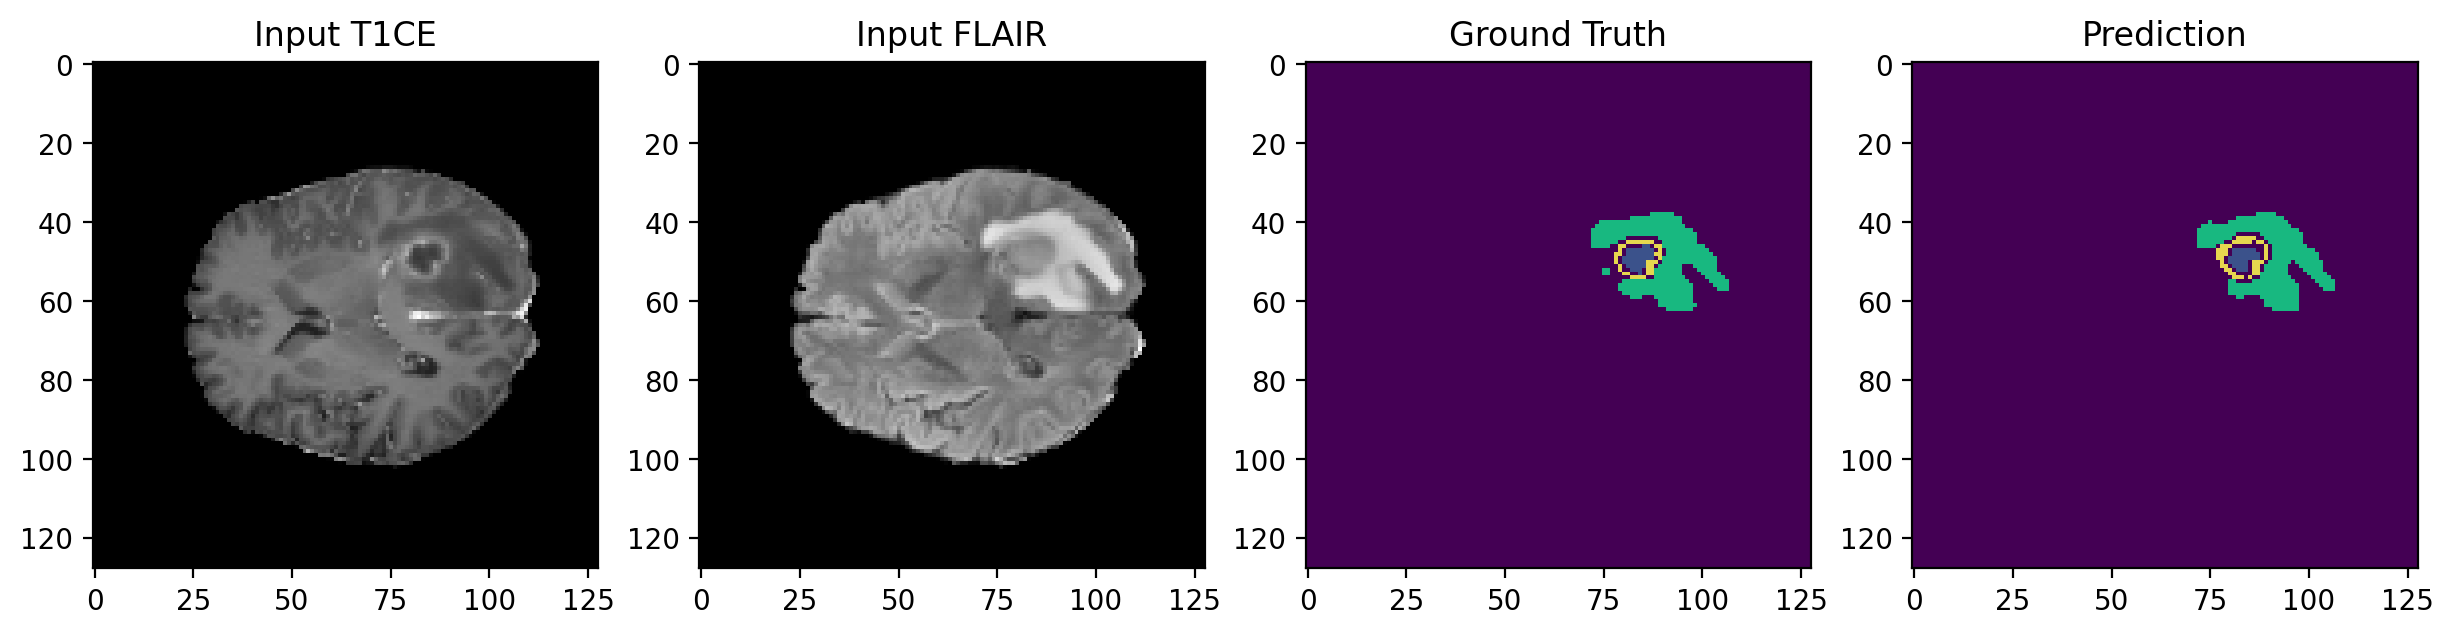

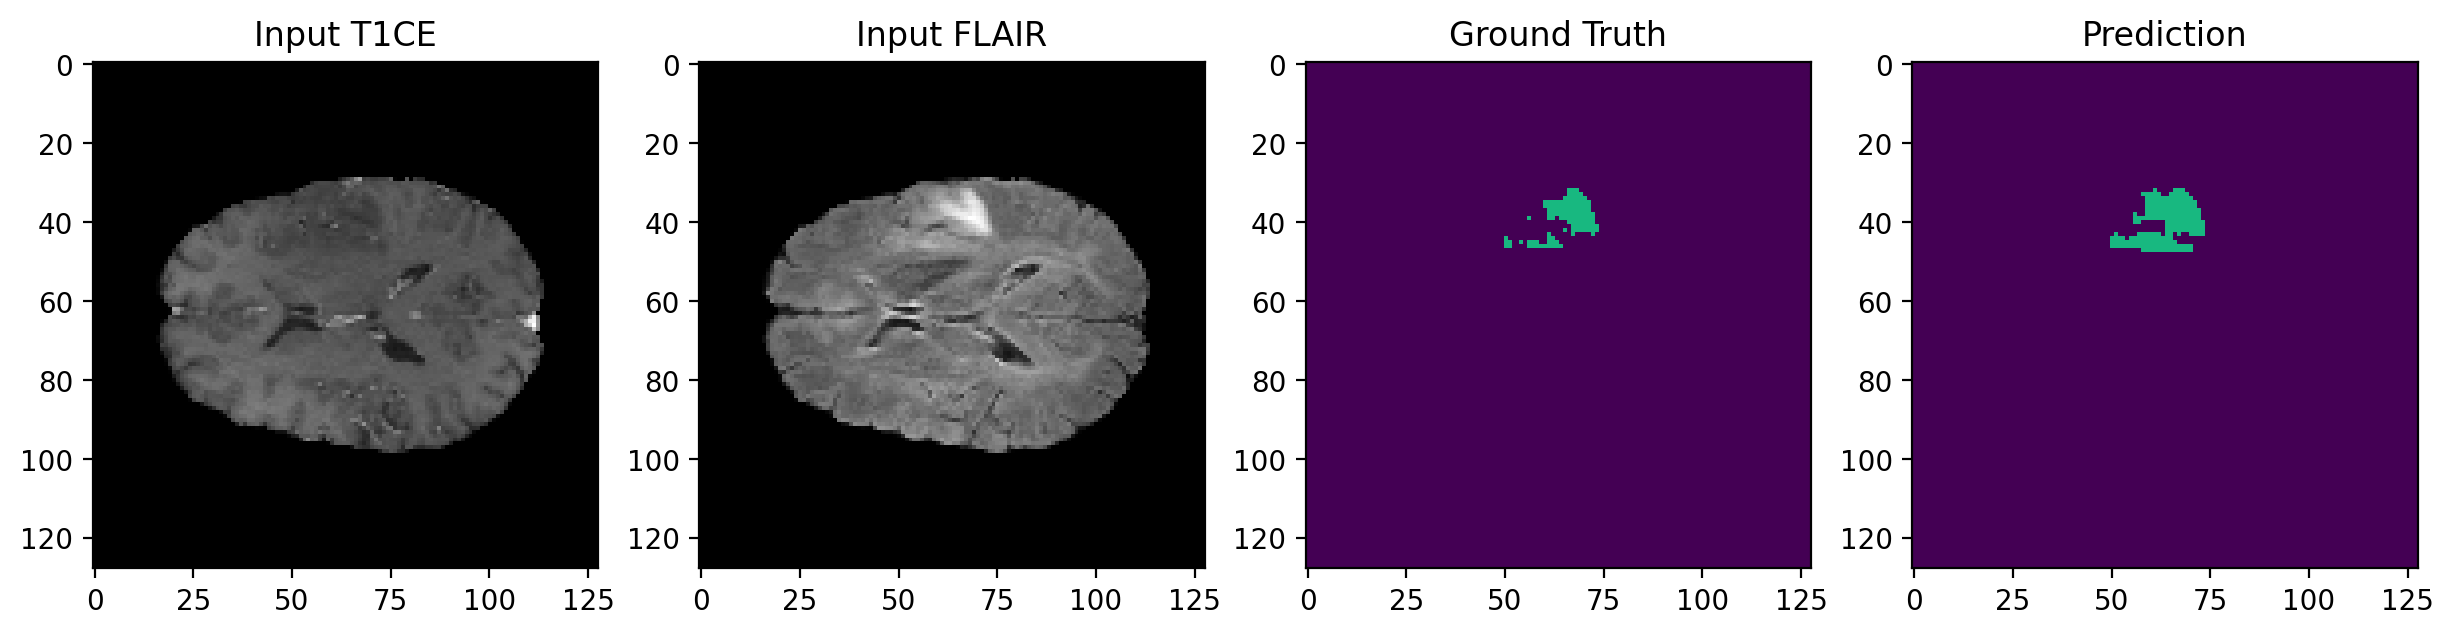

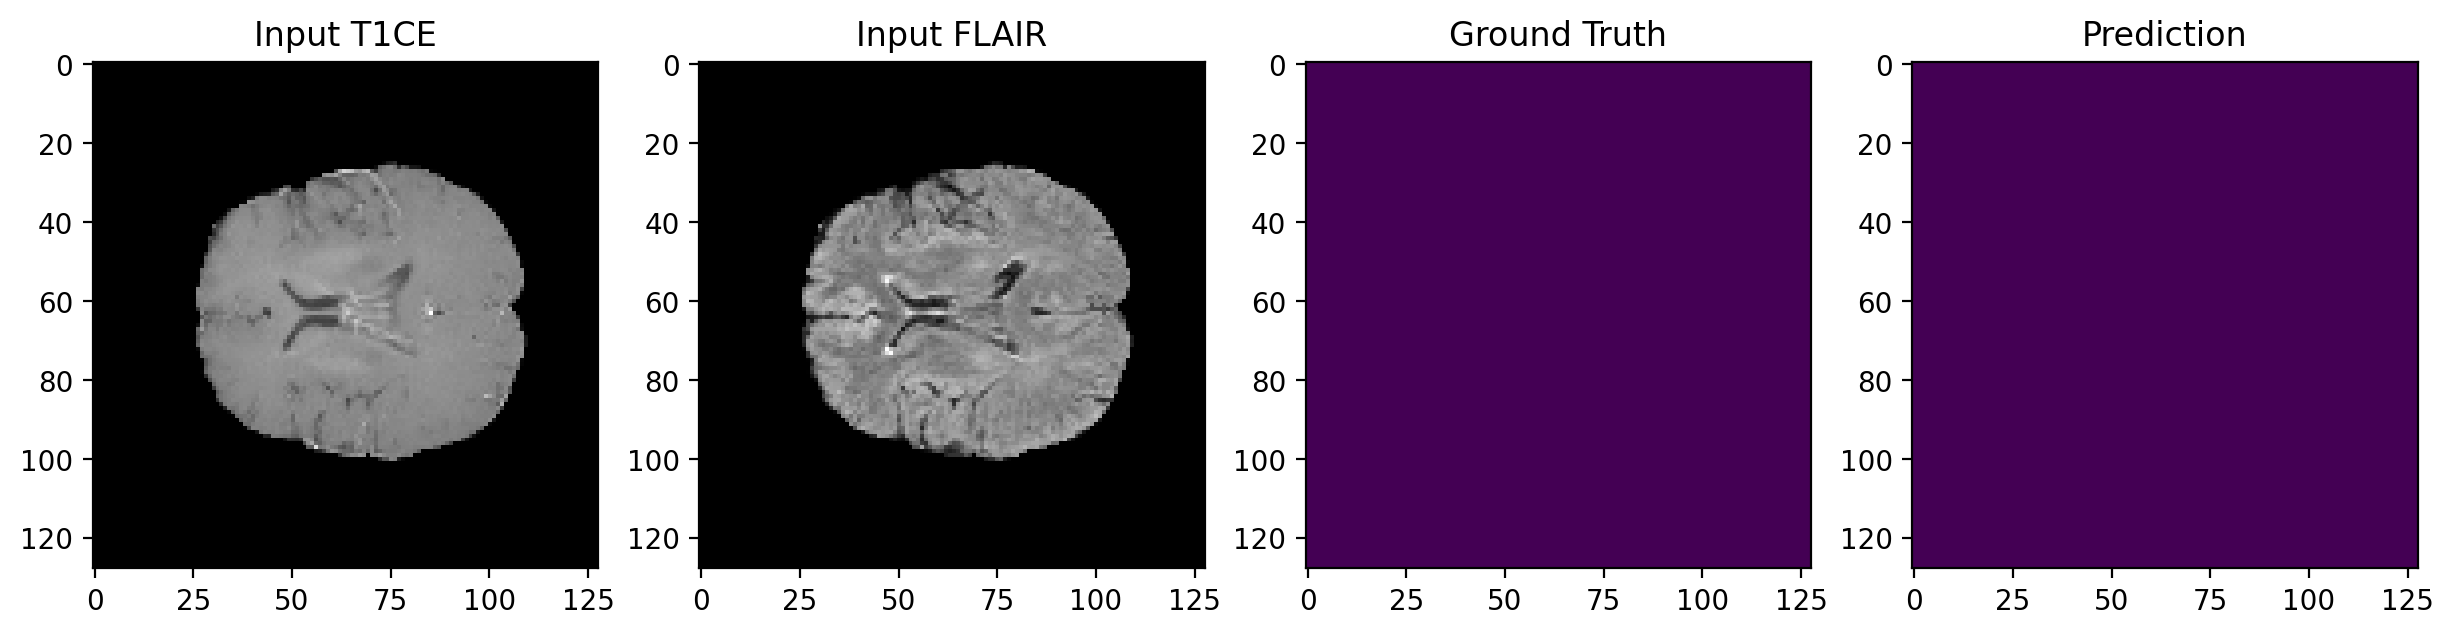

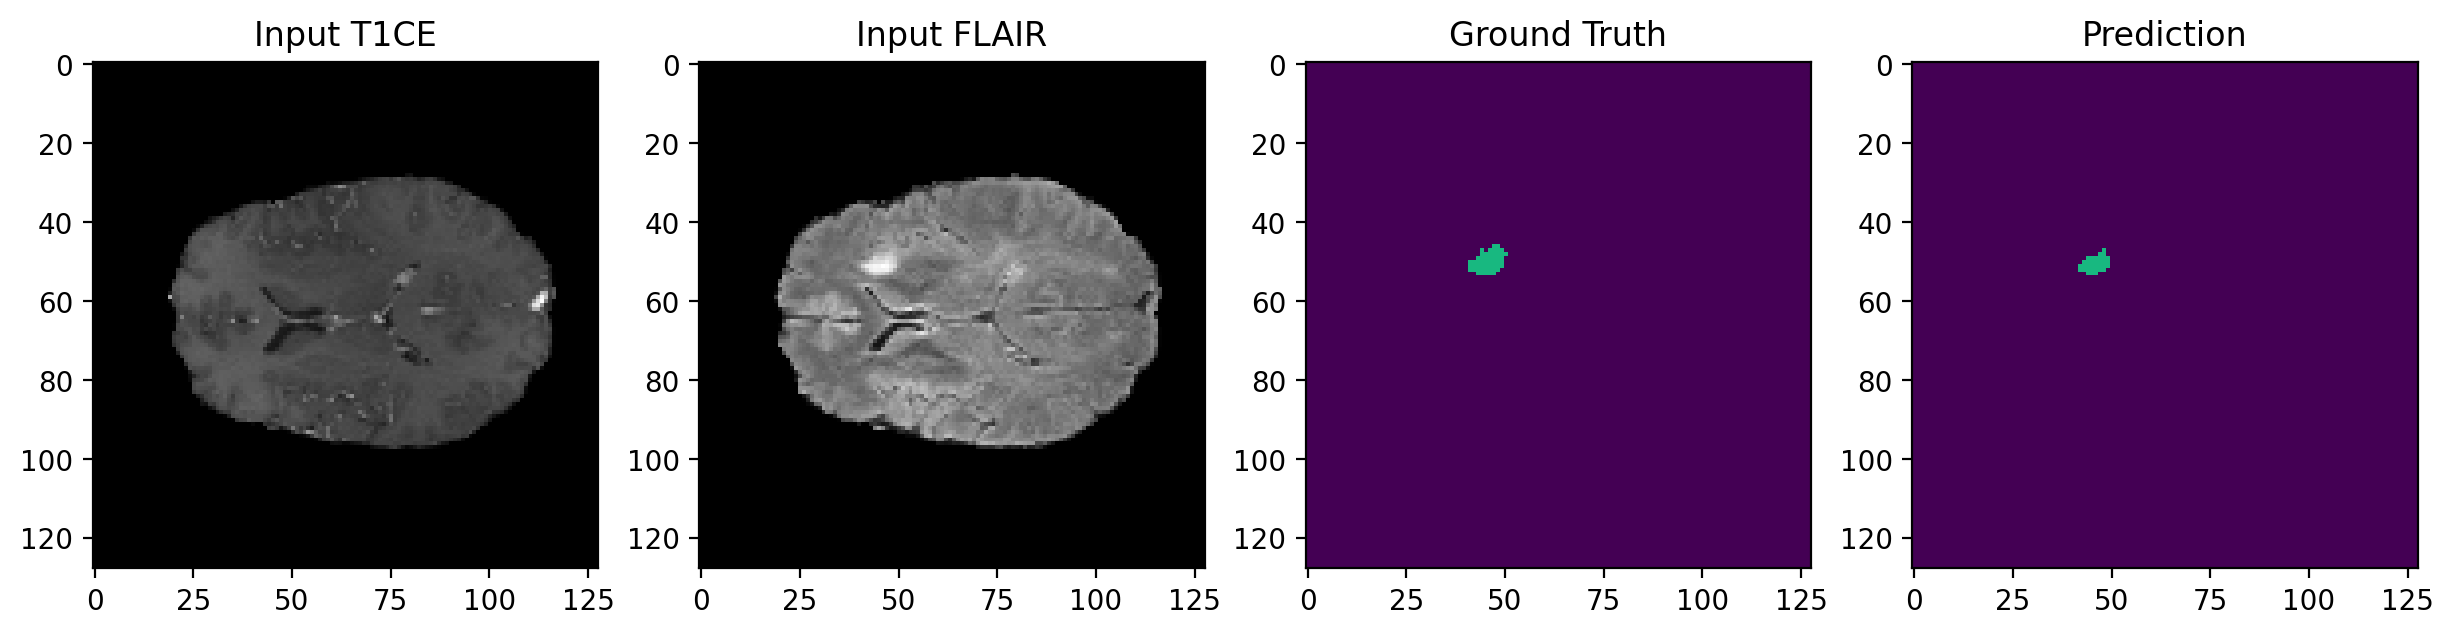

Visualizing slice index: 35


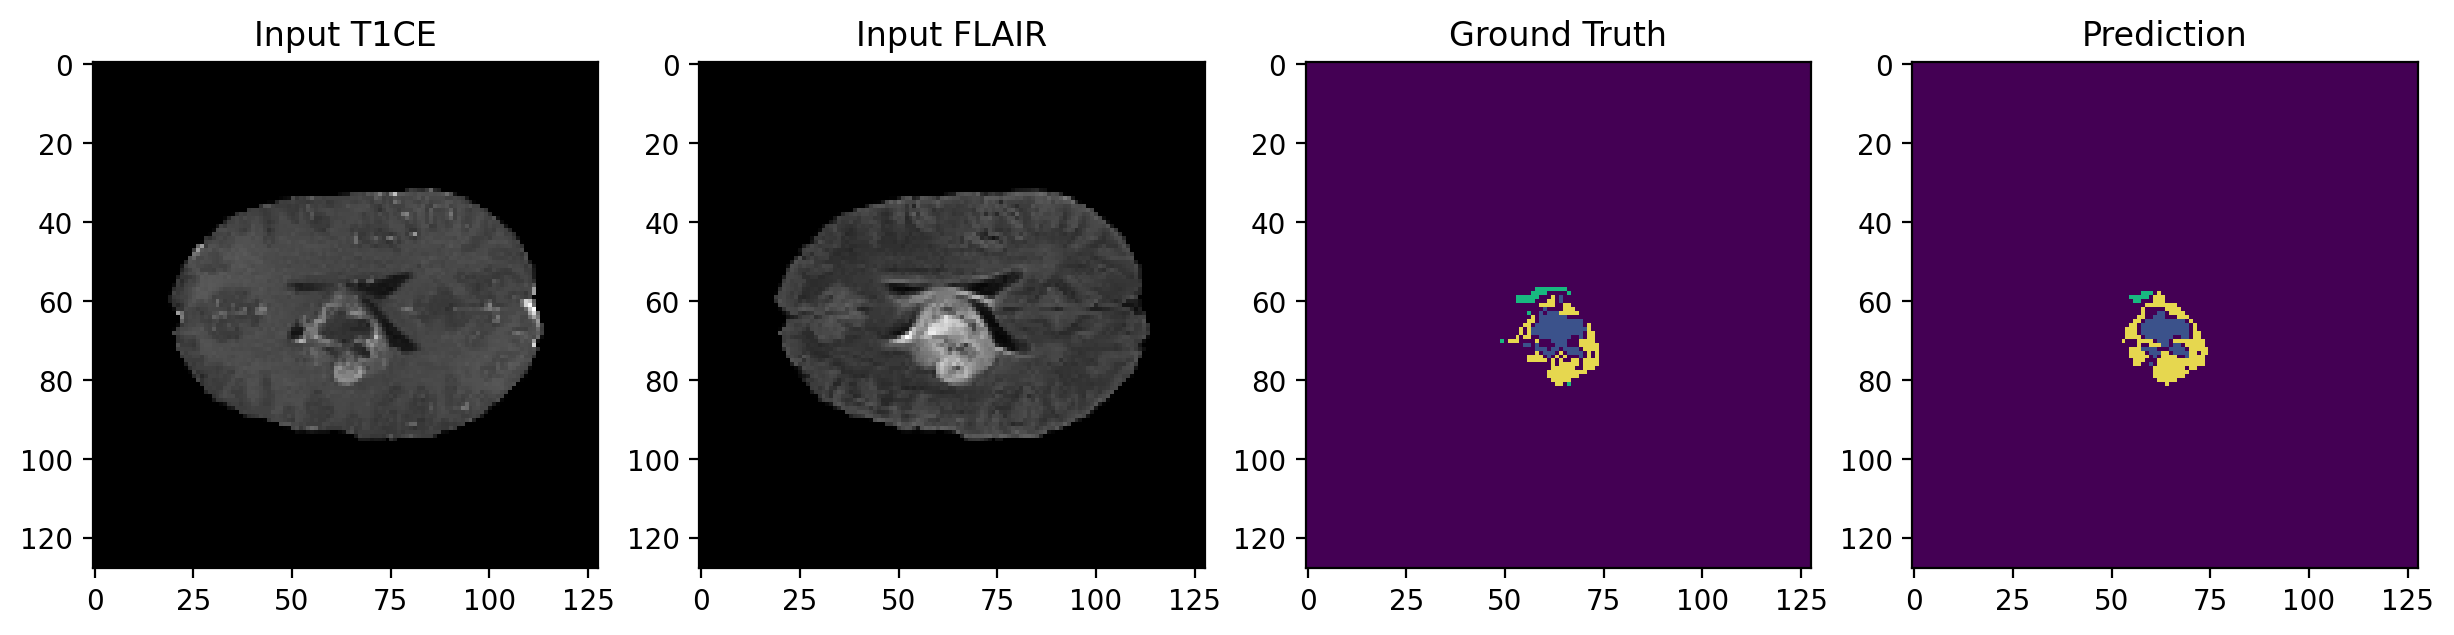

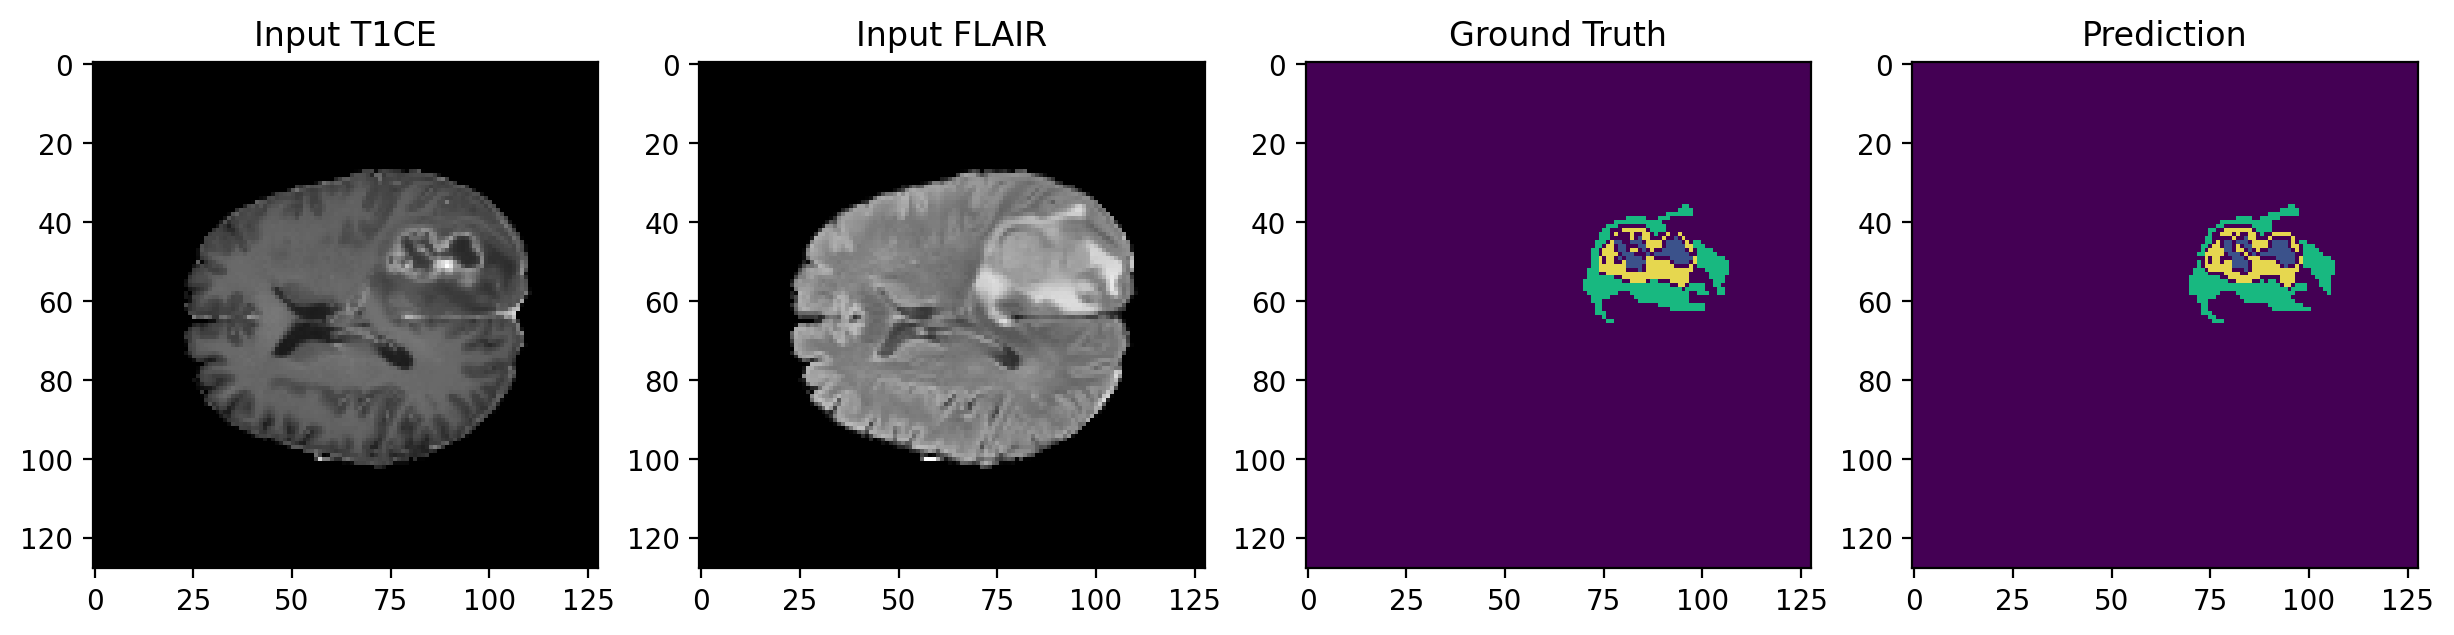

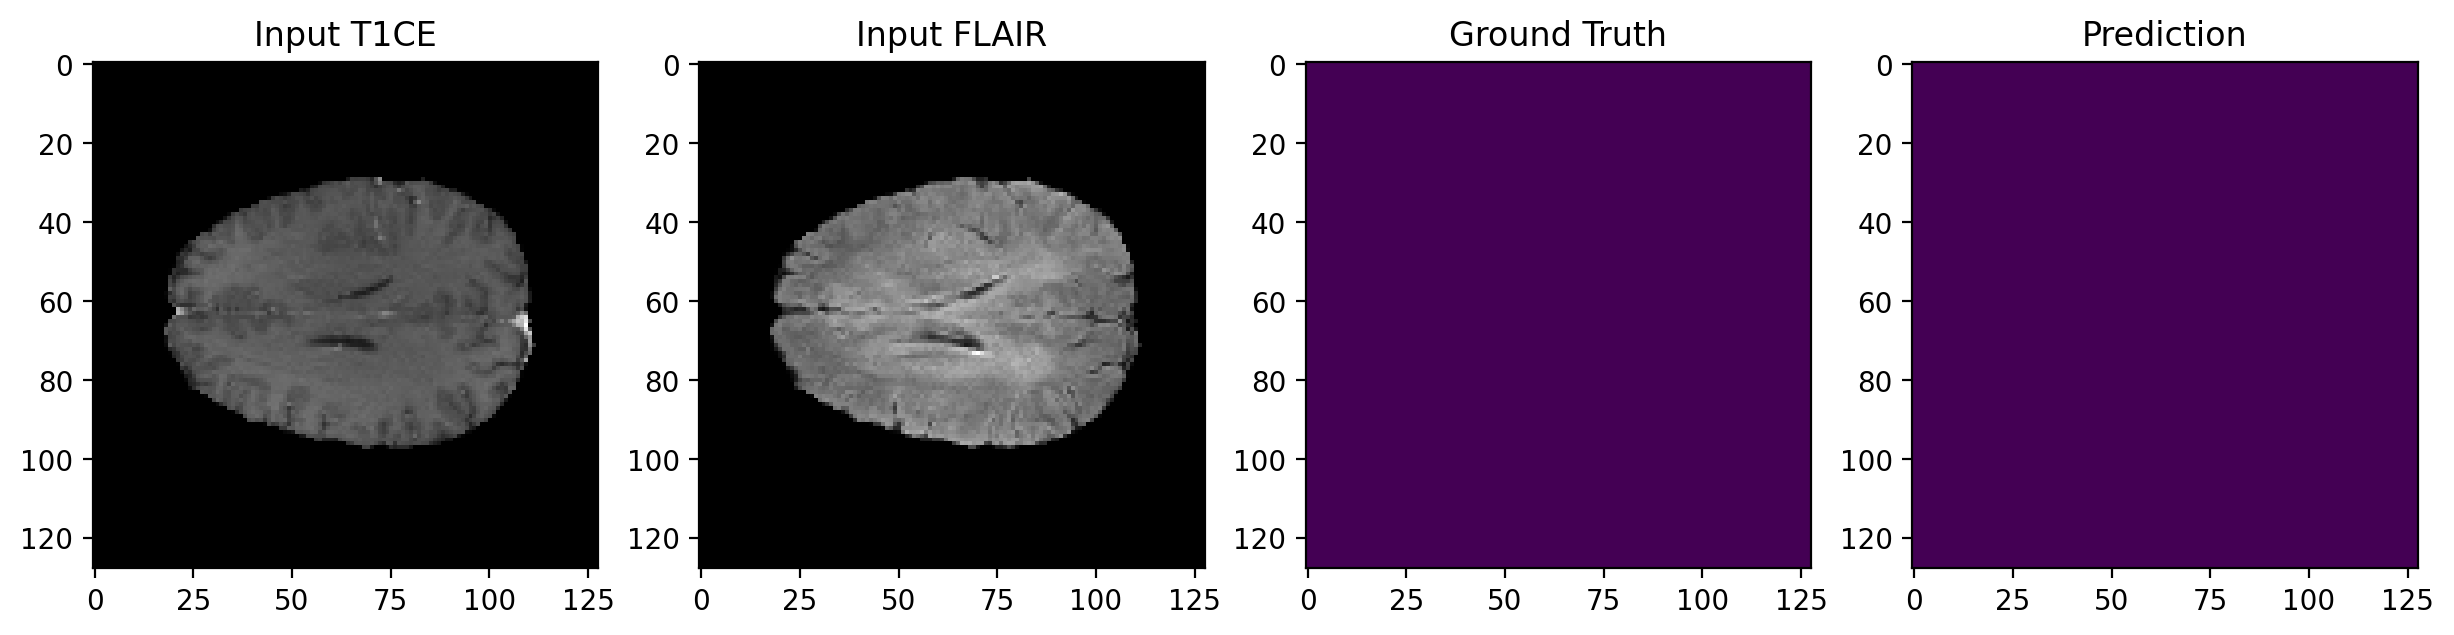

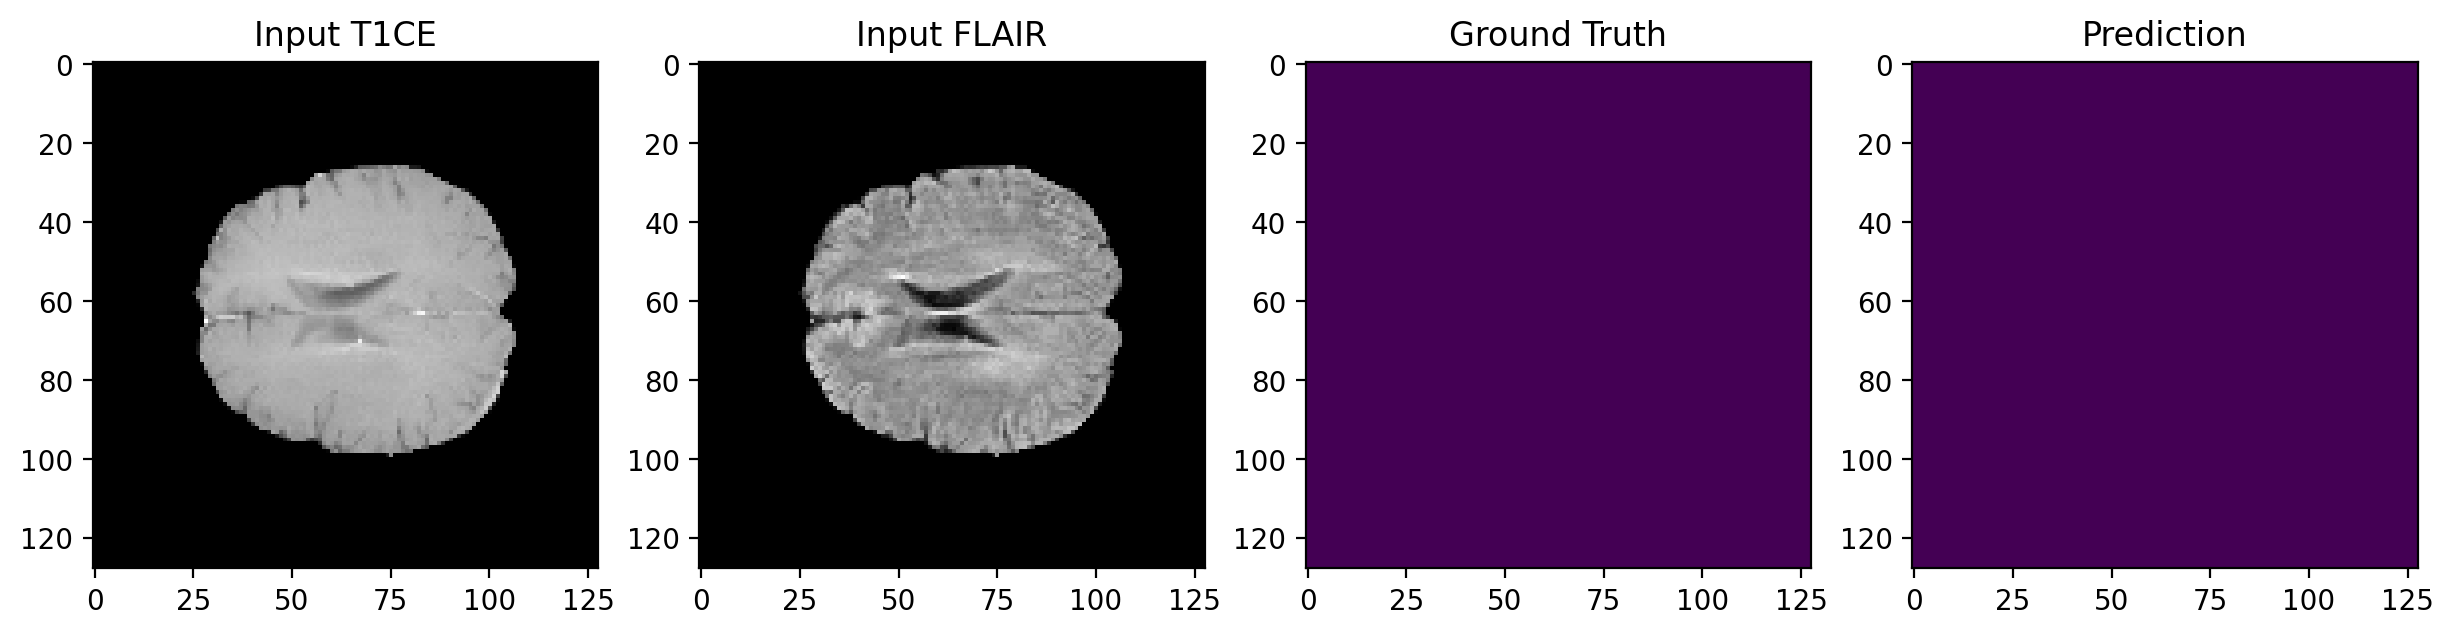

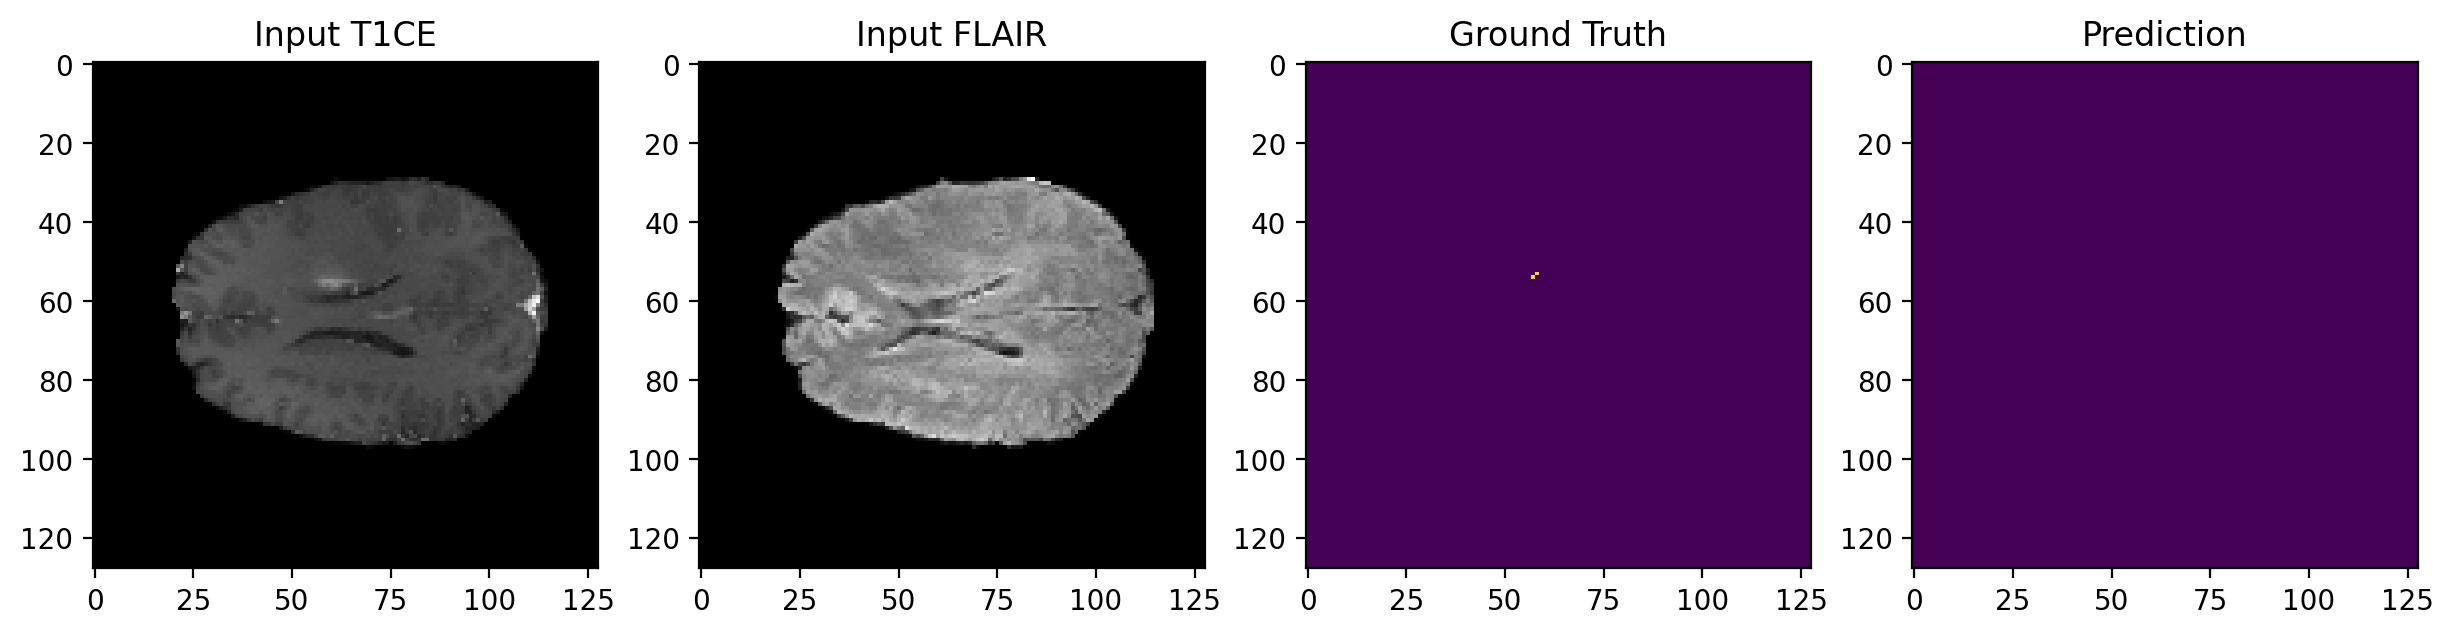

Visualizing slice index: 45


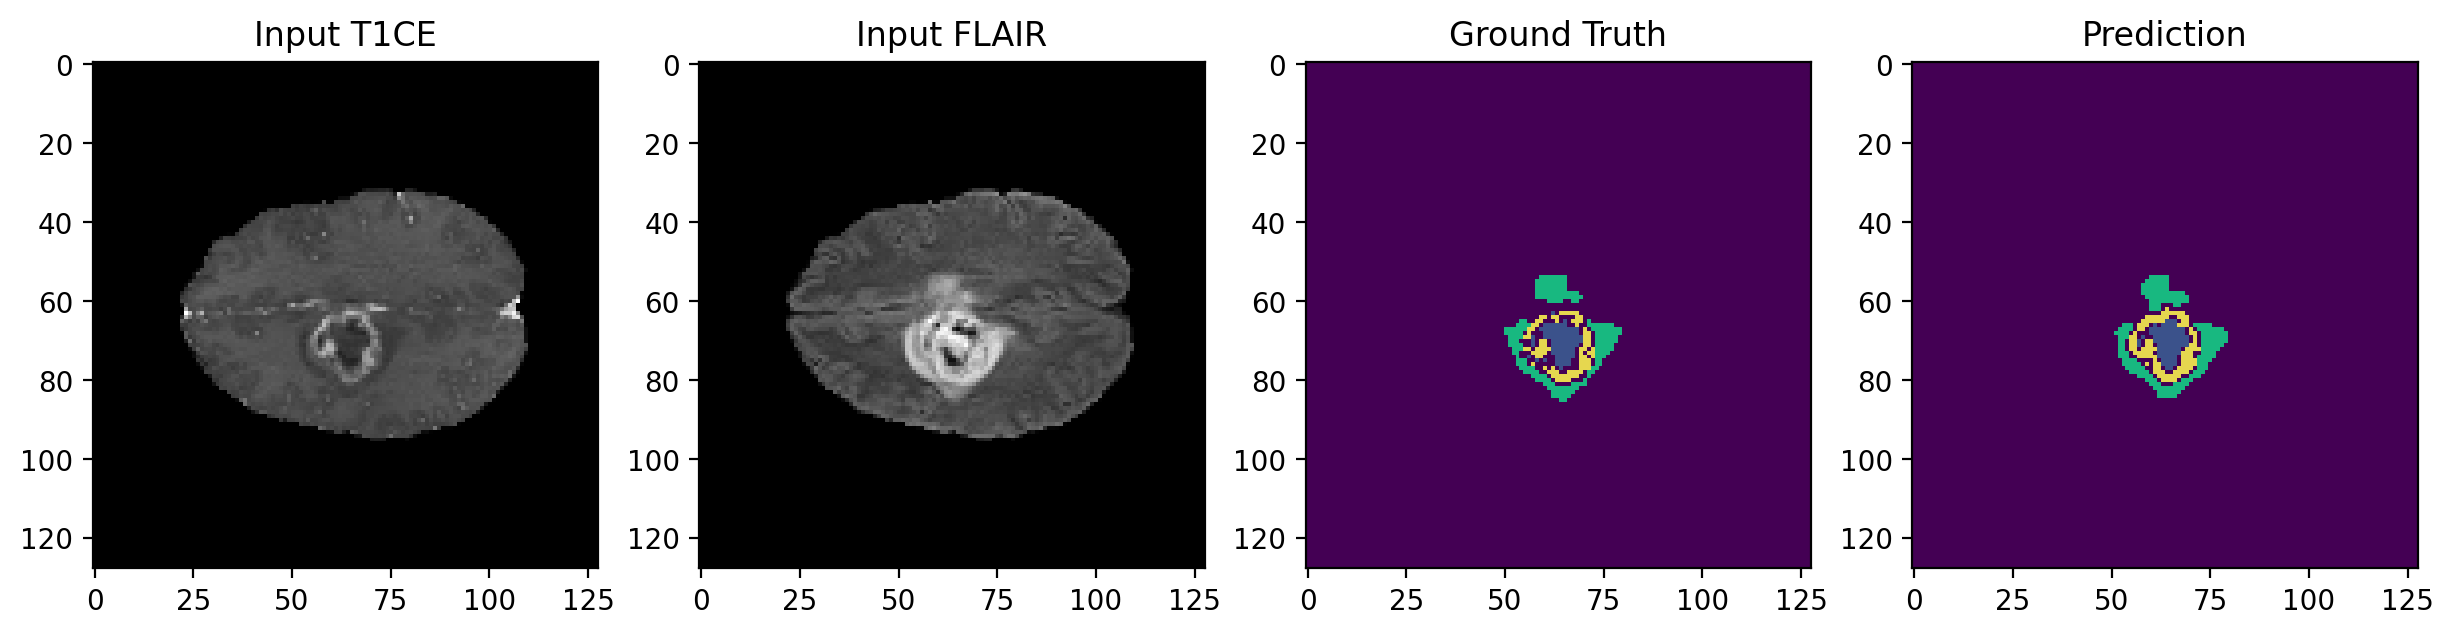

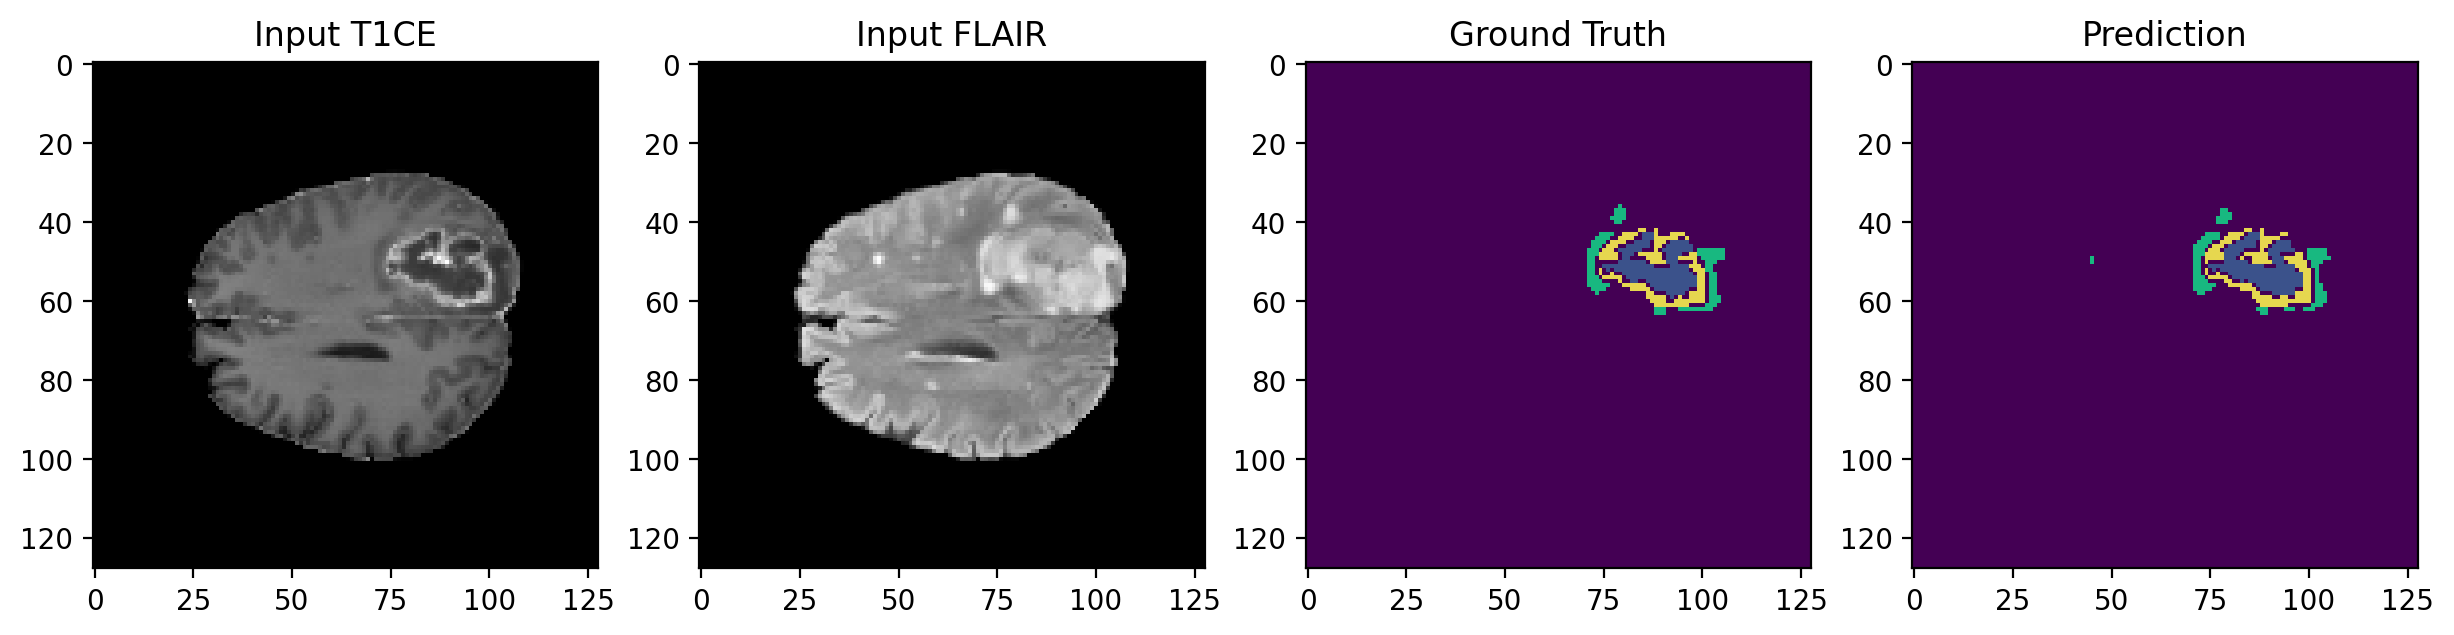

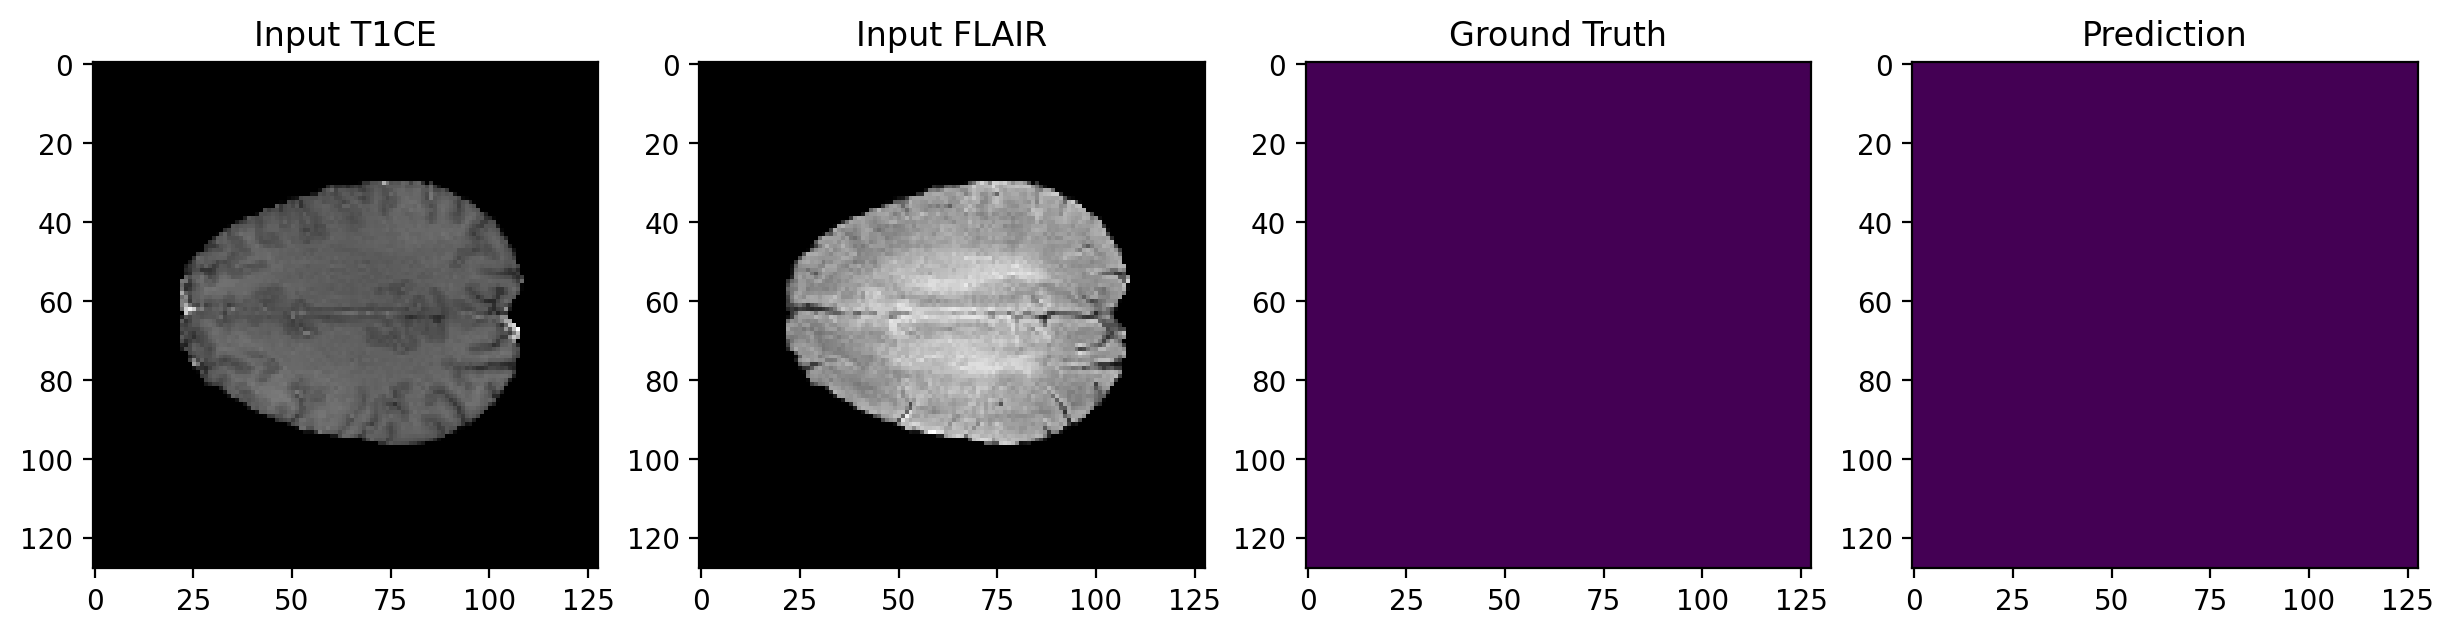

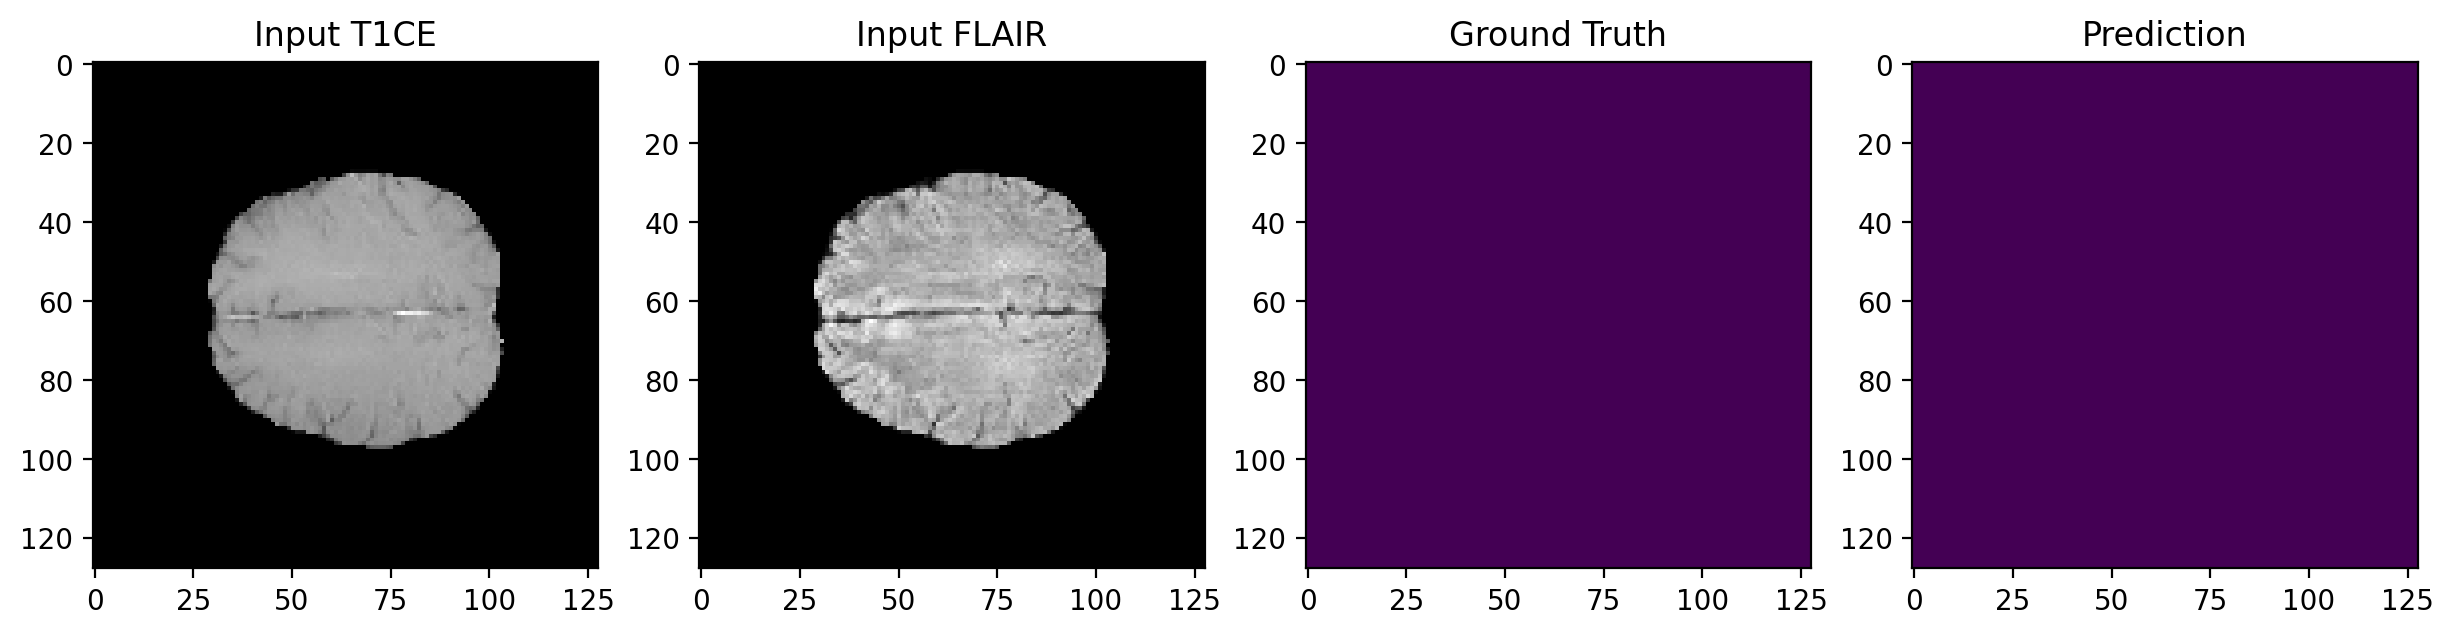

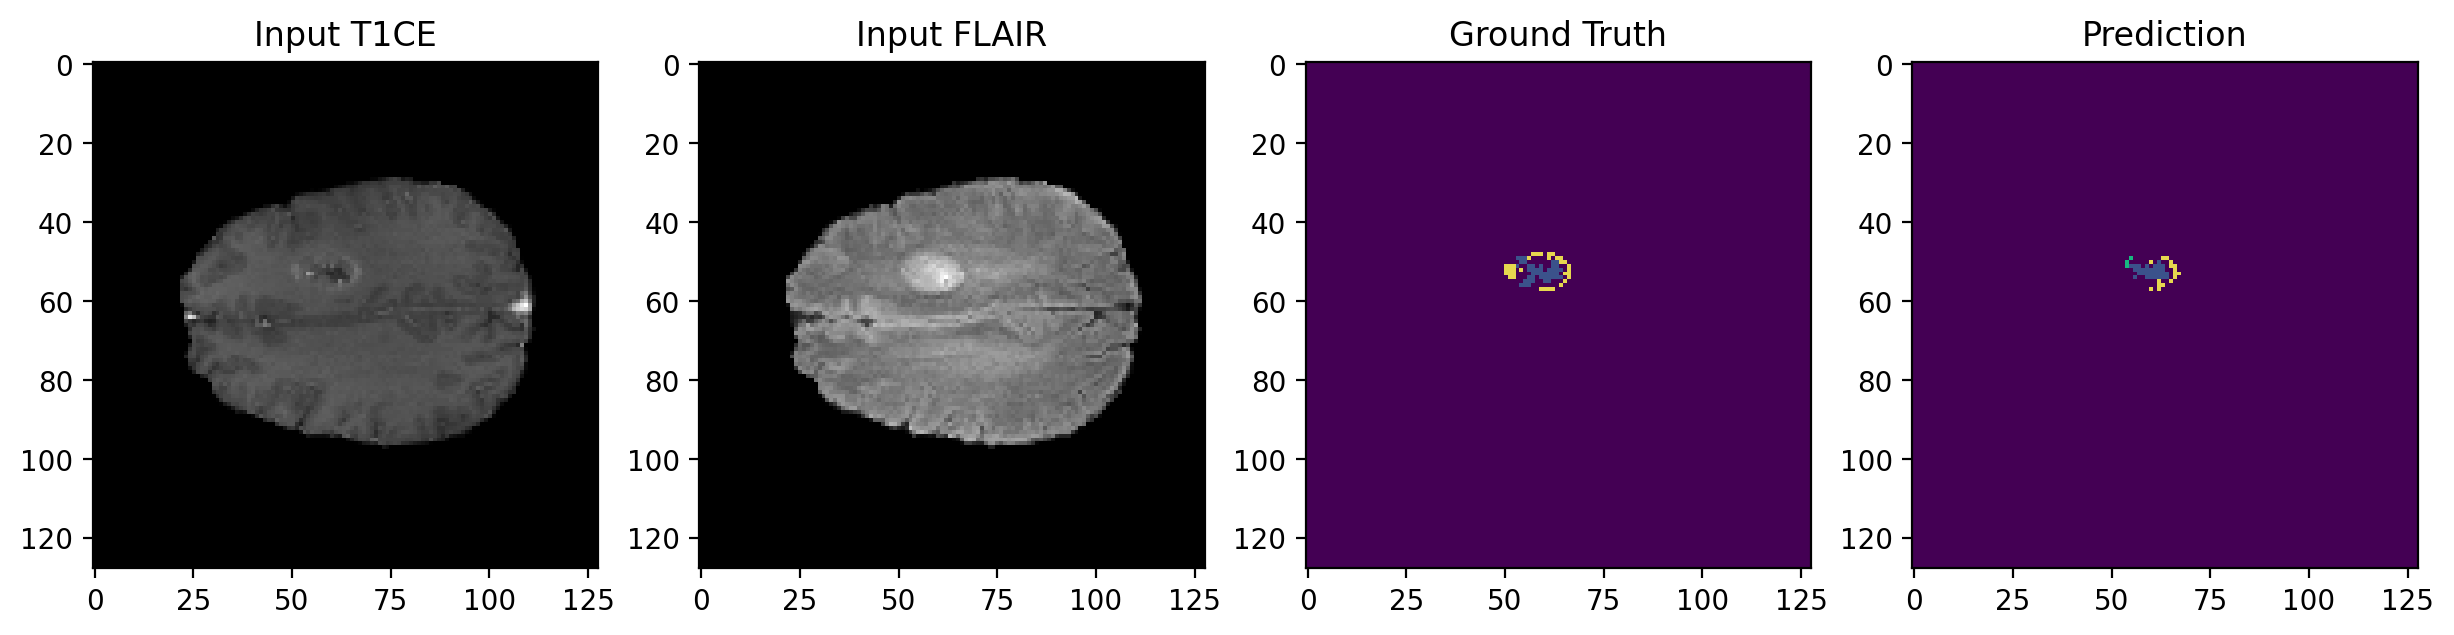

In [44]:
# Validation set
quick_visualize(model, test_loader, device, 5, [5,15,25,35,45])

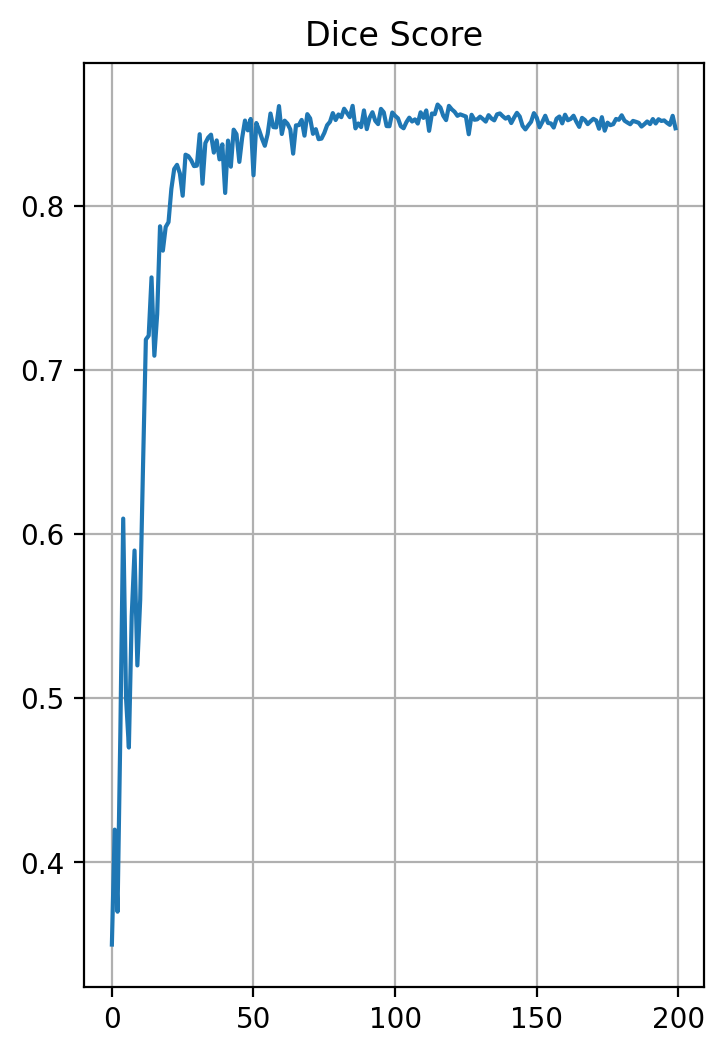

In [46]:
# Plotting Dice Score
plt.figure(figsize=(4,6))
plt.grid()
plt.title('Dice Score')
plt.plot(d[:200])
plt.savefig('dice.svg' ,format='svg')